In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import imageio
import json
import time

from collections import Counter
from matplotlib.pyplot import figure
from matplotlib import animation

from Bio.PDB import *
import nglview as nv
import math
import warnings
from Bio.PDB.StructureBuilder import PDBConstructionWarning
warnings.filterwarnings("ignore", category=PDBConstructionWarning)

# this is dangerous of course but uncomment it when you want to run the code
# warnings.filterwarnings("ignore")

from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment



# seg_dir = "C:\Users\Kevin\Documents\TDA\afrl\Segmentations"
# seg_dir = "C:/Users/Kevin/Documents/TDA/afrl/Segmentations"
seg_dir = "../Batch_protein_all_5_3_no_na.csv_2019.07.08 16.10/"

In [2]:
# aaron's code to make sure the folders are all in their proper place

dirlocal = os.path.curdir
data_path = os.path.join(dirlocal, 'Data/')
protein_path = os.path.join(data_path, 'Proteins/')
pdb_path = os.path.join(data_path, 'PDB/')
fasta_path = os.path.join(data_path, 'fasta/')
dssp_path = os.path.join(data_path, 'DSSP/')

if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(protein_path):
    os.makedirs(protein_path)
if not os.path.exists(pdb_path):
    os.makedirs(pdb_path)
ss_path = os.path.join(data_path, 'ss.txt')
feature_path = os.path.join(data_path, 'sample-input-features.npy')
distance_path = os.path.join(data_path, 'sample-distance-maps-cb.npy')
full_feature_path = os.path.join(data_path, 'full-input-features.npy')
full_distance_path = os.path.join(data_path, 'full-distance-maps-cb.npy')
test_feature_path = os.path.join(data_path, 'testset-input-features.npy')
test_distance_path = os.path.join(data_path, 'testset-distance-maps-cb.npy')


In [3]:
## aaron's code to get raw features from pdb

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
%matplotlib inline
import time
import requests
import xml.etree.ElementTree as ET

# ! pip install biopython
# ! pip install nglview
# ! jupyter-nbextension enable nglview --py --sys-prefix

from Bio.PDB import *
import nglview as nv
import math
import warnings
from Bio.PDB.StructureBuilder import PDBConstructionWarning
warnings.filterwarnings("ignore", category=PDBConstructionWarning)

# this is dangerous of course but uncomment it when you want to run the code
# warnings.filterwarnings("ignore")

from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment


In [4]:
def fix_chip_start_stop(df, step_size, chip_size):

    ch=[int(x.split("_")[-1]) for x in df['chip_id']]

    start=[c*step_size for c in ch]
    stop=[chip_size+c*step_size for c in ch]

    df['start']=start
    df['stop']=stop
    
    return df

In [5]:
###  aaron's functions: 

# gets dataframe containing torsion angles, peptides, chain, etc
# from pdb file
def get_torsion_angles(pdb_id, degrees=False):
    pdb_struct = get_pdb_structure(pdb_id)
    torsion_angles = []
    for model in pdb_struct:
        for chain in model:
            polypeptides = PPBuilder().build_peptides(chain)
            for poly_index, poly in enumerate(polypeptides):
                #print("Model %s Chain %s" % (str(model.id), str(chain.id)))
                #print("(part %i of %i)" % (poly_index+1, len(polypeptides)))
                #print("length %i" % (len(poly)))
                #print("from %s%i" % (poly[0].resname, poly[0].id[1]))
                #print("to %s%i" % (poly[-1].resname, poly[-1].id[1]))
                phi_psi = poly.get_phi_psi_list()
                for res_index, residue in enumerate(poly):
                    res_name = "%s%i" % (residue.resname, residue.id[1])
                    #print(res_name, tuple(math.degrees(b) for b in phi_psi[res_index] if b))
                    deg = phi_psi[res_index]
                    if degrees:
                        deg = tuple(math.degrees(b) if b else None for b in deg)
                    phi, psi = deg
                    model_name, model_id = model.full_id
                    torsion_angles.append([model_name, model_id, chain.id, residue.resname, residue.id[1], phi, psi])
    return pd.DataFrame(torsion_angles, columns=['Model_Name', 'Model_ID', 'Chain', 'Residue_Name', 'Residue_ID', 'Phi', 'Psi'])


# generates ramachandran plot from a given pdb file
def ramachandran_plot(pdb_id, degrees=True):
    df = get_torsion_angles(pdb_id, degrees)
    x = df['Phi']
    y = df['Psi']
    # Generate plot
    plt.plot(x, y, ".")
    plt.title('Ramachandran Plot')
    if degrees:
        plt.xlabel(f'$\Phi$ Angle (Degrees)')
        plt.xlim(-180, 180)
        plt.ylabel(f'$\Psi$ Angle (Radians)')
        plt.ylim(-180, 180)
        plt.show()
    else:
        plt.xlabel(f'$\Phi$ Angle (Radians)')
        plt.xlim(-math.pi, math.pi)
        plt.ylabel(f'$\Psi$ Angle (Radians)')
        plt.ylim(-math.pi, math.pi)
        plt.show()

# helper function which generates a biopython structure
# for display in display_protein()
def get_pdb_structure(pdb_id):
    pdb_id = pdb_id.upper()
    parser = PDBParser()
    file_path = os.path.join(pdb_path, f"{pdb_id}.pdb")
    try:
        struct = parser.get_structure(pdb_id, file_path)
    except Exception as e:
        print(e)
        return None
    return struct


#  downloads the protein in question from pdb
def get_pdb_file(pdb_id, replace=False):
    pdb_id = pdb_id.upper()
    file_path = os.path.join(pdb_path, f'{pdb_id}.pdb')
    if os.path.isfile(file_path) and not replace:
        return True
    parser = PDBParser()
    url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    resp = requests.get(url)
    try:
        #print(file_path)
        file = open(file_path, "wb")
        file.write(resp.content)
        file.close()
    except Exception as e: 
        print(e)
        return False
    return True

# neato 3d viewer of a protein's structure
def display_protein(pdb_id):
    pdb_struct = get_pdb_structure(pdb_id)
    view = nv.show_biopython(pdb_struct)
    return view


#  returns a dataframe with secondary structure, amino acid code, chain id, etc
# deprecated
def get_secondary_structure(pdb_id):
    pdb_id = pdb_id.upper()
    indexes = get_pdb_ss_seq(pdb_id)
    chain_df = []
    for i, chain_ss in enumerate(indexes):
        chain_id, seq, ss = chain_ss
        #unknown_list = [i for i, c in enumerate(seq) if c == 'X']
        #print(unknown_list)
        seq_list = [c for c in seq]
        # [f(x) if condition else g(x) for x in sequence]
        ss_list = ['L' if c is ' ' else c for c in ss]
        #print(seq_list + ss_list)
        chain_df.append(pd.DataFrame({'Chain': chain_id, 'Amino_Acid':seq_list, 'Secondary_Structure':ss_list}))
    return pd.concat(chain_df)

# get matrix of pairwise carbon beta distances
def get_cb_distances(full_pdb_id, partial=False):
    pdb_id = full_pdb_id[0:4].upper()
    get_pdb_file(pdb_id)
    pdb_struct = get_pdb_structure(pdb_id)  # Returns the BioPython structure of the PDB file
    ppb = PPBuilder()
    chain_dist_matrix = {}
    for model in pdb_struct:
        for chain in model:
            if chain.id == full_pdb_id[4] and partial:
                residues = []
                for pp in ppb.build_peptides(chain, aa_only=False):
                    for residue in pp:
                        residues.append(residue)
                lng = len(residues)
                dist_matrix = np.zeros((lng, lng), np.float)
                for i in range(0, lng):
                    for j in range(i, lng):
                        try:
                            diff_vector  = residues[i]['C'].coord - residues[j]['C'].coord
                        except Exception:
                            # This just gets the average value around the unknown residue distance
                            count = 0
                            sums = 0
                            if j - 1 > 0:
                                count += 1
                                sums += dist_matrix[i][j - 1]
                            if i - 1 > 0:
                                count += 1
                                sums += dist_matrix[i - 1][j]
                            if count > 0:
                                diff_vector = sums / count
                            else:
                                diff_vector = 0
                        dist = np.sqrt(np.sum(diff_vector * diff_vector))
                        dist_matrix[i][j] = dist
                        dist_matrix[j][i] = dist
                    chain_dist_matrix = dist_matrix
        
    if partial:
        start_pos, end_pos, bool_arr = get_seq_pos(full_pdb_id)
        if start_pos == -1:
            return pd.DataFrame(chain_dist_matrix[bool_arr]).iloc[:, bool_arr]
        return pd.DataFrame(chain_dist_matrix[start_pos:end_pos]).iloc[:, start_pos:end_pos]
    else:
        return chain_dist_matrix
    
    
# gets alignment of given sequence on top of the original sequence
# from a fasta file downloaded from the cloud repository
def get_seq_alignment(full_pdb_id):
    seq = ''
    for record in SeqIO.parse(os.path.join(fasta_path, f'{full_pdb_id}.fasta'), "fasta"):
        seq = record.seq
    pdb_id = full_pdb_id[0:4].upper()
    #print(pdb_id)
    get_pdb_file(pdb_id)
    struct = get_pdb_structure(pdb_id)
    ppb = PPBuilder()
    for model in struct:
        for chain in model:
            if chain.id == full_pdb_id[4]:
                ground_seq = ''
                for pp in ppb.build_peptides(chain, aa_only=False):
                    ground_seq += pp.get_sequence()
                alignments = pairwise2.align.globalxx(ground_seq, str(seq))
                al_seq = alignments[0][1]
                al_seq_bool = [False if a is '-' else True for a in al_seq]
                return al_seq_bool

            
def get_seq_pos(full_pdb_id):
    seq = ''
    for record in SeqIO.parse(os.path.join(fasta_path, f'{full_pdb_id}.fasta'), "fasta"):
        seq = str(record.seq)
    pdb_id = full_pdb_id[0:4].upper()
    get_pdb_file(pdb_id)
    struct = get_pdb_structure(pdb_id)
    ppb = PPBuilder()
    for model in struct:
        for chain in model:
            if chain.id == full_pdb_id[4]:
                ground_seq = ''
                for pp in ppb.build_peptides(chain, aa_only=False):
                    ground_seq += pp.get_sequence()
                start_pos = ground_seq.find(seq)
                if start_pos == -1:
                    alignments = pairwise2.align.globalxx(ground_seq, seq)
                    al_seq = alignments[0][1]
                    bool_seq = [False if a == '-' else True for a in al_seq]
                    #start_pos = largest_substring_pos(ground_seq, seq)
                    #start_pos = int(alignments[0][2] - 1)
                    #end_pos = start_pos + len(al_seq)
                    return (-1, -1, bool_seq)
                else:
                    end_pos = start_pos + len(seq)
                    return (start_pos, end_pos, '')


            
            
# calls dssp api to get dssp file
def pdb_id_to_dssp_file(pdb_id, replace=False):
    pdb_id = pdb_id.upper()
    rest_url = 'http://www.cmbi.umcn.nl/xssp/'
    # Read the pdb id data into a variable
    data = {'data': pdb_id}

    # Send a request to the server to create hssp data from the pdb file data.
    # If an error occurs, an exception is raised and the program exits. If the
    # request is successful, the id of the job running on the server is
    # returned.
    url_create = f'{rest_url}api/create/pdb_id/dssp/'
    r = requests.post(url_create, data=data)
    r.raise_for_status()

    job_id = json.loads(r.text)['id']
    #print(f'Job submitted successfully. Id is: {job_id}')

    # Loop until the job running on the server has finished, either successfully
    # or due to an error.
    ready = False
    while not ready:
        # Check the status of the running job. If an error occurs an exception
        # is raised and the program exits. If the request is successful, the
        # status is returned.
        url_status = f'{rest_url}api/status/pdb_id/dssp/{job_id}/'
        r = requests.get(url_status)
        r.raise_for_status()

        status = json.loads(r.text)['status']
        #print(f'Job status is: {status}')

        # If the status equals SUCCESS, exit out of the loop by changing the
        # condition ready. This causes the code to drop into the `else` block
        # below.
        #
        # If the status equals either FAILURE or REVOKED, an exception is raised
        # containing the error message. The program exits.
        #
        # Otherwise, wait for five seconds and start at the beginning of the
        # loop again.
        if status == 'SUCCESS':
            ready = True
        elif status in ['FAILURE', 'REVOKED']:
            raise Exception(json.loads(r.text)['message'])
        else:
            time.sleep(5)
    else:
        # Requests the result of the job. If an error occurs an exception is
        # raised and the program exits. If the request is successful, the result
        # is returned.
        url_result = f'{rest_url}api/result/pdb_id/dssp/{job_id}/'
        r = requests.get(url_result)
        r.raise_for_status()
        result = json.loads(r.text)['result']
        try:
            file_path = os.path.join(dssp_path, f'{pdb_id}.dssp')
            if os.path.isfile(file_path) and not replace:
                return True
            #print(file_path)
            file = open(file_path, "w")
            file.write(result)
            file.close()
        except Exception as e: 
            print(e)
            return False
        # Return the result to the caller, which prints it to the screen.
        return True

# uses api call file to generate secondary structure, phi/psi, solvent-accessibility stuff
# because of indexing stuff, it crashes if we use partial = True
# ask aaron about that
def get_ground_truth_api(full_pdb_id, partial=False):
    pdb_id = full_pdb_id[0:4].upper()
    get_pdb_file(pdb_id)
    struct = get_pdb_structure(pdb_id)
    ppb = PPBuilder()
    struct_info = []
    for model in struct:
        file = os.path.join(pdb_path, f'{pdb_id}.pdb')
        pdb_id_to_dssp_file(pdb_id)
        dssp = DSSP(model=model, in_file=os.path.join(dssp_path, f'{pdb_id}.dssp'), file_type='DSSP')
        seq_count = 0
        #dssp = DSSP(model=model, in_file=file)
        for chain in model:
            if chain.id == full_pdb_id[4] or not partial:
                residues = []
                seq = ''
                for pp in ppb.build_peptides(chain, aa_only=False):
                    seq += pp.get_sequence()
                    for residue in pp:
                        residues.append(residue)
                for i, residue in enumerate(residues):
                    try:
                        key = list(dssp.keys())[seq_count]   
                        dssp_info = dssp[key]
                        amino_acid = dssp_info[1]
                        sec_struct = dssp_info[2]
                        solv_acc = dssp_info[3]
                        phi = dssp_info[4]
                        psi = dssp_info[5]
                    except Exception:
                        # DSSP didn't capture this amino acid
                        #print(full_pdb_id, seq_count, len(dssp), len(seq), residue)
                        amino_acid = seq[i]
                        sec_struct = '-'
                        solv_acc = 0
                        phi = 360
                        psi = 360
                    seq_count += 1
                    # Keys 6 through 13 is bonding energy / relidx (no clue what this is)
                    struct_info.append([model.full_id[0], model.full_id[1], chain.id,
                        residue.resname, residue.id[1], amino_acid, sec_struct, solv_acc, phi, psi])
    info_df = pd.DataFrame(struct_info, 
        columns=['Model_Name', 'Model_ID', 'Chain', 'Residue_Name',
        'Residue_ID', 'Amino_Acid', 'Secondary_Structure', 'Solvent_Accessability', 
        'Phi', 'Psi'])
    if partial:    
        start_pos, end_pos, bool_arr = get_seq_pos(full_pdb_id)
        if start_pos == -1:
            return info_df[bool_arr]
        return info_df[start_pos:end_pos]
    else:
        return info_df


    
# the following two functions download the files from the api
# to create a cache on the disk
# speeds things up immensely, only need to run once though
def get_ground_truth_files(full_pdb_id, replace=False, partial=False):
    bad_list = ['4osnA0']
    if full_pdb_id in bad_list:
        return 'Bad File'
    if partial:
        file_path = os.path.join(protein_path, full_pdb_id + '.csv')
    else:
        file_path = os.path.join(protein_path, full_pdb_id[0:4] + '.csv')
        
    if os.path.isfile(file_path) and not replace:
        return True
    
    df = get_ground_truth(full_pdb_id, partial)
    file_path = ''
    try:
        df.to_csv(file_path)
    except Exception:
        return False
    return True
    
def get_cb_distance_files(full_pdb_id, replace=False, partial=False):
    bad_list = ['4osnA0']
    if full_pdb_id in bad_list:
        return 'Bad File'
    file_path = ''
    if partial:
        file_path = os.path.join(distances_path, full_pdb_id + '.csv')
        if os.path.isfile(file_path) and not replace:
            return True
        try:
            df = get_cb_distances(full_pdb_id, partial)
            df.to_csv(file_path)
        except Exception:
            return False
        return True
    else:
        df = get_cb_distances(full_pdb_id, partial)
        keys = df.keys
        for key in keys:
            file_path = os.path.join(distances_path, full_pdb_id[0:4] + key + '0.csv')
            if os.path.isfile(file_path) and not replace:
                return True
            try:
                df[key].to_csv(file_path)
            except Exception:
                return False
        return True

def get_ground_truth_from_file(pdb_id):
    return pandas.read_csv(os.path.join("computed_ground_truth_cache",pdb_id.upper()+".csv"))

In [6]:
dataset_25=pandas.read_csv("datasets/protein_all_25_12_no_na.csv")
dataset_10=pandas.read_csv("datasets/protein_all_10_5_no_na.csv")
dataset_5=pandas.read_csv("datasets/protein_all_5_3_no_na.csv")

fix_chip_start_stop(dataset_25,12,25)
fix_chip_start_stop(dataset_10,5,10)
fix_chip_start_stop(dataset_5,3,5)

training=True

if training:
    pdb_list, length_dict, input_features = np.load("datasets/full-input-features.npy",allow_pickle=True)
    pdb_list_y, distance_maps_cb = np.load("datasets/full-distance-maps-cb.npy",encoding="latin1",allow_pickle=True)
else:
    pdb_list, length_dict, aa_seq, input_features = np.load("datasets/testset-input-features.npy",allow_pickle=True)
    pdb_list_y, distance_maps_cb = np.load("datasets/testset-distance-maps-cb.npy",encoding="latin1",allow_pickle=True)


In [7]:
# functions
def get_rows_from_segmentation(seg, dataset):
    with open(seg_dir+seg) as jsonf:
        a=json.load(jsonf)
        df=dataset.iloc[[int(m) for m in a['rows']],:]
        return df


In [8]:

def draw_ss_predicts(index,ss):
    
#     H, G and I to H; E to E; the rest to C
    ss_dict={
        "H":0,
        "G":0,
        "I":0,
        "E":1,
        "B":2,
        "T":2,
        "S":2             
            }
    
    aa_length=length_dict[pdb_list[index]]
    
    plt.figure(figsize=(15,10))

    df25=dataset_25[dataset_25["protein_id"]==dataset_25["protein_id"].unique()[index]] 
    df10=dataset_10[dataset_10["protein_id"]==dataset_10["protein_id"].unique()[index]] 
    df5=dataset_5[dataset_5["protein_id"]==dataset_5["protein_id"].unique()[index]] 

    plt.subplot(4,1,1)
    y=ground_truth_window_avg(df5)["ground_truth_"+ss]
    x=range(0,len(y))
    plt.bar(x,y,1)
    plt.xlim((0,aa_length))    

    plt.subplot(4,1,2)
    y=ground_truth_window_avg(df10)["ground_truth_"+ss]
    x=range(0,len(y))
    plt.bar(x,y,1)
    plt.xlim((0,aa_length))

    plt.subplot(4,1,3)
    y=ground_truth_window_avg(df25)["ground_truth_"+ss]
    x=range(0,len(y))
    plt.bar(x,y,1)
    plt.xlim((0,aa_length))

    plt.subplot(4,1,4)
    y=[1-n for n in input_features[pdb_list[index]][ss_dict[ss]].astype(np.float)]
    x=range(0,len(y))
    plt.bar(x,y,1)
    plt.xlim((0,aa_length))

def reduced_ss_from_ss(ss):
    ss_dict={
        "H":"H",
        "G":"H",
        "I":"H",
        "E":"E",
        "B":"E",
        "T":"C",
        "S":"C",
        "-":"C"
            }
    return ss_dict[ss]
    
def get_inv_psipred_from_ss(protein):
#     H to H; E to E; the rest to C
    ss_dict={
        "H":0,
        "G":0,
        "I":0,
        "E":1,
        "B":1,
        "T":2,
        "S":2,
        "-":2
            }
    
    # I subtract it from 1 to make it on the same scale as the other predictions
    # (i.e. high means more likely to be X)
    
    return [1-n for n in input_features[protein][ss_dict[ss]].astype(np.float)]


In [9]:
def get_reduced_ss(protein_id):
    ss_file=os.path.join(data_path,"ss",protein_id+".ss")
    sf=open(ss_file).read()
    return(list(sf.split("\n")[1]))
   
# get_reduced_ss("1bebA")

In [10]:
def ground_truth_window_avg(df):
    aa_length=max(df["stop"])
    mean_ss=[]
    gt=["ground_truth_"+ss for ss in "HBEGITS"]

    for aa in range(0,aa_length):
        chip=df[(df["start"]<=aa) & (df["stop"]>=aa)]
        mean_ss.append(chip[gt].mean(0))
    gt_avg=pandas.DataFrame(mean_ss)
    
    return gt_avg


In [11]:
def rmse(a,b):
    return np.sqrt(np.mean((a-b)**2))

def eval_test_data_new(leaf_df,dataset):
    output_df=pandas.DataFrame()
    
    for protein in pandas.unique(leaf_df['protein_id']):
        print(protein)
        mean_ss=[]
        gt_names=["pred_gt_"+ss for ss in "HBEGITS"]

        for aa in range(length_dict[protein]):
            chip=leaf_df[(leaf_df["start"]<=aa) & (leaf_df["stop"]>=aa)]
            mean_ss.append([protein]+list(chip[gt_names].mean(0)))
        gt_avg=pandas.DataFrame(mean_ss)
        gt_avg.columns=["protein_id"]+["pred_ss_"+ss for ss in "HBEGITS"]
        
        
        ssgt=[]
        
        for sec_s in "HBEGITS":
        # get gt for protein
            ss=get_ground_truth_api(protein)['Secondary_Structure']
            gt=[int(x) for x in ss==sec_s]
            gt_avg["ground_truth_"+sec_s]=gt
            
        gt_avg['psipred_helix']=input_features[protein][0].astype(np.float)
        gt_avg['psipred_sheet']=input_features[protein][1].astype(np.float)
        gt_avg['psipred_coil']=input_features[protein][2].astype(np.float)
        
        output_df.append(gt_avg)
    return output_df



def eval_test_data_reduced(leaf_df,dataset):
    output_df=pandas.DataFrame()
    
    for protein in pandas.unique(leaf_df['protein_id']):
        
        df_prot=leaf_df[leaf_df['protein_id']==protein]
        
        print(protein)
        mean_ss=[]
        gt_names=["thd_pred_helix","thd_pred_sheet","thd_pred_coil"]

        for aa in range(length_dict[protein]):
            chip=df_prot[(df_prot["start"]<=aa) & (df_prot["stop"]>=aa)]
            mean_ss.append([protein,aa]+list(chip[gt_names].mean(0)))
        gt_avg=pandas.DataFrame(mean_ss)
        gt_avg.columns=["protein_id","aa_index"]+["pred_ss_"+ss for ss in "HEC"]
        
        
        ssgt=[]
        
        for sec_s in "HEC":
        # get gt for protein
            if training: 
                secst=get_ground_truth_from_file(protein)['Secondary_Structure']
                ss="".join([reduced_ss_from_ss(s) for s in secst])
            else:
                ss=get_reduced_ss(protein)
            gt=[int(x==sec_s) for x in ss]
            gt_avg["ground_truth_"+sec_s]=gt
            
        gt_avg['psipred_helix']=input_features[protein][0].astype(np.float)
        gt_avg['psipred_sheet']=input_features[protein][1].astype(np.float)
        gt_avg['psipred_coil']=input_features[protein][2].astype(np.float)
        
        gt_avg['inv_psipred_helix']=1-input_features[protein][0].astype(np.float)
        gt_avg['inv_psipred_sheet']=1-input_features[protein][1].astype(np.float)
        gt_avg['inv_psipred_coil']=1-input_features[protein][2].astype(np.float)
 
        
        output_df=output_df.append(gt_avg)
        
    return output_df



# for each amino acid:
# get the chip containing that amino acid which has the minimum edit distance
# avg across chips which have equivalent edit distances
def eval_test_data_min_edit(leaf_df,dataset):
    output_df=pandas.DataFrame()
    
    for protein in pandas.unique(leaf_df['protein_id']):
        
        df_prot=leaf_df[leaf_df['protein_id']==protein]
        
        print(protein)
        mean_ss=[]
        gt_names=["thd_pred_helix","thd_pred_sheet","thd_pred_coil"]
      
        for aa in range(length_dict[protein]):
            chip=df_prot[(df_prot["start"]<=aa) & (df_prot["stop"]>=aa)]

            min_edit=min(chip["edit_dist"])
#             print(min_edit)
            chip_min=chip[chip["edit_dist"]==min_edit]
            mean_ss.append([protein,aa]+list(chip_min[gt_names].mean(0)))
        gt_avg=pandas.DataFrame(mean_ss)
        gt_avg.columns=["protein_id","aa_index"]+["pred_ss_"+ss for ss in "HEC"]
        
        
        ssgt=[]
        
        for sec_s in "HEC":
        # get gt for protein
            if training: 
                secst=get_ground_truth_from_file(protein)['Secondary_Structure']
                ss="".join([reduced_ss_from_ss(s) for s in secst])
            else:
                ss=get_reduced_ss(protein)
            gt=[int(x==sec_s) for x in ss]
            gt_avg["ground_truth_"+sec_s]=gt
            
        gt_avg['psipred_helix']=input_features[protein][0].astype(np.float)
        gt_avg['psipred_sheet']=input_features[protein][1].astype(np.float)
        gt_avg['psipred_coil']=input_features[protein][2].astype(np.float)
        
        gt_avg['inv_psipred_helix']=1-input_features[protein][0].astype(np.float)
        gt_avg['inv_psipred_sheet']=1-input_features[protein][1].astype(np.float)
        gt_avg['inv_psipred_coil']=1-input_features[protein][2].astype(np.float)
 
        
        output_df=output_df.append(gt_avg)
        
    return output_df

    
def seg_rows_formatted(thd_name,file_id,dataset):
    seg="GROUPDATA_"+thd_name+" "+file_id+".json"
    return get_rows_from_segmentation(thd_name+"/"+seg,dataset)


In [12]:
def add_pred_gt(leafdf,dataset):

    gt=["ground_truth_"+ss for ss in "HBEGITS"]

    ss_pred=pandas.DataFrame()

    for index, row in leafdf.iterrows():
        ssp=seg_rows_formatted(row['thd_id'],row['file_id'],dataset)[gt].mean(0)
        ss_pred=ss_pred.append(ssp, ignore_index=True)
        
    ss_pred.columns=["pred_gt_"+ss for ss in "HBEGITS"]
    return pandas.concat([leafdf,ss_pred],axis=1)

def add_pred_condensed(leafdf,dataset):
    
    gt=["ground_truth_"+ss for ss in "HBEGITS"]

    ss_pred=pandas.DataFrame()

    for index, row in leafdf.iterrows():
        ssp=seg_rows_formatted(row['thd_id'],row['file_id'],dataset)[gt]
        
        helix=["ground_truth_"+ss for ss in "HGI"]
        sheet=["ground_truth_"+ss for ss in "EB"]
        coil=["ground_truth_"+ss for ss in "TS"]

        hlx=ssp[helix].sum(axis=1)
        sh=ssp[sheet].sum(axis=1)
        cl=1-(hlx+sh)

        pred=pandas.concat([hlx,sh,cl],axis=1)

        ss_pred=ss_pred.append(pred.mean(axis=0),ignore_index=True)
    ss_pred.columns=["thd_pred_helix","thd_pred_sheet","thd_pred_coil"]
    return pandas.concat([leafdf,ss_pred],axis=1)


In [13]:
# example analysis flow

# thd_leafs=add_pred_condensed(pandas.read_csv("datasets/test6_sequences_pred.csv"),dataset_5)
# thd_leafs.to_csv("data/thd_leafs.csv")

# prediction_df=eval_test_data_reduced(thd_leafs,dataset_5)
# prediction_df.to_csv("data/reduced_predict_fixed.csv")

In [14]:
# example analysis flow

# thd_leafs=add_pred_condensed(pandas.read_csv("datasets/test6_sequences_pred.csv"),dataset_5)
# thd_leafs.to_csv("data/thd_leafs.csv")

# prediction_df=eval_test_data_reduced(thd_leafs,dataset_5)
# prediction_df.to_csv("data/reduced_predict_fixed.csv")

# this gives us a table of the accuracy results

def pred_accuracy(pred_df):

    rmse_df=pandas.DataFrame()

    psipred=["inv_psipred_helix","inv_psipred_sheet","inv_psipred_coil"]

    results_df=pandas.DataFrame()

    for ss in range(3):

        pred="pred_ss_"+"HEC"[ss]
        gt="ground_truth_"+"HEC"[ss]
        psi=psipred[ss]

        rmse_pred=rmse(pred_df[pred],pred_df[gt])
        acc_pred=1-np.mean(abs(pred_df[pred]-pred_df[gt]))

        rmse_psi=rmse(pred_df[psi],pred_df[gt])
        acc_psi=1-np.mean(abs(pred_df[psi]-pred_df[gt]))

        row=[["helix","sheet","coil"][ss]]+[rmse_pred,acc_pred,rmse_psi,acc_psi]
        row=pandas.Series(row)
        results_df=results_df.append(row,ignore_index=True)

    columns=["structure"]
    columns+=["thd_pred_rmse","thd_pred_accuracy"]
    columns+=["psipred_rmse","psipred_accuracy"]

    results_df.columns=columns
    
    return results_df



# accuracy for the aa that ARE x
def pred_accuracy_signal(pred_df):

    rmse_df=pandas.DataFrame()

    psipred=["inv_psipred_helix","inv_psipred_sheet","inv_psipred_coil"]

    results_df=pandas.DataFrame()

    for ss in range(3):

        pdf2=pred_df[pred_df['ground_truth_'+"HEC"[ss]]==1]

        pred="pred_ss_"+"HEC"[ss]
        gt="ground_truth_"+"HEC"[ss]
        psi=psipred[ss]

        rmse_pred=rmse(pdf2[pred],pdf2[gt])
        acc_pred=1-np.mean(abs(pdf2[pred]-pdf2[gt]))

        rmse_psi=rmse(pdf2[psi],pdf2[gt])
        acc_psi=1-np.mean(abs(pdf2[psi]-pdf2[gt]))

        row=[["helix","sheet","coil"][ss]]+[rmse_pred,acc_pred,rmse_psi,acc_psi]
        row=pandas.Series(row)
        results_df=results_df.append(row,ignore_index=True)

    columns=["structure_signal"]
    columns+=["thd_pred_rmse_signal","thd_pred_accuracy_signal"]
    columns+=["psipred_rmse_signal","psipred_accuracy_signal"]

    results_df.columns=columns

    return results_df

In [15]:
def ROC_curve(df,gt):
    roc_df=pandas.DataFrame()
    for th in np.linspace(0,1,100):
        
        # true positive 
        tp=pred_df[df['ground_truth_'+gt]==1]['pred_ss_'+gt]
        tpr=sum(tp>th)/len(tp)

        # false positive 
        fp=pred_df[df['ground_truth_'+gt]==0]['pred_ss_'+gt]
        fpr=sum(fp>th)/len(fp)

        roc_df=roc_df.append(pandas.Series(["thd_pred",gt,th,tpr,fpr]),ignore_index=True)
    roc_df.columns=["pred","gt","threshold","tpr","fpr"]
    return roc_df
    
def ROC_curve_psipred(df,gt):
    roc_df=pandas.DataFrame()
    ssd={"H":"helix",
        "E":"sheet",
        "C":"coil"}
    
    for th in np.linspace(0,1,100):

        # true positive 
        tp=1-pred_df[df['ground_truth_'+gt]==1]['psipred_'+ssd[gt]]
        tpr=sum(tp>th)/len(tp)

        # false positive 
        fp=1-pred_df[df['ground_truth_'+gt]==0]['psipred_'+ssd[gt]]
        fpr=sum(fp>th)/len(fp)

        roc_df=roc_df.append(pandas.Series(["psipred",gt,th,tpr,fpr]),ignore_index=True)
    roc_df.columns=["pred","gt","threshold","tpr","fpr"]
    return roc_df

In [16]:
# psipred=strat_test[strat_test["strat"]==0].copy()
# psipred[["thd_pred_rmse","thd_pred_accuracy"]]=psipred[["psipred_rmse","psipred_accuracy"]]
# psipred[["thd_pred_rmse_signal","thd_pred_accuracy_signal"]]=psipred[["psipred_rmse_signal","psipred_accuracy_signal"]]
# psipred["strat"]="psipred"

# psipred

# strat_test2=strat_test.append(psipred)
# strat_test2

# strat_test2.pivot("strat", "structure", "thd_pred_accuracy").plot(kind='bar')
# plt.legend(loc="lower left")


# strat_test2.pivot("strat", "structure", "thd_pred_accuracy_signal").plot(kind='bar')


In [17]:
def draw_roc_curve(pred_df):
    roc_df=pandas.DataFrame()

    for gt in "HEC":
        roc_df=roc_df.append(ROC_curve(pred_df,gt))
        if gt != "C":
            roc_df=roc_df.append(ROC_curve_psipred(pred_df,gt))

    fig, ax = plt.subplots()

    ax.plot(np.linspace(0,1,2),np.linspace(0,1,2),linestyle='dashed')

    for key, group in roc_df.groupby(["pred","gt"]):
        ax=group.plot(ax=ax, kind='line', x="fpr",y="tpr",label=key)

    plt.legend(loc='best')
    
#     figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
        
    plt.savefig("./plots/roc_curve.png",dpi=200)
    plt.show()



In [18]:

# for each amino acid:
# get the chip containing that amino acid which has the minimum edit distance ?
# avg across chips which have equivalent edit distances

m_strat = pandas.read_csv(os.path.join(data_path,"test6_pred_new.csv"))

# m_strat["file_id"]=m_strat["file_id_1"]
m_strat["edit_dist"]=m_strat["loss"]

pred_df=eval_test_data_min_edit(add_pred_condensed(m_strat,dataset_5),dataset_5)
# pred_df=eval_test_data_reduced(add_pred_condensed(m_strat,dataset_5),dataset_5)



3shoA0
4qftA0
1z0kB0
2gecA0
4rb5N0
1f3mA0
4ew5A0
3edvA0
4g7nA0
3r15A0


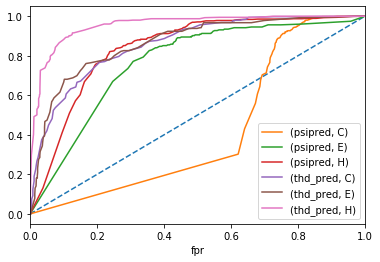

In [20]:
draw_roc_curve(pred_df)

In [47]:
# ss=get_ground_truth_from_file(pdb_list[0])['Secondary_Structure']
# "".join([reduced_ss_from_ss(s) for s in ss])
m_strat

# os.listdir(os.path.join(seg_dir,"NorAng_distance_AllofSourceData_NHLOne_NHLTwo"))



thd_id protein_id subsequence  \
0     Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      PWATAE   
1     Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      WATAEY   
2     Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      ATAEYD   
3     Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      TAEYDY   
4     Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      AEYDYD   
5     Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      EYDYDA   
6     Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      YDYDAA   
7     Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      DYDAAE   
8     Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      YDAAED   
9     Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      DAAEDN   
10    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      AAEDNE   
11    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      AEDNEL   
12    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      EDNELT   
13    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      DNELTF   
14    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      NELTFV   
15    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      ELTFVE   
16    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      LTFVEN   
17    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      TFVEND   
18    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      FVENDK   
19    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      VENDKI   
20    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      ENDKII   
21    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      NDKIIN   
22    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      DKIINI   
23    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      KIINIE   
24    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      IINIEF   
25    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      INIEFV   
26    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      NIEFVD   
27    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      IEFVDD   
28    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      EFVDDD   
29    Cor_distance_AllofSourceData_NHLOne_NHLTwo      1jo8A      FVDDDW   
...                                          ...        ...         ...   
1387  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      PDWVDV   
1388  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      DWVDVG   
1389  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      WVDVGL   
1390  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      VDVGLS   
1391  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      DVGLSG   
1392  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      VGLSGA   
1393  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      GLSGAT   
1394  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      LSGATG   
1395  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      SGATGA   
1396  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      GATGAQ   
1397  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      ATGAQR   
1398  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      TGAQRD   
1399  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      GAQRDA   
1400  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      AQRDAA   
1401  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      QRDAAE   
1402  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      RDAAET   
1403  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      DAAETH   
1404  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      AAETHD   
1405  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      AETHDV   
1406  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      ETHDVY   
1407  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      THDVYS   
1408  Cor_distance_AllofSourceData_NHLOne_NHLTwo      1gzcA      HD

In [59]:
protein_0=m_strat["protein_id"].unique()[0]

p0=m_strat[m_strat["protein_id"]==protein_0]

mstrat2=add_pred_condensed(p0,dataset_5)

pred_df=eval_test_data_min_edit(mstrat2,dataset_5)

rc_df=ROC_curve(pred_df,"H")

1jo8A


In [100]:
# import editdistance

In [ ]:
# mstrat2

# match_seq=[]
# true_edit_dist=[]

# for indexi, rowi in mstrat2.iterrows():
    
#     matchstring=rowi["subsequence"]

#     print("looking up match for "+matchstring)
    
#     node_df=seg_rows_formatted(rowi['thd_id'],rowi['file_id'],dataset_5)
    
#     seq=[]
#     for indexj, rowj in node_df.iterrows():
#         print("     "+str(indexj))
#         seq.append("".join(get_ground_truth_from_file(rowj["protein_id"])["Amino_Acid"])[rowj["start"]:rowj["stop"]+1])


#     edit_dists=[editdistance.eval(st,matchstring) for st in seq]

#     match_seq.append(seq[edit_dists.index(min(edit_dists))])
#     true_edit_dist.append(min(edit_dists))
    
# mstrat2["matched_seq"]=match_seq
# mstrat2["computed_edit_dist"]=true_edit_dist

looking up match for PWATAE
     3462
     16058
     21371
     23698
     26337
     36156
     39570
     40104
     40202
     40534
     42661
     44824
     51216
     58109
     64387
     64603
     70325
     74200
     76468
     80348
     84481
     88450
     97193
     102829
     111286
     118162
     124531
     125388
     136669
     137821
     147054
     149857
     160463
     162748
     163909
looking up match for WATAEY
     4080
     31181
     40296
     40300
     49004
     51191
     51584
     52487
     69556
     90789
     109757
     119875
     120820
     121781
     128581
     136205
     137840
     148547
     162976
     166316
     171900
looking up match for ATAEYD
     1586
     3299
     3575
     4558
     4564
     5462
     6592
     10253
     10659
     11817
     11877
     11992
     14702
     18359
     18650
     20457
     20541
     21517
     22813
     22919
     23351
     23687
     26164
     26900
     29141
     29883


     168895
looking up match for EDNELT
     11
     4445
     6455
     8452
     9203
     9509
     10795
     11677
     12303
     12420
     13305
     13442
     13721
     14634
     15190
     16233
     17557
     18295
     18668
     22910
     23878
     23896
     25093
     25898
     27737
     29486
     31375
     32174
     33623
     34002
     34882
     35951
     37284
     41468
     42940
     43448
     44365
     44551
     44894
     46581
     46862
     49593
     50676
     52255
     52962
     53005
     56340
     56402
     58979
     64810
     64848
     66200
     70144
     70188
     70766
     72489
     75265
     75298
     79548
     81126
     82716
     85096
     85987
     88081
     89100
     89661
     90595
     95706
     96015
     96587
     102348
     102498
     104164
     104354
     104610
     106685
     108007
     109878
     111198
     112428
     113872
     115780
     116118
     117027
     119275
     119537
     1

     48031
     48178
     48298
     48338
     48396
     48992
     49399
     49462
     49532
     49682
     50108
     50424
     50730
     50779
     50950
     51140
     51703
     51856
     52515
     52778
     52883
     53031
     53384
     53729
     53733
     53784
     53796
     53927
     54002
     54035
     54202
     54316
     54326
     54347
     54362
     54788
     55146
     55276
     55306
     55319
     55335
     55338
     55472
     55936
     55996
     56184
     56433
     56618
     56834
     56873
     57367
     57997
     57999
     58431
     58530
     58614
     58833
     58849
     59104
     59201
     59220
     59268
     59672
     59688
     59717
     60459
     60475
     60676
     60993
     61180
     61203
     61374
     61684
     61847
     61867
     61871
     62103
     62292
     62392
     62438
     62460
     62599
     63167
     63420
     63442
     63488
     63637
     63669
     63692
     64094
     64126

     137084
     137854
     138551
     139253
     143266
     144423
     144755
     146086
     148599
     149757
     151370
     152237
     153063
     155811
     162074
     163217
     164853
     164936
     165306
     169918
     170631
     170948
     172049
looking up match for VENDKI
     7
     8
     9
     10
     11
     13
     15
     16
     17
     18
     19
     20
     21
     26
     27
     28
     29
     30
     31
     34
     35
     36
     37
     38
     39
     40
     50
     51
     52
     53
     54
     58
     62
     63
     64
     65
     66
     67
     68
     69
     72
     73
     74
     75
     76
     77
     78
     80
     81
     82
     83
     84
     86
     87
     88
     89
     90
     91
     92
     93
     94
     99
     100
     101
     102
     104
     105
     108
     109
     110
     112
     116
     117
     118
     123
     124
     125
     126
     127
     129
     135
     136
     140
     143
     

     1583
     1586
     1587
     1588
     1589
     1590
     1591
     1594
     1595
     1597
     1598
     1599
     1600
     1601
     1602
     1603
     1606
     1608
     1609
     1611
     1612
     1617
     1618
     1621
     1622
     1628
     1629
     1634
     1636
     1649
     1650
     1653
     1654
     1655
     1658
     1659
     1666
     1673
     1679
     1680
     1681
     1682
     1683
     1684
     1685
     1686
     1687
     1688
     1689
     1690
     1693
     1694
     1695
     1696
     1697
     1698
     1700
     1702
     1703
     1706
     1709
     1710
     1713
     1714
     1715
     1716
     1717
     1718
     1721
     1722
     1723
     1724
     1725
     1726
     1727
     1728
     1729
     1730
     1731
     1732
     1737
     1738
     1739
     1740
     1741
     1742
     1743
     1744
     1745
     1749
     1750
     1751
     1752
     1755
     1756
     1757
     1758
     1759
     1760
     1761


     3134
     3136
     3137
     3138
     3139
     3140
     3141
     3142
     3143
     3144
     3145
     3146
     3147
     3148
     3149
     3153
     3159
     3163
     3164
     3173
     3174
     3180
     3183
     3189
     3190
     3191
     3192
     3194
     3195
     3196
     3197
     3198
     3201
     3202
     3203
     3204
     3205
     3206
     3207
     3208
     3209
     3210
     3211
     3212
     3214
     3215
     3217
     3218
     3219
     3220
     3221
     3222
     3223
     3224
     3225
     3229
     3231
     3232
     3233
     3234
     3235
     3236
     3237
     3238
     3264
     3265
     3268
     3269
     3276
     3277
     3278
     3279
     3280
     3281
     3282
     3283
     3285
     3286
     3287
     3288
     3289
     3290
     3291
     3293
     3294
     3296
     3297
     3298
     3299
     3300
     3301
     3302
     3303
     3304
     3305
     3306
     3307
     3308
     3309
     3310


     4747
     4748
     4750
     4754
     4755
     4757
     4758
     4759
     4760
     4761
     4762
     4764
     4769
     4770
     4771
     4772
     4773
     4774
     4775
     4776
     4777
     4778
     4782
     4783
     4784
     4785
     4786
     4787
     4792
     4793
     4795
     4798
     4799
     4800
     4806
     4807
     4808
     4809
     4813
     4814
     4815
     4816
     4817
     4818
     4827
     4828
     4829
     4830
     4834
     4835
     4836
     4837
     4839
     4842
     4843
     4844
     4847
     4848
     4849
     4852
     4856
     4857
     4858
     4859
     4860
     4866
     4867
     4868
     4873
     4875
     4876
     4881
     4882
     4887
     4888
     4899
     4903
     4907
     4908
     4918
     4919
     4920
     4924
     4927
     4928
     4930
     4931
     4932
     4934
     4936
     4937
     4944
     4946
     4947
     4948
     4949
     4955
     4956
     4957
     4958


     6423
     6424
     6425
     6426
     6430
     6431
     6432
     6433
     6434
     6435
     6437
     6438
     6439
     6440
     6441
     6446
     6447
     6448
     6449
     6451
     6452
     6453
     6454
     6455
     6456
     6460
     6461
     6462
     6463
     6464
     6467
     6469
     6470
     6471
     6475
     6477
     6478
     6479
     6480
     6481
     6482
     6487
     6488
     6490
     6493
     6494
     6495
     6496
     6497
     6498
     6499
     6501
     6502
     6503
     6504
     6505
     6506
     6507
     6508
     6509
     6510
     6512
     6513
     6514
     6515
     6517
     6525
     6528
     6529
     6532
     6537
     6538
     6542
     6543
     6548
     6552
     6554
     6555
     6557
     6558
     6559
     6560
     6561
     6565
     6566
     6569
     6570
     6571
     6573
     6575
     6576
     6577
     6578
     6579
     6580
     6582
     6584
     6586
     6588
     6589


     8111
     8114
     8119
     8120
     8123
     8127
     8128
     8129
     8136
     8137
     8138
     8139
     8141
     8142
     8145
     8152
     8153
     8154
     8157
     8161
     8162
     8163
     8164
     8167
     8169
     8171
     8172
     8179
     8181
     8185
     8186
     8189
     8191
     8192
     8193
     8194
     8195
     8196
     8197
     8200
     8201
     8202
     8204
     8205
     8206
     8207
     8208
     8209
     8210
     8211
     8212
     8213
     8221
     8222
     8223
     8224
     8225
     8229
     8231
     8238
     8240
     8241
     8250
     8260
     8261
     8262
     8266
     8267
     8273
     8279
     8280
     8281
     8282
     8283
     8284
     8285
     8286
     8288
     8290
     8306
     8308
     8310
     8316
     8322
     8323
     8330
     8340
     8346
     8347
     8357
     8358
     8359
     8362
     8364
     8367
     8368
     8374
     8375
     8383
     8384


     9849
     9850
     9854
     9856
     9857
     9866
     9868
     9870
     9871
     9872
     9873
     9875
     9876
     9878
     9879
     9880
     9885
     9887
     9888
     9889
     9890
     9891
     9892
     9905
     9906
     9918
     9920
     9921
     9924
     9925
     9926
     9927
     9929
     9930
     9931
     9932
     9933
     9934
     9935
     9936
     9937
     9938
     9939
     9940
     9944
     9947
     9948
     9949
     9950
     9952
     9953
     9954
     9963
     9964
     9965
     9966
     9967
     9968
     9969
     9970
     9971
     9972
     9973
     9974
     9975
     9976
     9977
     9979
     9980
     9981
     9982
     9987
     9988
     9989
     9990
     9991
     9997
     9998
     9999
     10000
     10001
     10002
     10003
     10004
     10005
     10006
     10008
     10014
     10015
     10016
     10017
     10025
     10026
     10027
     10028
     10029
     10030
     10033
 

     11304
     11305
     11306
     11309
     11310
     11311
     11312
     11313
     11314
     11315
     11316
     11317
     11319
     11320
     11321
     11323
     11331
     11332
     11333
     11334
     11335
     11336
     11337
     11340
     11345
     11346
     11347
     11348
     11349
     11350
     11355
     11356
     11357
     11358
     11363
     11364
     11365
     11366
     11368
     11370
     11371
     11372
     11373
     11378
     11379
     11380
     11381
     11382
     11388
     11389
     11390
     11391
     11392
     11398
     11400
     11401
     11406
     11410
     11411
     11412
     11413
     11414
     11415
     11417
     11418
     11420
     11421
     11422
     11423
     11424
     11425
     11428
     11429
     11430
     11431
     11432
     11433
     11434
     11435
     11436
     11437
     11438
     11439
     11449
     11450
     11451
     11452
     11453
     11454
     11455
     11456

     12762
     12766
     12767
     12768
     12773
     12780
     12788
     12795
     12796
     12798
     12799
     12801
     12802
     12805
     12819
     12830
     12836
     12837
     12852
     12853
     12854
     12856
     12857
     12858
     12859
     12860
     12861
     12862
     12863
     12867
     12868
     12869
     12870
     12871
     12872
     12873
     12874
     12875
     12876
     12877
     12878
     12879
     12880
     12881
     12882
     12883
     12884
     12886
     12887
     12888
     12889
     12891
     12892
     12893
     12894
     12896
     12897
     12898
     12899
     12900
     12901
     12902
     12903
     12904
     12905
     12906
     12907
     12908
     12910
     12915
     12916
     12918
     12919
     12920
     12921
     12922
     12923
     12924
     12925
     12926
     12927
     12928
     12929
     12930
     12931
     12932
     12933
     12934
     12936
     12937
     12940

     14313
     14314
     14315
     14316
     14318
     14322
     14323
     14325
     14326
     14327
     14331
     14332
     14333
     14334
     14335
     14336
     14337
     14341
     14342
     14343
     14355
     14356
     14357
     14359
     14360
     14361
     14362
     14363
     14364
     14369
     14371
     14374
     14375
     14376
     14377
     14378
     14382
     14384
     14385
     14387
     14389
     14395
     14396
     14397
     14398
     14399
     14400
     14401
     14409
     14410
     14411
     14412
     14413
     14415
     14416
     14417
     14418
     14419
     14424
     14427
     14428
     14431
     14435
     14436
     14437
     14438
     14439
     14440
     14442
     14443
     14444
     14445
     14446
     14448
     14449
     14450
     14457
     14461
     14462
     14463
     14466
     14470
     14472
     14474
     14475
     14476
     14478
     14479
     14480
     14481
     14482

     15795
     15796
     15797
     15798
     15799
     15800
     15801
     15802
     15803
     15805
     15806
     15807
     15808
     15809
     15810
     15812
     15813
     15814
     15815
     15816
     15817
     15818
     15819
     15820
     15821
     15826
     15828
     15829
     15830
     15835
     15837
     15838
     15839
     15840
     15847
     15850
     15853
     15862
     15863
     15865
     15868
     15869
     15872
     15876
     15877
     15879
     15880
     15882
     15884
     15885
     15886
     15889
     15894
     15895
     15900
     15903
     15916
     15917
     15926
     15927
     15930
     15932
     15941
     15952
     15955
     15956
     15957
     15958
     15959
     15964
     15972
     15973
     15974
     15982
     15989
     15990
     15991
     15996
     16002
     16004
     16009
     16010
     16013
     16014
     16015
     16017
     16025
     16032
     16033
     16036
     16037

     18742
     18743
     18744
     18745
     18747
     18748
     18749
     18750
     18755
     18756
     18757
     18758
     18759
     18760
     18761
     18762
     18763
     18764
     18765
     18768
     18769
     18770
     18771
     18776
     18777
     18778
     18780
     18781
     18782
     18785
     18786
     18787
     18788
     18789
     18790
     18791
     18793
     18794
     18799
     18800
     18801
     18802
     18803
     18804
     18805
     18806
     18807
     18808
     18809
     18810
     18811
     18813
     18814
     18815
     18816
     18817
     18822
     18823
     18824
     18826
     18827
     18828
     18829
     18830
     18831
     18832
     18833
     18837
     18838
     18839
     18846
     18847
     18848
     18849
     18851
     18852
     18861
     18863
     18864
     18867
     18869
     18870
     18871
     18872
     18874
     18875
     18885
     18886
     18887
     18899
     18901

     20163
     20165
     20166
     20169
     20170
     20171
     20172
     20173
     20176
     20177
     20178
     20179
     20180
     20182
     20183
     20192
     20194
     20195
     20200
     20201
     20202
     20206
     20207
     20210
     20212
     20214
     20215
     20216
     20217
     20218
     20219
     20225
     20227
     20228
     20229
     20231
     20235
     20237
     20242
     20243
     20244
     20245
     20247
     20248
     20251
     20253
     20254
     20261
     20262
     20264
     20265
     20267
     20270
     20271
     20272
     20273
     20274
     20275
     20279
     20283
     20284
     20291
     20292
     20293
     20295
     20298
     20299
     20300
     20301
     20302
     20303
     20305
     20306
     20307
     20309
     20312
     20313
     20321
     20322
     20323
     20324
     20325
     20327
     20332
     20333
     20334
     20339
     20340
     20348
     20349
     20351

     21696
     21698
     21699
     21704
     21705
     21712
     21713
     21715
     21718
     21719
     21720
     21721
     21722
     21723
     21724
     21725
     21726
     21734
     21735
     21736
     21742
     21743
     21744
     21748
     21749
     21750
     21751
     21762
     21763
     21768
     21769
     21770
     21771
     21772
     21773
     21775
     21776
     21778
     21781
     21783
     21784
     21785
     21788
     21790
     21792
     21793
     21794
     21795
     21797
     21798
     21801
     21802
     21803
     21804
     21805
     21808
     21809
     21810
     21811
     21812
     21813
     21814
     21815
     21816
     21817
     21819
     21820
     21821
     21822
     21823
     21824
     21825
     21826
     21827
     21831
     21832
     21833
     21834
     21835
     21836
     21837
     21838
     21839
     21840
     21841
     21842
     21843
     21852
     21854
     21856
     21866

     23277
     23278
     23279
     23280
     23282
     23283
     23285
     23286
     23287
     23288
     23289
     23290
     23291
     23292
     23293
     23294
     23295
     23296
     23297
     23298
     23299
     23300
     23301
     23302
     23304
     23305
     23306
     23307
     23308
     23309
     23310
     23315
     23316
     23318
     23320
     23321
     23322
     23323
     23325
     23326
     23327
     23328
     23329
     23330
     23331
     23332
     23333
     23334
     23335
     23337
     23338
     23339
     23340
     23341
     23342
     23343
     23344
     23345
     23347
     23348
     23350
     23351
     23352
     23355
     23357
     23358
     23359
     23360
     23362
     23363
     23365
     23366
     23367
     23369
     23370
     23371
     23372
     23373
     23374
     23375
     23377
     23378
     23379
     23380
     23381
     23383
     23384
     23385
     23386
     23387
     23388

     24568
     24569
     24570
     24575
     24579
     24580
     24581
     24582
     24583
     24584
     24585
     24587
     24588
     24589
     24590
     24591
     24592
     24598
     24599
     24602
     24605
     24606
     24607
     24609
     24610
     24611
     24612
     24613
     24614
     24616
     24617
     24619
     24620
     24621
     24626
     24627
     24633
     24634
     24640
     24650
     24653
     24655
     24659
     24666
     24673
     24674
     24675
     24676
     24677
     24678
     24681
     24687
     24688
     24695
     24696
     24697
     24701
     24702
     24703
     24704
     24710
     24711
     24712
     24713
     24714
     24722
     24723
     24724
     24726
     24727
     24728
     24730
     24732
     24733
     24734
     24735
     24736
     24737
     24749
     24750
     24762
     24764
     24765
     24766
     24778
     24780
     24781
     24782
     24793
     24804
     24805

     25940
     25941
     25942
     25943
     25945
     25947
     25951
     25952
     25953
     25954
     25955
     25956
     25959
     25960
     25961
     25962
     25963
     25965
     25966
     25968
     25969
     25970
     25971
     25972
     25973
     25976
     25977
     25978
     25979
     25980
     25981
     25982
     25983
     25985
     25986
     25987
     25988
     25989
     25990
     25991
     25992
     25993
     25994
     25995
     25996
     25997
     25998
     25999
     26000
     26001
     26002
     26004
     26011
     26012
     26013
     26014
     26015
     26016
     26025
     26026
     26027
     26028
     26029
     26031
     26032
     26033
     26035
     26036
     26037
     26038
     26039
     26042
     26043
     26046
     26048
     26049
     26051
     26053
     26059
     26088
     26090
     26091
     26092
     26093
     26094
     26095
     26098
     26101
     26106
     26107
     26108

     27410
     27412
     27413
     27414
     27415
     27421
     27422
     27423
     27424
     27425
     27426
     27427
     27429
     27430
     27435
     27436
     27439
     27440
     27444
     27446
     27447
     27451
     27456
     27457
     27458
     27459
     27461
     27462
     27464
     27465
     27466
     27468
     27469
     27471
     27472
     27478
     27479
     27481
     27482
     27484
     27485
     27488
     27492
     27494
     27497
     27500
     27506
     27509
     27510
     27513
     27516
     27517
     27519
     27520
     27521
     27522
     27528
     27529
     27530
     27531
     27532
     27533
     27534
     27538
     27539
     27540
     27542
     27543
     27544
     27545
     27550
     27552
     27559
     27560
     27561
     27562
     27563
     27564
     27565
     27566
     27567
     27568
     27569
     27570
     27571
     27572
     27573
     27576
     27581
     27582
     27587

     28865
     28866
     28867
     28868
     28869
     28870
     28871
     28872
     28873
     28874
     28875
     28877
     28878
     28879
     28880
     28881
     28882
     28883
     28884
     28890
     28891
     28892
     28893
     28894
     28895
     28897
     28898
     28899
     28906
     28909
     28912
     28913
     28915
     28916
     28917
     28919
     28923
     28931
     28932
     28933
     28936
     28938
     28939
     28940
     28942
     28944
     28946
     28947
     28951
     28952
     28956
     28957
     28958
     28959
     28960
     28961
     28966
     28968
     28969
     28973
     28974
     28975
     28980
     28981
     28982
     28983
     28984
     28985
     28986
     28987
     28991
     28992
     28994
     28995
     28996
     28997
     29005
     29006
     29007
     29008
     29009
     29010
     29011
     29012
     29013
     29015
     29016
     29017
     29018
     29019
     29020

     30219
     30220
     30222
     30223
     30224
     30225
     30226
     30227
     30228
     30229
     30230
     30231
     30233
     30242
     30243
     30244
     30245
     30249
     30250
     30251
     30252
     30259
     30263
     30264
     30265
     30268
     30272
     30276
     30277
     30282
     30283
     30284
     30285
     30286
     30290
     30291
     30294
     30295
     30296
     30297
     30298
     30299
     30300
     30301
     30302
     30304
     30305
     30306
     30308
     30309
     30310
     30311
     30312
     30313
     30314
     30315
     30316
     30317
     30322
     30323
     30326
     30327
     30333
     30334
     30341
     30348
     30349
     30353
     30354
     30360
     30361
     30366
     30369
     30378
     30383
     30386
     30390
     30393
     30394
     30395
     30396
     30397
     30398
     30399
     30402
     30403
     30404
     30405
     30407
     30408
     30410

     31673
     31674
     31677
     31680
     31681
     31682
     31683
     31684
     31685
     31686
     31688
     31694
     31696
     31697
     31698
     31699
     31701
     31703
     31704
     31705
     31707
     31709
     31710
     31713
     31720
     31721
     31729
     31730
     31731
     31732
     31739
     31740
     31741
     31745
     31746
     31747
     31748
     31749
     31753
     31754
     31755
     31756
     31757
     31758
     31760
     31762
     31763
     31764
     31765
     31773
     31775
     31776
     31777
     31781
     31782
     31785
     31786
     31787
     31791
     31796
     31797
     31799
     31800
     31801
     31806
     31807
     31808
     31809
     31810
     31812
     31813
     31814
     31815
     31816
     31817
     31818
     31820
     31821
     31822
     31823
     31829
     31830
     31831
     31832
     31833
     31834
     31836
     31837
     31838
     31839
     31840

     32978
     32979
     32980
     32981
     32982
     32983
     32984
     32987
     32991
     32992
     32993
     32994
     32995
     32997
     32999
     33000
     33004
     33006
     33007
     33008
     33009
     33011
     33012
     33013
     33015
     33016
     33017
     33018
     33026
     33027
     33028
     33029
     33030
     33031
     33032
     33033
     33034
     33035
     33036
     33037
     33038
     33039
     33040
     33048
     33049
     33056
     33057
     33058
     33059
     33060
     33061
     33062
     33063
     33064
     33065
     33066
     33067
     33068
     33069
     33072
     33073
     33080
     33088
     33094
     33098
     33100
     33117
     33124
     33126
     33127
     33132
     33138
     33139
     33140
     33141
     33147
     33148
     33149
     33150
     33154
     33162
     33165
     33166
     33167
     33168
     33169
     33170
     33174
     33175
     33180
     33181

     34478
     34479
     34480
     34481
     34483
     34484
     34485
     34486
     34487
     34490
     34491
     34492
     34493
     34495
     34500
     34506
     34507
     34508
     34514
     34515
     34517
     34521
     34522
     34523
     34524
     34525
     34526
     34527
     34534
     34537
     34538
     34539
     34540
     34541
     34542
     34543
     34544
     34545
     34550
     34551
     34565
     34566
     34567
     34568
     34569
     34570
     34571
     34572
     34573
     34574
     34575
     34577
     34578
     34579
     34580
     34581
     34582
     34583
     34584
     34585
     34586
     34587
     34588
     34589
     34590
     34591
     34592
     34593
     34594
     34595
     34599
     34600
     34601
     34603
     34604
     34605
     34607
     34608
     34609
     34610
     34611
     34612
     34613
     34614
     34615
     34622
     34631
     34633
     34634
     34635
     34636

     35875
     35876
     35877
     35878
     35879
     35880
     35881
     35882
     35886
     35887
     35888
     35889
     35890
     35891
     35893
     35894
     35895
     35896
     35897
     35904
     35912
     35913
     35915
     35919
     35920
     35921
     35922
     35923
     35924
     35925
     35927
     35928
     35931
     35933
     35934
     35936
     35937
     35938
     35939
     35940
     35941
     35942
     35943
     35944
     35946
     35947
     35948
     35951
     35952
     35957
     35958
     35959
     35960
     35961
     35964
     35967
     35968
     35970
     35975
     35984
     35985
     35986
     35995
     35996
     35997
     35998
     36000
     36001
     36003
     36012
     36014
     36015
     36018
     36033
     36034
     36037
     36038
     36047
     36048
     36049
     36051
     36052
     36054
     36057
     36059
     36060
     36061
     36063
     36064
     36070
     36072

     37337
     37339
     37340
     37347
     37348
     37349
     37355
     37357
     37365
     37366
     37368
     37369
     37371
     37372
     37373
     37374
     37375
     37376
     37377
     37378
     37382
     37384
     37385
     37386
     37387
     37388
     37390
     37397
     37400
     37401
     37402
     37403
     37404
     37405
     37406
     37407
     37410
     37415
     37417
     37422
     37423
     37424
     37426
     37428
     37429
     37430
     37431
     37432
     37433
     37434
     37435
     37436
     37438
     37442
     37443
     37444
     37445
     37446
     37447
     37448
     37449
     37450
     37451
     37452
     37453
     37454
     37455
     37456
     37457
     37458
     37460
     37461
     37462
     37464
     37465
     37466
     37467
     37468
     37469
     37470
     37476
     37477
     37478
     37479
     37480
     37481
     37482
     37483
     37484
     37490
     37491

     38824
     38828
     38829
     38830
     38831
     38838
     38840
     38842
     38843
     38844
     38846
     38848
     38849
     38850
     38851
     38852
     38853
     38864
     38873
     38874
     38880
     38881
     38882
     38890
     38899
     38900
     38901
     38902
     38904
     38907
     38909
     38910
     38911
     38919
     38920
     38921
     38922
     38923
     38924
     38925
     38926
     38928
     38929
     38930
     38937
     38938
     38939
     38940
     38941
     38942
     38943
     38946
     38947
     38948
     38950
     38953
     38954
     38958
     38960
     38962
     38963
     38970
     38971
     38972
     38973
     38974
     38975
     38976
     38980
     38981
     38991
     38992
     38993
     38994
     38995
     38996
     38997
     38998
     39000
     39001
     39002
     39003
     39004
     39005
     39006
     39007
     39008
     39009
     39010
     39011
     39013

     40240
     40241
     40244
     40245
     40246
     40247
     40248
     40249
     40253
     40255
     40256
     40258
     40259
     40260
     40262
     40263
     40264
     40269
     40270
     40271
     40272
     40273
     40277
     40278
     40279
     40280
     40281
     40282
     40284
     40285
     40286
     40288
     40289
     40290
     40291
     40292
     40293
     40296
     40297
     40299
     40300
     40301
     40303
     40312
     40313
     40314
     40315
     40316
     40319
     40320
     40321
     40322
     40323
     40324
     40326
     40328
     40329
     40330
     40331
     40332
     40333
     40334
     40335
     40336
     40337
     40338
     40339
     40341
     40343
     40345
     40347
     40348
     40351
     40352
     40353
     40354
     40355
     40356
     40362
     40363
     40364
     40367
     40368
     40369
     40370
     40371
     40372
     40373
     40374
     40375
     40376

     41603
     41605
     41606
     41607
     41608
     41609
     41610
     41612
     41613
     41614
     41615
     41617
     41618
     41619
     41620
     41621
     41622
     41627
     41630
     41631
     41632
     41633
     41634
     41635
     41636
     41637
     41641
     41642
     41643
     41644
     41645
     41646
     41651
     41653
     41654
     41658
     41659
     41660
     41667
     41668
     41675
     41676
     41677
     41680
     41685
     41686
     41688
     41689
     41695
     41696
     41697
     41698
     41704
     41705
     41706
     41707
     41708
     41709
     41710
     41711
     41712
     41713
     41715
     41720
     41721
     41722
     41723
     41724
     41725
     41726
     41727
     41729
     41734
     41735
     41736
     41737
     41738
     41739
     41740
     41741
     41747
     41748
     41749
     41751
     41757
     41758
     41759
     41760
     41761
     41763
     41764

     43123
     43124
     43134
     43147
     43148
     43149
     43151
     43160
     43161
     43163
     43167
     43168
     43169
     43170
     43172
     43173
     43175
     43176
     43177
     43178
     43181
     43182
     43183
     43184
     43190
     43191
     43192
     43197
     43209
     43210
     43211
     43212
     43220
     43221
     43222
     43223
     43224
     43225
     43226
     43228
     43229
     43230
     43231
     43232
     43235
     43236
     43237
     43238
     43239
     43240
     43241
     43242
     43243
     43250
     43251
     43252
     43253
     43254
     43255
     43257
     43258
     43260
     43263
     43264
     43267
     43268
     43269
     43273
     43274
     43280
     43284
     43288
     43289
     43292
     43293
     43294
     43295
     43298
     43299
     43300
     43302
     43304
     43305
     43306
     43307
     43308
     43310
     43311
     43313
     43314
     43315

     44597
     44598
     44599
     44600
     44601
     44603
     44608
     44615
     44616
     44617
     44618
     44619
     44620
     44628
     44629
     44630
     44639
     44640
     44641
     44644
     44645
     44646
     44647
     44649
     44650
     44651
     44652
     44653
     44655
     44656
     44657
     44658
     44661
     44662
     44667
     44668
     44669
     44670
     44671
     44672
     44673
     44674
     44675
     44676
     44677
     44680
     44684
     44689
     44696
     44697
     44698
     44699
     44700
     44701
     44702
     44703
     44705
     44711
     44712
     44713
     44714
     44715
     44716
     44717
     44718
     44719
     44726
     44728
     44729
     44730
     44731
     44732
     44733
     44739
     44746
     44747
     44748
     44754
     44755
     44756
     44757
     44758
     44760
     44761
     44762
     44763
     44764
     44765
     44766
     44767
     44768

     46080
     46081
     46082
     46083
     46086
     46087
     46088
     46089
     46090
     46098
     46099
     46100
     46105
     46106
     46107
     46108
     46110
     46111
     46112
     46113
     46114
     46116
     46117
     46118
     46123
     46126
     46128
     46129
     46131
     46132
     46133
     46137
     46138
     46139
     46140
     46141
     46142
     46144
     46145
     46146
     46147
     46148
     46150
     46157
     46159
     46160
     46161
     46162
     46166
     46167
     46170
     46171
     46172
     46173
     46174
     46175
     46176
     46177
     46185
     46186
     46187
     46188
     46189
     46190
     46191
     46194
     46195
     46196
     46201
     46202
     46203
     46204
     46205
     46207
     46208
     46209
     46215
     46216
     46218
     46225
     46226
     46227
     46229
     46230
     46234
     46238
     46239
     46240
     46241
     46242
     46243

     47550
     47551
     47552
     47553
     47554
     47555
     47561
     47562
     47563
     47564
     47566
     47569
     47570
     47572
     47579
     47580
     47581
     47582
     47583
     47584
     47585
     47590
     47592
     47595
     47596
     47597
     47598
     47599
     47600
     47601
     47602
     47607
     47608
     47609
     47610
     47611
     47612
     47613
     47614
     47615
     47616
     47617
     47618
     47619
     47620
     47624
     47625
     47626
     47627
     47628
     47629
     47630
     47632
     47633
     47634
     47635
     47636
     47637
     47644
     47646
     47655
     47660
     47661
     47662
     47665
     47666
     47668
     47669
     47670
     47671
     47674
     47675
     47676
     47678
     47679
     47680
     47682
     47683
     47684
     47685
     47688
     47689
     47693
     47694
     47697
     47698
     47699
     47700
     47702
     47703
     47704

     49004
     49005
     49006
     49007
     49008
     49009
     49014
     49015
     49016
     49017
     49018
     49019
     49020
     49021
     49022
     49023
     49024
     49025
     49026
     49034
     49035
     49038
     49040
     49041
     49046
     49050
     49051
     49052
     49061
     49063
     49064
     49069
     49070
     49071
     49074
     49078
     49079
     49080
     49081
     49082
     49083
     49084
     49085
     49087
     49091
     49095
     49102
     49105
     49108
     49109
     49112
     49118
     49119
     49120
     49127
     49128
     49129
     49131
     49132
     49133
     49134
     49135
     49137
     49145
     49150
     49153
     49155
     49156
     49165
     49168
     49169
     49170
     49176
     49177
     49182
     49183
     49185
     49187
     49188
     49189
     49191
     49192
     49193
     49194
     49195
     49197
     49198
     49201
     49202
     49203
     49204

     50419
     50421
     50422
     50423
     50425
     50426
     50427
     50429
     50430
     50431
     50433
     50434
     50435
     50436
     50437
     50438
     50439
     50440
     50441
     50442
     50443
     50444
     50445
     50446
     50447
     50455
     50456
     50457
     50461
     50462
     50463
     50464
     50466
     50469
     50470
     50472
     50473
     50475
     50476
     50477
     50478
     50479
     50481
     50482
     50487
     50488
     50490
     50491
     50496
     50497
     50500
     50505
     50506
     50507
     50509
     50510
     50513
     50514
     50519
     50520
     50523
     50524
     50525
     50529
     50530
     50531
     50535
     50539
     50540
     50541
     50542
     50543
     50544
     50545
     50546
     50553
     50557
     50558
     50563
     50564
     50565
     50566
     50567
     50569
     50570
     50573
     50575
     50576
     50579
     50581
     50582

     51927
     51928
     51929
     51930
     51931
     51932
     51933
     51934
     51935
     51936
     51937
     51938
     51940
     51941
     51942
     51943
     51944
     51945
     51946
     51947
     51948
     51949
     51950
     51951
     51952
     51954
     51956
     51957
     51959
     51961
     51962
     51964
     51966
     51967
     51968
     51970
     51974
     51976
     51979
     51980
     51981
     51989
     51991
     52002
     52013
     52015
     52027
     52028
     52031
     52035
     52036
     52042
     52043
     52044
     52045
     52046
     52049
     52050
     52051
     52052
     52053
     52055
     52057
     52065
     52066
     52067
     52068
     52069
     52070
     52071
     52072
     52073
     52074
     52075
     52076
     52077
     52078
     52079
     52081
     52082
     52083
     52084
     52085
     52086
     52087
     52088
     52094
     52096
     52098
     52099
     52100

     53362
     53363
     53364
     53368
     53369
     53370
     53371
     53372
     53376
     53378
     53379
     53380
     53381
     53383
     53385
     53386
     53387
     53388
     53389
     53390
     53391
     53396
     53398
     53399
     53400
     53401
     53402
     53403
     53406
     53407
     53414
     53415
     53417
     53423
     53430
     53431
     53432
     53439
     53440
     53441
     53442
     53444
     53445
     53446
     53447
     53448
     53449
     53450
     53451
     53455
     53456
     53457
     53458
     53460
     53461
     53462
     53465
     53466
     53467
     53468
     53469
     53470
     53474
     53475
     53479
     53481
     53483
     53486
     53487
     53489
     53490
     53496
     53497
     53499
     53500
     53501
     53503
     53504
     53505
     53506
     53507
     53508
     53509
     53510
     53511
     53512
     53516
     53517
     53519
     53520
     53528

     54938
     54939
     54942
     54943
     54944
     54949
     54950
     54951
     54952
     54953
     54954
     54955
     54956
     54959
     54960
     54961
     54965
     54966
     54969
     54974
     54975
     54976
     54997
     54999
     55008
     55023
     55027
     55028
     55030
     55031
     55035
     55037
     55044
     55045
     55047
     55052
     55061
     55065
     55069
     55070
     55074
     55085
     55089
     55094
     55095
     55096
     55101
     55102
     55104
     55105
     55106
     55107
     55108
     55109
     55110
     55112
     55113
     55117
     55118
     55119
     55120
     55121
     55122
     55123
     55124
     55125
     55126
     55127
     55128
     55129
     55130
     55131
     55132
     55133
     55134
     55135
     55137
     55142
     55143
     55144
     55145
     55147
     55148
     55149
     55150
     55152
     55155
     55156
     55157
     55158
     55159

     56409
     56410
     56411
     56412
     56413
     56414
     56415
     56416
     56417
     56419
     56425
     56426
     56427
     56428
     56429
     56430
     56431
     56432
     56434
     56439
     56447
     56454
     56465
     56472
     56473
     56474
     56475
     56492
     56498
     56512
     56513
     56514
     56525
     56533
     56541
     56542
     56543
     56544
     56545
     56546
     56548
     56549
     56550
     56551
     56553
     56554
     56556
     56557
     56569
     56573
     56575
     56576
     56577
     56578
     56579
     56580
     56581
     56582
     56583
     56584
     56585
     56586
     56587
     56588
     56589
     56590
     56591
     56592
     56593
     56597
     56599
     56600
     56601
     56602
     56603
     56604
     56605
     56606
     56607
     56608
     56609
     56614
     56616
     56617
     56619
     56620
     56621
     56624
     56625
     56626
     56629

     57910
     57914
     57915
     57916
     57917
     57918
     57919
     57921
     57922
     57925
     57926
     57927
     57928
     57929
     57930
     57931
     57932
     57933
     57934
     57935
     57936
     57937
     57941
     57942
     57943
     57944
     57945
     57946
     57947
     57952
     57953
     57954
     57958
     57959
     57964
     57965
     57966
     57967
     57968
     57969
     57971
     57972
     57973
     57974
     57975
     57976
     57977
     57978
     57979
     57985
     57986
     57987
     57988
     57989
     57994
     57995
     57996
     57998
     58000
     58001
     58003
     58005
     58011
     58013
     58018
     58033
     58034
     58042
     58047
     58061
     58067
     58068
     58069
     58070
     58075
     58077
     58078
     58079
     58080
     58081
     58082
     58083
     58084
     58089
     58090
     58091
     58092
     58093
     58096
     58097
     58098

     59336
     59337
     59342
     59343
     59344
     59345
     59346
     59347
     59348
     59349
     59350
     59351
     59353
     59354
     59355
     59356
     59357
     59358
     59361
     59362
     59370
     59371
     59372
     59373
     59374
     59375
     59377
     59378
     59379
     59380
     59381
     59382
     59390
     59391
     59392
     59396
     59397
     59398
     59399
     59400
     59401
     59402
     59403
     59405
     59406
     59407
     59409
     59411
     59413
     59414
     59415
     59416
     59417
     59418
     59419
     59420
     59421
     59422
     59423
     59424
     59425
     59426
     59427
     59428
     59434
     59436
     59437
     59438
     59439
     59440
     59441
     59442
     59447
     59448
     59450
     59451
     59452
     59461
     59462
     59463
     59464
     59465
     59466
     59467
     59471
     59472
     59474
     59475
     59476
     59477
     59478

     60860
     60861
     60862
     60863
     60871
     60872
     60877
     60878
     60879
     60880
     60881
     60884
     60885
     60886
     60887
     60888
     60889
     60890
     60891
     60892
     60893
     60894
     60896
     60897
     60898
     60899
     60900
     60901
     60902
     60903
     60904
     60905
     60906
     60907
     60908
     60909
     60911
     60913
     60914
     60915
     60916
     60918
     60924
     60935
     60940
     60943
     60944
     60949
     60950
     60951
     60959
     60968
     60977
     60978
     60979
     60980
     60981
     60982
     60983
     60984
     60988
     60989
     60991
     60992
     60994
     60995
     60996
     60997
     60998
     60999
     61001
     61002
     61003
     61004
     61005
     61006
     61007
     61011
     61014
     61015
     61016
     61017
     61024
     61026
     61027
     61028
     61029
     61030
     61036
     61037
     61039

     62462
     62463
     62464
     62465
     62468
     62469
     62470
     62473
     62474
     62475
     62476
     62505
     62514
     62515
     62516
     62517
     62518
     62519
     62520
     62521
     62522
     62523
     62524
     62525
     62526
     62527
     62528
     62529
     62530
     62531
     62532
     62533
     62534
     62536
     62537
     62538
     62539
     62540
     62541
     62542
     62543
     62544
     62545
     62546
     62549
     62550
     62551
     62552
     62553
     62554
     62557
     62558
     62559
     62560
     62561
     62562
     62563
     62564
     62565
     62573
     62582
     62592
     62594
     62595
     62596
     62597
     62598
     62600
     62601
     62602
     62603
     62604
     62610
     62611
     62612
     62613
     62614
     62615
     62616
     62617
     62618
     62620
     62622
     62623
     62629
     62632
     62633
     62638
     62641
     62649
     62650

     64158
     64159
     64166
     64168
     64170
     64171
     64172
     64173
     64174
     64175
     64176
     64179
     64181
     64182
     64183
     64184
     64185
     64186
     64190
     64192
     64194
     64195
     64196
     64198
     64199
     64200
     64201
     64204
     64205
     64206
     64207
     64208
     64210
     64211
     64214
     64217
     64222
     64223
     64224
     64225
     64226
     64227
     64228
     64233
     64251
     64252
     64253
     64254
     64256
     64259
     64262
     64263
     64265
     64266
     64268
     64278
     64288
     64289
     64293
     64299
     64300
     64306
     64307
     64308
     64309
     64316
     64319
     64320
     64321
     64322
     64323
     64331
     64332
     64333
     64334
     64335
     64336
     64339
     64347
     64348
     64349
     64350
     64351
     64352
     64353
     64358
     64362
     64363
     64364
     64365
     64366

     65608
     65609
     65610
     65611
     65612
     65614
     65615
     65616
     65617
     65618
     65621
     65625
     65626
     65628
     65653
     65654
     65655
     65674
     65687
     65698
     65699
     65701
     65702
     65703
     65704
     65705
     65706
     65707
     65708
     65709
     65710
     65719
     65720
     65721
     65722
     65724
     65725
     65726
     65727
     65728
     65736
     65738
     65739
     65740
     65741
     65742
     65747
     65748
     65754
     65755
     65760
     65772
     65778
     65779
     65787
     65795
     65796
     65798
     65799
     65800
     65801
     65802
     65803
     65804
     65805
     65807
     65808
     65809
     65810
     65811
     65812
     65813
     65814
     65818
     65819
     65820
     65821
     65822
     65823
     65825
     65826
     65827
     65828
     65829
     65830
     65833
     65834
     65835
     65836
     65837
     65838

     67162
     67163
     67164
     67167
     67168
     67169
     67170
     67171
     67172
     67174
     67175
     67176
     67177
     67178
     67179
     67180
     67181
     67182
     67184
     67186
     67187
     67188
     67189
     67190
     67191
     67193
     67194
     67197
     67198
     67199
     67200
     67201
     67202
     67203
     67204
     67205
     67207
     67208
     67209
     67211
     67212
     67213
     67215
     67216
     67217
     67218
     67219
     67221
     67222
     67224
     67225
     67226
     67227
     67228
     67229
     67230
     67231
     67232
     67233
     67234
     67235
     67236
     67237
     67239
     67240
     67241
     67242
     67243
     67244
     67245
     67246
     67247
     67248
     67249
     67250
     67251
     67255
     67256
     67257
     67258
     67259
     67260
     67261
     67262
     67264
     67265
     67266
     67267
     67268
     67270
     67271

     68464
     68465
     68467
     68468
     68471
     68472
     68473
     68475
     68476
     68477
     68478
     68479
     68480
     68481
     68482
     68483
     68484
     68485
     68486
     68487
     68488
     68489
     68490
     68491
     68492
     68493
     68494
     68496
     68497
     68498
     68503
     68508
     68512
     68515
     68516
     68525
     68526
     68527
     68528
     68529
     68530
     68531
     68532
     68533
     68534
     68535
     68536
     68537
     68538
     68539
     68540
     68541
     68542
     68543
     68544
     68545
     68546
     68547
     68548
     68550
     68551
     68552
     68553
     68555
     68556
     68557
     68562
     68563
     68564
     68565
     68566
     68568
     68569
     68570
     68571
     68572
     68573
     68574
     68575
     68576
     68578
     68579
     68580
     68582
     68583
     68584
     68585
     68586
     68587
     68588
     68589

     69911
     69916
     69923
     69924
     69925
     69927
     69928
     69930
     69931
     69932
     69933
     69934
     69935
     69937
     69938
     69939
     69941
     69942
     69943
     69945
     69946
     69947
     69948
     69949
     69951
     69952
     69953
     69954
     69955
     69956
     69958
     69960
     69966
     69967
     69968
     69969
     69970
     69971
     69973
     69974
     69975
     69977
     69978
     69979
     69980
     69981
     69982
     69983
     69984
     69985
     69986
     69987
     69988
     69989
     69990
     69995
     69996
     69998
     69999
     70000
     70001
     70002
     70004
     70005
     70006
     70013
     70014
     70015
     70020
     70021
     70022
     70023
     70028
     70030
     70031
     70036
     70037
     70038
     70039
     70046
     70048
     70050
     70054
     70055
     70057
     70059
     70060
     70061
     70062
     70063
     70072

     71291
     71292
     71294
     71295
     71296
     71299
     71301
     71302
     71307
     71309
     71315
     71316
     71317
     71318
     71319
     71320
     71322
     71323
     71324
     71325
     71326
     71327
     71329
     71330
     71331
     71332
     71333
     71334
     71336
     71337
     71338
     71339
     71340
     71341
     71342
     71343
     71346
     71347
     71348
     71349
     71351
     71352
     71355
     71362
     71363
     71364
     71365
     71367
     71368
     71370
     71373
     71377
     71380
     71381
     71382
     71383
     71384
     71385
     71386
     71388
     71389
     71394
     71396
     71404
     71405
     71407
     71409
     71410
     71411
     71412
     71413
     71415
     71416
     71417
     71423
     71425
     71428
     71429
     71433
     71435
     71436
     71444
     71445
     71446
     71447
     71448
     71449
     71458
     71459
     71460
     71464

     72799
     72800
     72801
     72802
     72803
     72804
     72811
     72812
     72813
     72814
     72815
     72816
     72817
     72818
     72820
     72823
     72824
     72825
     72827
     72828
     72829
     72830
     72831
     72832
     72833
     72839
     72840
     72841
     72842
     72843
     72844
     72845
     72846
     72847
     72848
     72849
     72850
     72851
     72852
     72853
     72854
     72857
     72859
     72861
     72862
     72863
     72864
     72865
     72866
     72867
     72872
     72873
     72874
     72875
     72876
     72877
     72883
     72885
     72886
     72888
     72889
     72890
     72899
     72900
     72907
     72908
     72909
     72918
     72919
     72921
     72922
     72928
     72933
     72934
     72935
     72942
     72943
     72944
     72945
     72946
     72949
     72952
     72953
     72961
     72962
     72963
     72964
     72966
     72975
     72976
     72977

     74278
     74283
     74284
     74286
     74292
     74293
     74294
     74295
     74299
     74306
     74307
     74315
     74343
     74347
     74349
     74358
     74364
     74368
     74372
     74378
     74379
     74380
     74381
     74387
     74388
     74395
     74396
     74398
     74399
     74400
     74401
     74403
     74406
     74408
     74409
     74411
     74412
     74413
     74414
     74415
     74416
     74417
     74418
     74421
     74422
     74423
     74424
     74428
     74429
     74430
     74431
     74432
     74433
     74434
     74435
     74436
     74437
     74439
     74440
     74441
     74442
     74443
     74444
     74457
     74467
     74477
     74478
     74479
     74481
     74482
     74484
     74485
     74486
     74494
     74495
     74502
     74512
     74525
     74526
     74532
     74536
     74537
     74538
     74547
     74549
     74550
     74554
     74557
     74558
     74567
     74575

     75914
     75917
     75920
     75921
     75922
     75923
     75925
     75926
     75927
     75933
     75934
     75935
     75936
     75937
     75938
     75940
     75948
     75949
     75959
     75960
     75961
     75962
     75963
     75965
     75966
     75967
     75971
     75972
     75974
     75976
     75977
     75978
     75979
     75980
     75981
     75988
     75989
     75990
     75991
     75992
     75993
     75994
     75995
     75996
     75998
     75999
     76000
     76001
     76002
     76003
     76004
     76005
     76006
     76007
     76008
     76010
     76011
     76012
     76020
     76021
     76027
     76029
     76030
     76031
     76032
     76033
     76035
     76037
     76039
     76043
     76044
     76045
     76049
     76050
     76052
     76068
     76069
     76080
     76083
     76085
     76087
     76088
     76089
     76090
     76091
     76092
     76097
     76098
     76099
     76102
     76105

     77344
     77345
     77346
     77348
     77349
     77351
     77352
     77356
     77359
     77360
     77361
     77362
     77363
     77365
     77366
     77367
     77368
     77369
     77370
     77371
     77372
     77374
     77375
     77376
     77377
     77378
     77379
     77382
     77383
     77384
     77386
     77389
     77390
     77391
     77405
     77406
     77407
     77408
     77409
     77411
     77412
     77414
     77415
     77416
     77419
     77422
     77423
     77424
     77426
     77427
     77428
     77429
     77430
     77432
     77433
     77434
     77435
     77436
     77437
     77438
     77439
     77441
     77442
     77444
     77445
     77446
     77447
     77449
     77450
     77451
     77452
     77455
     77457
     77458
     77459
     77461
     77462
     77463
     77464
     77465
     77466
     77467
     77468
     77469
     77470
     77471
     77472
     77473
     77474
     77475
     77478

     78792
     78793
     78798
     78799
     78800
     78801
     78802
     78803
     78808
     78809
     78810
     78817
     78822
     78823
     78824
     78825
     78831
     78832
     78833
     78834
     78836
     78843
     78844
     78848
     78849
     78850
     78851
     78854
     78855
     78856
     78858
     78859
     78860
     78861
     78862
     78870
     78871
     78872
     78873
     78874
     78876
     78877
     78878
     78883
     78884
     78886
     78887
     78888
     78891
     78896
     78899
     78900
     78901
     78902
     78903
     78904
     78911
     78912
     78913
     78914
     78916
     78917
     78918
     78919
     78920
     78921
     78922
     78923
     78924
     78926
     78928
     78929
     78930
     78931
     78932
     78933
     78934
     78935
     78936
     78937
     78939
     78941
     78942
     78944
     78945
     78948
     78949
     78950
     78951
     78953
     78954

     80429
     80434
     80435
     80436
     80437
     80438
     80440
     80441
     80442
     80445
     80446
     80451
     80456
     80457
     80458
     80465
     80472
     80479
     80480
     80481
     80485
     80486
     80491
     80500
     80507
     80512
     80517
     80518
     80520
     80521
     80528
     80532
     80533
     80534
     80552
     80553
     80554
     80555
     80557
     80559
     80560
     80561
     80562
     80564
     80565
     80566
     80568
     80569
     80570
     80571
     80572
     80573
     80574
     80583
     80595
     80596
     80603
     80604
     80605
     80606
     80607
     80608
     80609
     80610
     80611
     80613
     80615
     80616
     80617
     80618
     80619
     80620
     80621
     80622
     80626
     80627
     80631
     80632
     80638
     80639
     80645
     80647
     80648
     80649
     80650
     80654
     80655
     80656
     80657
     80658
     80659

     81778
     81779
     81780
     81781
     81782
     81783
     81784
     81785
     81788
     81789
     81796
     81797
     81798
     81799
     81804
     81810
     81811
     81812
     81829
     81830
     81831
     81832
     81836
     81838
     81839
     81841
     81842
     81843
     81844
     81847
     81848
     81849
     81852
     81854
     81856
     81857
     81858
     81859
     81860
     81861
     81862
     81866
     81867
     81868
     81869
     81870
     81871
     81872
     81873
     81874
     81877
     81879
     81880
     81882
     81883
     81884
     81887
     81888
     81889
     81890
     81892
     81895
     81897
     81900
     81901
     81902
     81903
     81904
     81905
     81906
     81907
     81910
     81914
     81915
     81916
     81917
     81918
     81919
     81920
     81922
     81930
     81931
     81933
     81941
     81942
     81943
     81945
     81946
     81950
     81958
     81959

     83235
     83242
     83243
     83244
     83245
     83246
     83251
     83252
     83259
     83260
     83261
     83262
     83269
     83270
     83271
     83272
     83273
     83274
     83275
     83276
     83282
     83292
     83293
     83294
     83295
     83296
     83299
     83302
     83303
     83305
     83308
     83309
     83311
     83317
     83318
     83319
     83322
     83331
     83333
     83334
     83347
     83350
     83355
     83360
     83361
     83362
     83363
     83364
     83370
     83371
     83372
     83377
     83378
     83379
     83380
     83381
     83386
     83387
     83388
     83393
     83396
     83397
     83400
     83405
     83406
     83409
     83415
     83417
     83418
     83419
     83420
     83423
     83426
     83427
     83428
     83429
     83432
     83434
     83435
     83438
     83440
     83441
     83442
     83443
     83444
     83445
     83452
     83453
     83454
     83455
     83456

     84928
     84930
     84931
     84932
     84934
     84935
     84936
     84937
     84938
     84939
     84941
     84942
     84943
     84944
     84945
     84946
     84947
     84948
     84950
     84951
     84952
     84953
     84959
     84960
     84961
     84963
     84964
     84965
     84966
     84967
     84968
     84969
     84970
     84971
     84972
     84973
     84974
     84975
     84976
     84977
     84978
     84979
     84980
     84984
     84986
     84987
     84990
     84991
     84992
     84993
     84994
     84995
     84997
     84998
     85000
     85001
     85002
     85003
     85005
     85007
     85008
     85009
     85010
     85013
     85015
     85020
     85022
     85023
     85034
     85039
     85040
     85044
     85046
     85047
     85048
     85051
     85053
     85054
     85056
     85057
     85058
     85059
     85060
     85061
     85062
     85066
     85067
     85068
     85071
     85073
     85075

     86285
     86287
     86291
     86292
     86293
     86294
     86295
     86296
     86297
     86298
     86299
     86301
     86302
     86303
     86305
     86306
     86309
     86312
     86313
     86314
     86315
     86316
     86318
     86319
     86320
     86324
     86325
     86326
     86327
     86330
     86331
     86332
     86333
     86334
     86335
     86336
     86337
     86347
     86348
     86349
     86352
     86353
     86355
     86356
     86359
     86360
     86361
     86362
     86364
     86366
     86367
     86368
     86371
     86373
     86374
     86375
     86376
     86383
     86388
     86392
     86393
     86398
     86406
     86407
     86411
     86412
     86413
     86414
     86415
     86416
     86417
     86418
     86420
     86421
     86423
     86424
     86425
     86426
     86427
     86430
     86431
     86432
     86433
     86434
     86435
     86436
     86437
     86438
     86439
     86441
     86442

     87698
     87699
     87700
     87702
     87703
     87707
     87708
     87709
     87710
     87711
     87712
     87714
     87715
     87716
     87717
     87721
     87723
     87724
     87725
     87727
     87729
     87736
     87744
     87745
     87747
     87748
     87749
     87750
     87751
     87757
     87758
     87763
     87764
     87765
     87766
     87767
     87768
     87769
     87770
     87771
     87777
     87778
     87783
     87784
     87785
     87786
     87787
     87788
     87789
     87790
     87791
     87797
     87798
     87803
     87805
     87806
     87807
     87808
     87809
     87810
     87816
     87820
     87822
     87826
     87827
     87828
     87830
     87832
     87834
     87838
     87839
     87840
     87841
     87842
     87843
     87844
     87845
     87848
     87849
     87850
     87851
     87852
     87858
     87859
     87860
     87861
     87862
     87863
     87864
     87865
     87866

     89368
     89370
     89371
     89372
     89373
     89374
     89375
     89378
     89379
     89382
     89383
     89384
     89385
     89386
     89387
     89388
     89389
     89391
     89392
     89393
     89394
     89396
     89397
     89399
     89401
     89402
     89403
     89404
     89405
     89407
     89410
     89411
     89413
     89417
     89418
     89420
     89421
     89422
     89423
     89424
     89425
     89426
     89427
     89429
     89430
     89431
     89432
     89433
     89435
     89436
     89444
     89445
     89446
     89451
     89452
     89453
     89454
     89455
     89462
     89466
     89471
     89472
     89478
     89479
     89484
     89485
     89501
     89511
     89519
     89520
     89524
     89534
     89536
     89540
     89541
     89542
     89545
     89546
     89547
     89548
     89549
     89556
     89557
     89562
     89563
     89565
     89566
     89567
     89577
     89578
     89579

     90857
     90858
     90860
     90862
     90863
     90866
     90867
     90868
     90874
     90875
     90883
     90884
     90885
     90886
     90891
     90893
     90897
     90898
     90903
     90904
     90910
     90912
     90913
     90915
     90916
     90922
     90923
     90927
     90929
     90930
     90935
     90936
     90946
     90947
     90952
     90953
     90963
     90965
     90979
     90983
     90984
     90987
     90989
     90990
     90991
     90995
     90996
     90997
     91001
     91077
     91078
     91080
     91081
     91083
     91084
     91088
     91094
     91095
     91096
     91097
     91098
     91099
     91104
     91105
     91106
     91107
     91110
     91111
     91113
     91114
     91115
     91117
     91118
     91119
     91120
     91121
     91122
     91123
     91125
     91126
     91127
     91135
     91136
     91137
     91138
     91139
     91140
     91141
     91142
     91143
     91144

     92334
     92337
     92341
     92342
     92346
     92347
     92348
     92349
     92352
     92355
     92356
     92357
     92358
     92361
     92363
     92365
     92366
     92374
     92375
     92378
     92379
     92380
     92381
     92385
     92386
     92387
     92388
     92389
     92390
     92392
     92394
     92395
     92396
     92398
     92399
     92400
     92401
     92402
     92403
     92404
     92406
     92407
     92408
     92409
     92410
     92411
     92413
     92414
     92415
     92416
     92417
     92418
     92421
     92422
     92424
     92425
     92426
     92427
     92428
     92429
     92430
     92431
     92432
     92433
     92434
     92435
     92436
     92437
     92438
     92439
     92440
     92441
     92442
     92444
     92448
     92449
     92457
     92464
     92466
     92467
     92468
     92473
     92474
     92475
     92478
     92479
     92481
     92482
     92483
     92484
     92485

     93799
     93800
     93801
     93802
     93805
     93807
     93810
     93816
     93817
     93819
     93820
     93822
     93823
     93824
     93826
     93827
     93828
     93830
     93831
     93832
     93833
     93834
     93835
     93836
     93837
     93838
     93839
     93840
     93841
     93843
     93844
     93845
     93846
     93847
     93848
     93849
     93850
     93851
     93852
     93853
     93854
     93855
     93856
     93857
     93858
     93859
     93860
     93861
     93863
     93864
     93865
     93866
     93867
     93868
     93869
     93870
     93871
     93873
     93874
     93875
     93876
     93877
     93878
     93880
     93881
     93882
     93888
     93889
     93891
     93892
     93893
     93894
     93895
     93896
     93897
     93898
     93899
     93900
     93901
     93902
     93904
     93905
     93925
     93926
     93953
     93954
     93955
     93956
     93961
     93962
     93963

     95268
     95269
     95270
     95271
     95272
     95273
     95274
     95275
     95277
     95279
     95280
     95283
     95286
     95287
     95288
     95289
     95296
     95297
     95298
     95299
     95300
     95301
     95303
     95304
     95305
     95306
     95307
     95309
     95310
     95312
     95313
     95314
     95315
     95316
     95317
     95318
     95319
     95321
     95322
     95323
     95324
     95325
     95326
     95327
     95328
     95329
     95330
     95331
     95332
     95333
     95334
     95335
     95336
     95337
     95338
     95339
     95340
     95341
     95354
     95362
     95363
     95365
     95368
     95379
     95381
     95387
     95395
     95402
     95403
     95409
     95412
     95413
     95414
     95418
     95427
     95428
     95429
     95431
     95432
     95433
     95434
     95435
     95436
     95437
     95438
     95439
     95442
     95444
     95445
     95448
     95450

     96781
     96783
     96784
     96785
     96786
     96788
     96798
     96799
     96800
     96802
     96803
     96804
     96805
     96806
     96807
     96808
     96809
     96810
     96813
     96814
     96815
     96816
     96817
     96818
     96820
     96821
     96823
     96824
     96825
     96826
     96828
     96829
     96831
     96832
     96833
     96834
     96835
     96839
     96840
     96841
     96842
     96843
     96844
     96845
     96846
     96847
     96848
     96849
     96851
     96852
     96854
     96855
     96856
     96857
     96858
     96861
     96862
     96863
     96864
     96865
     96866
     96867
     96868
     96869
     96870
     96871
     96874
     96875
     96876
     96877
     96878
     96879
     96880
     96884
     96885
     96887
     96888
     96889
     96890
     96891
     96892
     96893
     96894
     96895
     96897
     96898
     96899
     96900
     96901
     96903
     96905

     98225
     98234
     98235
     98240
     98241
     98245
     98246
     98247
     98250
     98251
     98252
     98257
     98258
     98259
     98263
     98271
     98272
     98273
     98274
     98276
     98277
     98278
     98279
     98280
     98281
     98284
     98285
     98286
     98287
     98288
     98289
     98291
     98292
     98293
     98294
     98295
     98296
     98297
     98298
     98299
     98300
     98301
     98303
     98304
     98305
     98306
     98307
     98309
     98310
     98316
     98317
     98318
     98319
     98320
     98323
     98326
     98329
     98332
     98335
     98336
     98337
     98338
     98339
     98341
     98342
     98343
     98344
     98345
     98347
     98348
     98349
     98350
     98351
     98352
     98353
     98354
     98355
     98356
     98357
     98358
     98359
     98360
     98361
     98362
     98364
     98365
     98366
     98367
     98368
     98369
     98370

     99569
     99570
     99571
     99572
     99573
     99581
     99582
     99591
     99592
     99593
     99594
     99598
     99603
     99605
     99606
     99613
     99618
     99624
     99631
     99638
     99650
     99651
     99652
     99653
     99654
     99655
     99656
     99657
     99658
     99659
     99660
     99661
     99662
     99663
     99664
     99673
     99674
     99675
     99676
     99679
     99680
     99681
     99682
     99686
     99687
     99688
     99691
     99694
     99695
     99697
     99703
     99705
     99706
     99707
     99712
     99713
     99714
     99717
     99718
     99724
     99726
     99727
     99728
     99730
     99731
     99732
     99733
     99734
     99735
     99736
     99740
     99741
     99742
     99743
     99744
     99745
     99748
     99750
     99753
     99754
     99755
     99756
     99757
     99758
     99759
     99760
     99761
     99762
     99763
     99764
     99765

     101022
     101023
     101024
     101025
     101026
     101027
     101028
     101030
     101036
     101039
     101040
     101041
     101044
     101045
     101046
     101047
     101050
     101054
     101058
     101059
     101060
     101061
     101062
     101063
     101065
     101066
     101068
     101069
     101070
     101071
     101076
     101078
     101079
     101080
     101081
     101082
     101083
     101084
     101085
     101086
     101087
     101088
     101092
     101093
     101095
     101096
     101097
     101098
     101100
     101101
     101102
     101103
     101107
     101108
     101109
     101110
     101111
     101112
     101113
     101114
     101115
     101116
     101118
     101120
     101121
     101122
     101123
     101133
     101135
     101140
     101144
     101154
     101155
     101164
     101167
     101168
     101169
     101171
     101183
     101184
     101186
     101190
     101191
    

     102352
     102353
     102355
     102356
     102357
     102358
     102360
     102361
     102362
     102363
     102364
     102367
     102368
     102370
     102371
     102372
     102374
     102375
     102376
     102377
     102378
     102379
     102380
     102381
     102383
     102384
     102385
     102386
     102387
     102388
     102390
     102391
     102393
     102394
     102395
     102396
     102397
     102398
     102399
     102400
     102401
     102403
     102404
     102407
     102408
     102409
     102410
     102411
     102412
     102413
     102417
     102418
     102419
     102423
     102424
     102425
     102426
     102427
     102430
     102432
     102433
     102434
     102439
     102440
     102446
     102449
     102451
     102452
     102456
     102457
     102458
     102459
     102460
     102461
     102463
     102465
     102466
     102467
     102469
     102470
     102471
     102472
     102473
    

     103805
     103806
     103807
     103810
     103811
     103812
     103813
     103814
     103816
     103817
     103818
     103822
     103827
     103828
     103829
     103836
     103843
     103844
     103845
     103846
     103847
     103848
     103850
     103853
     103854
     103855
     103859
     103860
     103861
     103865
     103866
     103867
     103869
     103873
     103877
     103880
     103883
     103884
     103885
     103886
     103888
     103890
     103891
     103896
     103897
     103898
     103899
     103903
     103905
     103909
     103912
     103915
     103916
     103917
     103918
     103919
     103920
     103921
     103922
     103923
     103924
     103925
     103926
     103930
     103932
     103934
     103937
     103939
     103940
     103953
     103954
     103955
     103959
     103962
     103963
     103964
     103968
     103969
     103970
     103971
     103972
     103973
     103974
    

     105160
     105161
     105162
     105164
     105172
     105173
     105175
     105178
     105179
     105180
     105181
     105185
     105188
     105189
     105193
     105199
     105200
     105201
     105202
     105206
     105207
     105208
     105209
     105210
     105217
     105219
     105220
     105223
     105224
     105225
     105226
     105228
     105231
     105232
     105233
     105236
     105241
     105243
     105244
     105245
     105246
     105247
     105250
     105254
     105255
     105256
     105257
     105259
     105263
     105264
     105268
     105269
     105270
     105272
     105273
     105276
     105279
     105280
     105282
     105283
     105285
     105289
     105290
     105306
     105307
     105308
     105309
     105314
     105319
     105323
     105324
     105325
     105326
     105330
     105331
     105332
     105333
     105335
     105337
     105339
     105341
     105348
     105349
    

     106689
     106690
     106691
     106693
     106694
     106695
     106696
     106697
     106698
     106699
     106700
     106701
     106702
     106703
     106704
     106705
     106709
     106714
     106716
     106717
     106718
     106719
     106720
     106721
     106722
     106723
     106724
     106725
     106728
     106729
     106730
     106731
     106732
     106733
     106734
     106735
     106736
     106737
     106738
     106739
     106740
     106741
     106742
     106743
     106744
     106746
     106748
     106749
     106751
     106752
     106753
     106754
     106755
     106758
     106759
     106760
     106761
     106767
     106776
     106777
     106789
     106790
     106791
     106795
     106796
     106797
     106798
     106799
     106800
     106801
     106802
     106805
     106806
     106807
     106808
     106816
     106828
     106834
     106836
     106839
     106843
     106861
     106862
    

     108107
     108109
     108110
     108112
     108114
     108115
     108117
     108118
     108119
     108120
     108121
     108123
     108124
     108125
     108129
     108130
     108131
     108140
     108141
     108149
     108150
     108153
     108178
     108179
     108180
     108181
     108182
     108185
     108186
     108187
     108188
     108189
     108192
     108195
     108197
     108198
     108199
     108200
     108201
     108202
     108203
     108204
     108205
     108207
     108208
     108209
     108210
     108212
     108213
     108214
     108215
     108216
     108224
     108225
     108226
     108227
     108228
     108229
     108232
     108235
     108236
     108239
     108241
     108242
     108243
     108244
     108245
     108246
     108247
     108248
     108249
     108250
     108251
     108252
     108253
     108254
     108255
     108256
     108257
     108258
     108259
     108260
     108261
    

     109319
     109320
     109321
     109322
     109323
     109324
     109325
     109326
     109327
     109330
     109331
     109332
     109333
     109334
     109335
     109336
     109337
     109338
     109339
     109340
     109354
     109356
     109358
     109359
     109365
     109366
     109367
     109368
     109369
     109376
     109377
     109379
     109380
     109381
     109382
     109383
     109384
     109386
     109388
     109392
     109393
     109398
     109399
     109404
     109405
     109406
     109409
     109410
     109411
     109415
     109416
     109417
     109428
     109429
     109432
     109433
     109434
     109437
     109438
     109439
     109448
     109449
     109450
     109455
     109456
     109458
     109459
     109464
     109477
     109481
     109482
     109485
     109487
     109488
     109492
     109505
     109509
     109516
     109518
     109519
     109521
     109530
     109537
    

     110717
     110718
     110720
     110722
     110723
     110724
     110725
     110726
     110727
     110728
     110729
     110731
     110732
     110733
     110741
     110742
     110755
     110767
     110771
     110772
     110773
     110787
     110788
     110789
     110790
     110791
     110792
     110793
     110802
     110803
     110821
     110823
     110825
     110826
     110828
     110829
     110830
     110831
     110832
     110833
     110845
     110851
     110852
     110859
     110860
     110873
     110876
     110884
     110889
     110892
     110893
     110894
     110896
     110897
     110898
     110900
     110901
     110902
     110903
     110904
     110905
     110906
     110909
     110910
     110911
     110912
     110913
     110914
     110917
     110919
     110920
     110921
     110922
     110924
     110925
     110927
     110929
     110931
     110932
     110934
     110935
     110936
     110937
    

     112250
     112251
     112252
     112254
     112255
     112256
     112257
     112263
     112264
     112265
     112274
     112275
     112276
     112278
     112284
     112285
     112289
     112290
     112291
     112292
     112293
     112297
     112298
     112303
     112304
     112305
     112306
     112308
     112310
     112311
     112312
     112313
     112315
     112316
     112318
     112319
     112320
     112323
     112324
     112325
     112327
     112328
     112330
     112331
     112332
     112333
     112334
     112335
     112336
     112337
     112338
     112339
     112340
     112341
     112342
     112343
     112345
     112346
     112348
     112349
     112350
     112352
     112355
     112356
     112357
     112358
     112359
     112360
     112361
     112364
     112365
     112367
     112368
     112369
     112370
     112371
     112372
     112374
     112375
     112376
     112377
     112378
     112379
    

     113471
     113472
     113473
     113475
     113479
     113480
     113481
     113482
     113483
     113485
     113486
     113487
     113488
     113489
     113490
     113494
     113495
     113496
     113497
     113498
     113499
     113500
     113501
     113502
     113504
     113508
     113509
     113510
     113511
     113512
     113514
     113515
     113516
     113520
     113522
     113523
     113524
     113528
     113529
     113530
     113531
     113532
     113535
     113536
     113537
     113538
     113539
     113540
     113541
     113542
     113545
     113546
     113547
     113548
     113549
     113550
     113551
     113552
     113553
     113554
     113559
     113560
     113561
     113562
     113568
     113569
     113570
     113571
     113574
     113575
     113576
     113577
     113578
     113580
     113581
     113582
     113583
     113584
     113585
     113586
     113587
     113588
     113589
    

     114781
     114783
     114784
     114785
     114786
     114787
     114788
     114790
     114791
     114795
     114796
     114797
     114799
     114800
     114801
     114803
     114809
     114810
     114811
     114812
     114813
     114815
     114816
     114818
     114819
     114827
     114828
     114829
     114830
     114831
     114832
     114833
     114834
     114835
     114837
     114838
     114840
     114847
     114850
     114851
     114852
     114859
     114866
     114867
     114868
     114869
     114871
     114872
     114873
     114874
     114876
     114877
     114878
     114879
     114883
     114887
     114888
     114890
     114891
     114892
     114893
     114895
     114896
     114899
     114901
     114908
     114909
     114910
     114911
     114912
     114913
     114914
     114915
     114917
     114918
     114921
     114922
     114923
     114924
     114929
     114930
     114931
     114932
    

     116113
     116114
     116115
     116116
     116117
     116118
     116119
     116120
     116126
     116128
     116133
     116134
     116135
     116136
     116137
     116139
     116140
     116142
     116143
     116146
     116147
     116148
     116151
     116156
     116157
     116158
     116183
     116184
     116201
     116203
     116204
     116205
     116208
     116209
     116210
     116211
     116212
     116213
     116222
     116223
     116224
     116225
     116226
     116227
     116228
     116234
     116235
     116237
     116238
     116240
     116241
     116242
     116243
     116245
     116247
     116248
     116249
     116250
     116251
     116254
     116255
     116256
     116260
     116264
     116265
     116266
     116272
     116273
     116274
     116276
     116277
     116280
     116281
     116284
     116285
     116286
     116289
     116290
     116292
     116293
     116294
     116295
     116296
    

     117381
     117382
     117383
     117384
     117385
     117386
     117387
     117390
     117391
     117392
     117393
     117394
     117399
     117400
     117408
     117409
     117417
     117418
     117419
     117424
     117432
     117437
     117438
     117444
     117446
     117454
     117455
     117456
     117457
     117458
     117459
     117460
     117467
     117469
     117470
     117471
     117472
     117473
     117474
     117475
     117476
     117477
     117478
     117479
     117480
     117481
     117482
     117483
     117484
     117486
     117488
     117489
     117490
     117491
     117493
     117494
     117495
     117496
     117500
     117507
     117508
     117509
     117510
     117513
     117514
     117517
     117518
     117519
     117520
     117521
     117525
     117526
     117531
     117532
     117537
     117541
     117547
     117548
     117549
     117568
     117569
     117574
     117575
    

     118870
     118871
     118872
     118873
     118874
     118875
     118876
     118880
     118881
     118884
     118885
     118886
     118888
     118889
     118892
     118893
     118894
     118895
     118896
     118897
     118898
     118899
     118900
     118901
     118902
     118903
     118906
     118912
     118913
     118914
     118917
     118918
     118919
     118920
     118923
     118924
     118925
     118928
     118930
     118931
     118932
     118933
     118934
     118935
     118936
     118938
     118940
     118941
     118942
     118944
     118945
     118946
     118947
     118948
     118949
     118951
     118952
     118953
     118954
     118955
     118956
     118957
     118959
     118960
     118961
     118963
     118964
     118965
     118966
     118967
     118968
     118969
     118970
     118971
     118972
     118973
     118974
     118975
     118976
     118977
     118978
     118979
     118981
    

     120071
     120072
     120073
     120074
     120076
     120077
     120078
     120079
     120083
     120084
     120085
     120087
     120088
     120092
     120094
     120095
     120096
     120097
     120099
     120106
     120107
     120108
     120112
     120113
     120116
     120117
     120123
     120128
     120129
     120131
     120132
     120133
     120135
     120136
     120137
     120138
     120139
     120140
     120141
     120142
     120144
     120145
     120146
     120147
     120148
     120149
     120150
     120151
     120152
     120153
     120154
     120155
     120156
     120157
     120158
     120159
     120160
     120161
     120162
     120163
     120164
     120165
     120166
     120167
     120168
     120169
     120171
     120172
     120173
     120175
     120176
     120177
     120178
     120180
     120181
     120182
     120184
     120186
     120188
     120189
     120190
     120191
     120192
    

     121486
     121487
     121491
     121493
     121494
     121495
     121497
     121500
     121502
     121504
     121507
     121508
     121512
     121513
     121514
     121515
     121517
     121518
     121520
     121521
     121522
     121527
     121528
     121534
     121535
     121541
     121542
     121544
     121546
     121548
     121549
     121551
     121552
     121553
     121554
     121555
     121556
     121557
     121558
     121559
     121560
     121561
     121562
     121567
     121568
     121571
     121572
     121574
     121575
     121576
     121577
     121578
     121580
     121581
     121583
     121585
     121586
     121587
     121588
     121589
     121590
     121591
     121592
     121593
     121594
     121599
     121603
     121606
     121607
     121608
     121609
     121610
     121611
     121618
     121623
     121624
     121625
     121626
     121627
     121628
     121629
     121630
     121632
    

     122942
     122943
     122944
     122945
     122946
     122947
     122948
     122957
     122958
     122959
     122961
     122974
     122981
     122982
     122984
     122985
     122988
     122990
     122991
     122993
     122995
     122996
     122997
     122998
     122999
     123001
     123003
     123005
     123006
     123009
     123012
     123013
     123016
     123017
     123018
     123019
     123020
     123021
     123022
     123023
     123026
     123027
     123028
     123030
     123031
     123032
     123034
     123035
     123037
     123042
     123043
     123044
     123045
     123047
     123048
     123054
     123055
     123056
     123062
     123063
     123064
     123068
     123070
     123073
     123074
     123079
     123080
     123081
     123087
     123088
     123094
     123095
     123102
     123109
     123116
     123117
     123128
     123140
     123141
     123143
     123146
     123155
     123156
    

     124242
     124243
     124245
     124246
     124247
     124250
     124251
     124252
     124253
     124256
     124257
     124259
     124261
     124262
     124263
     124264
     124266
     124267
     124268
     124269
     124270
     124271
     124272
     124273
     124274
     124275
     124276
     124277
     124278
     124279
     124280
     124281
     124282
     124283
     124284
     124285
     124286
     124288
     124289
     124293
     124294
     124295
     124296
     124297
     124298
     124299
     124301
     124302
     124303
     124304
     124305
     124306
     124308
     124311
     124312
     124313
     124314
     124315
     124316
     124318
     124319
     124320
     124321
     124322
     124323
     124324
     124325
     124326
     124328
     124329
     124331
     124332
     124333
     124335
     124336
     124337
     124338
     124339
     124340
     124341
     124342
     124343
     124344
    

     125494
     125495
     125496
     125497
     125498
     125499
     125500
     125502
     125503
     125504
     125505
     125507
     125509
     125510
     125511
     125512
     125513
     125514
     125515
     125516
     125517
     125518
     125520
     125521
     125523
     125524
     125525
     125526
     125527
     125528
     125529
     125530
     125531
     125532
     125533
     125534
     125536
     125537
     125538
     125539
     125540
     125541
     125543
     125544
     125546
     125547
     125548
     125554
     125562
     125563
     125564
     125565
     125566
     125567
     125568
     125569
     125570
     125571
     125572
     125573
     125574
     125575
     125583
     125584
     125585
     125586
     125587
     125589
     125590
     125591
     125592
     125594
     125595
     125596
     125603
     125612
     125619
     125624
     125625
     125629
     125630
     125632
     125650
    

     126775
     126776
     126778
     126779
     126780
     126781
     126782
     126783
     126784
     126785
     126786
     126787
     126788
     126789
     126792
     126793
     126794
     126797
     126798
     126799
     126800
     126822
     126823
     126830
     126836
     126838
     126842
     126843
     126844
     126847
     126852
     126853
     126857
     126858
     126859
     126860
     126862
     126867
     126868
     126869
     126871
     126875
     126876
     126877
     126879
     126884
     126886
     126887
     126888
     126891
     126892
     126894
     126895
     126896
     126899
     126900
     126902
     126903
     126904
     126905
     126910
     126911
     126913
     126914
     126915
     126916
     126917
     126921
     126922
     126923
     126928
     126931
     126932
     126935
     126936
     126937
     126939
     126940
     126941
     126946
     126947
     126948
     126949
    

     128093
     128094
     128095
     128096
     128097
     128098
     128099
     128100
     128101
     128102
     128103
     128106
     128110
     128111
     128112
     128113
     128114
     128115
     128117
     128119
     128120
     128127
     128130
     128131
     128132
     128133
     128140
     128141
     128143
     128145
     128146
     128147
     128148
     128149
     128150
     128151
     128153
     128154
     128155
     128157
     128160
     128162
     128163
     128179
     128180
     128181
     128182
     128185
     128186
     128188
     128189
     128190
     128191
     128192
     128193
     128194
     128196
     128197
     128198
     128199
     128200
     128201
     128211
     128214
     128215
     128217
     128218
     128219
     128220
     128221
     128222
     128223
     128225
     128226
     128227
     128228
     128230
     128231
     128232
     128233
     128234
     128239
     128243
    

     129371
     129372
     129373
     129374
     129376
     129377
     129378
     129380
     129385
     129387
     129391
     129392
     129398
     129402
     129408
     129421
     129427
     129428
     129433
     129437
     129438
     129445
     129446
     129447
     129448
     129450
     129451
     129458
     129459
     129460
     129461
     129462
     129463
     129466
     129467
     129468
     129469
     129474
     129475
     129476
     129481
     129482
     129489
     129490
     129491
     129492
     129493
     129494
     129495
     129496
     129499
     129508
     129509
     129511
     129515
     129517
     129521
     129523
     129527
     129528
     129529
     129530
     129535
     129540
     129541
     129546
     129548
     129554
     129561
     129562
     129563
     129565
     129567
     129568
     129582
     129583
     129586
     129593
     129601
     129604
     129605
     129613
     129614
    

     130763
     130764
     130765
     130766
     130767
     130768
     130769
     130771
     130772
     130773
     130775
     130776
     130777
     130778
     130779
     130780
     130781
     130782
     130787
     130788
     130789
     130790
     130795
     130796
     130802
     130804
     130808
     130809
     130817
     130819
     130820
     130823
     130827
     130828
     130830
     130831
     130832
     130836
     130838
     130839
     130840
     130842
     130843
     130844
     130845
     130846
     130847
     130848
     130849
     130852
     130853
     130854
     130855
     130861
     130868
     130871
     130872
     130873
     130874
     130875
     130876
     130878
     130879
     130886
     130887
     130888
     130891
     130900
     130902
     130903
     130904
     130905
     130906
     130908
     130909
     130910
     130912
     130913
     130917
     130918
     130919
     130925
     130926
    

     132088
     132094
     132095
     132097
     132102
     132103
     132104
     132105
     132112
     132113
     132115
     132116
     132119
     132120
     132121
     132122
     132123
     132124
     132125
     132128
     132130
     132131
     132135
     132136
     132139
     132140
     132144
     132145
     132146
     132153
     132156
     132157
     132158
     132159
     132160
     132161
     132162
     132164
     132165
     132166
     132169
     132172
     132173
     132174
     132175
     132176
     132180
     132181
     132182
     132183
     132184
     132185
     132186
     132187
     132188
     132189
     132190
     132194
     132197
     132199
     132200
     132201
     132202
     132203
     132204
     132206
     132209
     132210
     132211
     132212
     132219
     132220
     132223
     132226
     132228
     132229
     132230
     132231
     132232
     132236
     132239
     132241
     132242
    

     133524
     133525
     133527
     133531
     133536
     133537
     133538
     133544
     133546
     133550
     133551
     133552
     133554
     133562
     133564
     133565
     133566
     133567
     133572
     133577
     133583
     133584
     133585
     133586
     133587
     133588
     133594
     133595
     133596
     133597
     133599
     133601
     133603
     133605
     133606
     133607
     133608
     133609
     133610
     133611
     133612
     133614
     133618
     133619
     133620
     133624
     133626
     133629
     133630
     133631
     133632
     133639
     133640
     133641
     133642
     133646
     133647
     133651
     133657
     133658
     133660
     133661
     133667
     133668
     133669
     133670
     133671
     133673
     133674
     133681
     133691
     133692
     133693
     133695
     133706
     133707
     133708
     133709
     133710
     133711
     133717
     133718
     133720
    

     134940
     134944
     134945
     134946
     134947
     134948
     134950
     134951
     134952
     134953
     134954
     134955
     134956
     134957
     134958
     134959
     134961
     134962
     134963
     134964
     134965
     134966
     134967
     134968
     134969
     134970
     134971
     134972
     134973
     134978
     134983
     134984
     134986
     134987
     134988
     134989
     134990
     134991
     134992
     134993
     134995
     134998
     135000
     135001
     135003
     135004
     135005
     135006
     135007
     135014
     135015
     135016
     135017
     135018
     135019
     135020
     135022
     135023
     135025
     135026
     135027
     135028
     135029
     135030
     135031
     135032
     135033
     135040
     135042
     135049
     135050
     135051
     135052
     135053
     135054
     135055
     135056
     135057
     135058
     135059
     135060
     135061
     135062
    

     136265
     136266
     136267
     136271
     136272
     136273
     136274
     136275
     136276
     136278
     136280
     136281
     136282
     136283
     136285
     136286
     136287
     136288
     136289
     136291
     136292
     136293
     136294
     136296
     136297
     136298
     136299
     136300
     136301
     136302
     136304
     136305
     136306
     136308
     136309
     136310
     136313
     136314
     136315
     136316
     136318
     136320
     136321
     136322
     136323
     136324
     136326
     136327
     136328
     136330
     136331
     136332
     136333
     136335
     136337
     136338
     136342
     136343
     136344
     136345
     136346
     136347
     136348
     136349
     136350
     136352
     136353
     136354
     136355
     136357
     136358
     136359
     136360
     136361
     136366
     136369
     136376
     136380
     136387
     136388
     136390
     136397
     136403
    

     137518
     137521
     137522
     137527
     137528
     137529
     137530
     137531
     137532
     137533
     137534
     137535
     137536
     137537
     137538
     137540
     137541
     137544
     137545
     137546
     137547
     137548
     137549
     137550
     137551
     137552
     137553
     137554
     137555
     137556
     137557
     137558
     137559
     137562
     137563
     137564
     137565
     137566
     137567
     137572
     137575
     137576
     137585
     137590
     137596
     137597
     137604
     137608
     137612
     137621
     137623
     137624
     137626
     137627
     137637
     137644
     137645
     137647
     137652
     137658
     137671
     137672
     137673
     137675
     137679
     137680
     137681
     137682
     137683
     137687
     137688
     137689
     137690
     137691
     137692
     137696
     137701
     137702
     137707
     137709
     137712
     137714
     137715
    

     138769
     138770
     138772
     138773
     138774
     138775
     138776
     138777
     138778
     138779
     138780
     138781
     138782
     138783
     138784
     138785
     138786
     138787
     138788
     138793
     138794
     138795
     138796
     138797
     138800
     138801
     138802
     138803
     138805
     138806
     138811
     138813
     138815
     138816
     138818
     138819
     138820
     138821
     138822
     138823
     138824
     138825
     138828
     138829
     138853
     138855
     138867
     138868
     138880
     138883
     138890
     138891
     138895
     138896
     138901
     138906
     138909
     138910
     138915
     138916
     138917
     138920
     138921
     138922
     138923
     138926
     138928
     138929
     138930
     138931
     138932
     138933
     138934
     138935
     138936
     138939
     138940
     138941
     138942
     138943
     138945
     138946
     138947
    

     140222
     140223
     140224
     140226
     140227
     140228
     140229
     140231
     140232
     140233
     140234
     140235
     140237
     140238
     140239
     140240
     140243
     140245
     140249
     140253
     140254
     140255
     140257
     140258
     140259
     140261
     140274
     140275
     140278
     140279
     140280
     140282
     140294
     140295
     140296
     140299
     140300
     140308
     140309
     140310
     140313
     140314
     140315
     140323
     140324
     140327
     140329
     140330
     140333
     140337
     140338
     140340
     140341
     140342
     140345
     140346
     140350
     140351
     140352
     140356
     140357
     140362
     140363
     140365
     140369
     140370
     140371
     140373
     140374
     140376
     140377
     140381
     140382
     140384
     140385
     140389
     140390
     140391
     140392
     140393
     140396
     140397
     140401
    

     141494
     141495
     141496
     141497
     141498
     141503
     141504
     141510
     141513
     141514
     141515
     141516
     141517
     141518
     141519
     141520
     141521
     141523
     141524
     141525
     141526
     141527
     141528
     141529
     141531
     141532
     141533
     141534
     141535
     141537
     141538
     141539
     141540
     141541
     141542
     141543
     141544
     141545
     141546
     141547
     141548
     141549
     141550
     141551
     141553
     141555
     141558
     141559
     141560
     141561
     141562
     141563
     141564
     141565
     141566
     141568
     141569
     141570
     141571
     141572
     141573
     141574
     141575
     141576
     141577
     141583
     141584
     141585
     141586
     141587
     141589
     141590
     141591
     141592
     141593
     141594
     141596
     141597
     141598
     141599
     141607
     141608
     141613
    

     142960
     142962
     142964
     142965
     142966
     142967
     142975
     142976
     142977
     142978
     142980
     142983
     142984
     142985
     142988
     142989
     142994
     142995
     142996
     142997
     142998
     143000
     143001
     143002
     143003
     143004
     143005
     143006
     143007
     143008
     143009
     143010
     143011
     143013
     143015
     143016
     143017
     143020
     143021
     143022
     143023
     143024
     143025
     143028
     143029
     143030
     143031
     143032
     143033
     143034
     143035
     143036
     143037
     143038
     143039
     143040
     143046
     143053
     143054
     143069
     143084
     143085
     143086
     143097
     143106
     143113
     143118
     143119
     143120
     143128
     143129
     143137
     143138
     143139
     143142
     143155
     143156
     143158
     143161
     143162
     143165
     143166
     143167
    

     144362
     144368
     144371
     144372
     144374
     144379
     144387
     144388
     144389
     144394
     144395
     144396
     144398
     144399
     144404
     144407
     144411
     144412
     144413
     144420
     144421
     144422
     144423
     144431
     144432
     144433
     144434
     144435
     144436
     144440
     144443
     144444
     144445
     144446
     144450
     144451
     144462
     144463
     144464
     144471
     144473
     144475
     144479
     144480
     144481
     144487
     144489
     144490
     144491
     144492
     144493
     144494
     144495
     144496
     144497
     144498
     144499
     144500
     144501
     144502
     144503
     144504
     144505
     144506
     144507
     144508
     144509
     144510
     144511
     144512
     144513
     144514
     144515
     144516
     144517
     144518
     144519
     144520
     144521
     144522
     144523
     144524
     144525
    

     145631
     145635
     145639
     145643
     145644
     145645
     145646
     145647
     145649
     145650
     145651
     145652
     145653
     145654
     145655
     145656
     145657
     145658
     145659
     145661
     145662
     145666
     145667
     145668
     145669
     145670
     145671
     145673
     145674
     145675
     145676
     145677
     145681
     145682
     145684
     145686
     145692
     145694
     145695
     145697
     145699
     145704
     145705
     145712
     145713
     145717
     145718
     145719
     145723
     145724
     145725
     145726
     145727
     145728
     145729
     145730
     145731
     145732
     145733
     145734
     145736
     145740
     145741
     145742
     145743
     145744
     145745
     145746
     145747
     145748
     145754
     145756
     145760
     145766
     145767
     145768
     145769
     145770
     145775
     145776
     145778
     145779
     145780
    

     147113
     147121
     147130
     147136
     147137
     147138
     147139
     147144
     147145
     147147
     147152
     147153
     147154
     147155
     147156
     147160
     147161
     147165
     147166
     147167
     147174
     147175
     147178
     147179
     147182
     147184
     147185
     147186
     147192
     147193
     147194
     147195
     147196
     147197
     147199
     147200
     147201
     147203
     147204
     147205
     147207
     147208
     147209
     147211
     147212
     147213
     147214
     147215
     147216
     147217
     147219
     147221
     147222
     147223
     147224
     147225
     147226
     147227
     147228
     147229
     147230
     147238
     147244
     147249
     147252
     147254
     147259
     147260
     147269
     147273
     147274
     147279
     147280
     147281
     147286
     147287
     147288
     147290
     147291
     147293
     147294
     147298
     147299
    

     148545
     148546
     148547
     148548
     148549
     148554
     148556
     148557
     148562
     148564
     148565
     148567
     148568
     148569
     148570
     148571
     148572
     148573
     148574
     148577
     148582
     148584
     148587
     148588
     148590
     148591
     148592
     148593
     148595
     148596
     148597
     148598
     148599
     148600
     148601
     148602
     148603
     148604
     148605
     148606
     148612
     148614
     148617
     148618
     148619
     148620
     148621
     148622
     148623
     148627
     148628
     148629
     148632
     148633
     148634
     148635
     148636
     148638
     148639
     148640
     148641
     148648
     148649
     148651
     148653
     148654
     148659
     148660
     148661
     148662
     148663
     148664
     148666
     148669
     148671
     148672
     148673
     148674
     148675
     148676
     148677
     148678
     148679
    

     151164
     151165
     151168
     151169
     151173
     151178
     151179
     151183
     151184
     151191
     151192
     151196
     151206
     151207
     151208
     151209
     151210
     151212
     151213
     151214
     151215
     151217
     151220
     151221
     151222
     151223
     151224
     151225
     151226
     151227
     151228
     151229
     151230
     151232
     151233
     151234
     151235
     151236
     151237
     151238
     151239
     151240
     151241
     151242
     151243
     151245
     151247
     151248
     151249
     151250
     151251
     151258
     151259
     151267
     151271
     151277
     151278
     151280
     151281
     151288
     151293
     151294
     151295
     151296
     151299
     151300
     151301
     151304
     151306
     151307
     151312
     151314
     151315
     151316
     151317
     151319
     151321
     151322
     151326
     151327
     151332
     151334
     151336
    

     152667
     152668
     152669
     152670
     152676
     152677
     152678
     152679
     152680
     152682
     152684
     152689
     152691
     152694
     152695
     152696
     152697
     152698
     152699
     152701
     152705
     152706
     152707
     152708
     152709
     152712
     152713
     152714
     152718
     152719
     152724
     152725
     152726
     152727
     152728
     152730
     152735
     152736
     152737
     152738
     152740
     152741
     152742
     152747
     152748
     152749
     152752
     152753
     152754
     152756
     152760
     152761
     152762
     152763
     152764
     152765
     152766
     152767
     152769
     152770
     152771
     152772
     152773
     152774
     152775
     152776
     152777
     152779
     152780
     152781
     152782
     152783
     152785
     152786
     152788
     152789
     152790
     152791
     152792
     152793
     152794
     152796
     152799
    

     154056
     154057
     154058
     154059
     154066
     154067
     154074
     154075
     154076
     154077
     154078
     154079
     154080
     154081
     154082
     154083
     154084
     154085
     154086
     154087
     154094
     154095
     154096
     154099
     154100
     154101
     154102
     154103
     154104
     154106
     154107
     154108
     154110
     154116
     154117
     154123
     154124
     154130
     154131
     154134
     154135
     154140
     154142
     154143
     154144
     154147
     154153
     154159
     154164
     154168
     154169
     154172
     154173
     154174
     154175
     154176
     154177
     154179
     154182
     154183
     154184
     154188
     154192
     154193
     154194
     154197
     154198
     154200
     154201
     154202
     154203
     154204
     154205
     154206
     154209
     154210
     154211
     154212
     154213
     154214
     154217
     154218
     154220
    

     155215
     155216
     155217
     155221
     155222
     155223
     155224
     155225
     155227
     155228
     155229
     155231
     155232
     155234
     155236
     155237
     155239
     155242
     155243
     155244
     155245
     155246
     155247
     155248
     155249
     155250
     155251
     155252
     155253
     155254
     155255
     155257
     155258
     155259
     155264
     155265
     155266
     155267
     155268
     155272
     155282
     155283
     155287
     155288
     155289
     155290
     155291
     155292
     155297
     155302
     155303
     155305
     155314
     155315
     155316
     155317
     155319
     155320
     155321
     155322
     155323
     155324
     155325
     155326
     155327
     155332
     155333
     155334
     155338
     155339
     155345
     155346
     155347
     155349
     155350
     155352
     155353
     155354
     155355
     155356
     155361
     155362
     155363
    

     156469
     156471
     156472
     156473
     156474
     156475
     156476
     156477
     156478
     156479
     156482
     156483
     156484
     156486
     156488
     156489
     156490
     156491
     156492
     156494
     156495
     156496
     156498
     156499
     156503
     156504
     156505
     156506
     156507
     156508
     156509
     156510
     156511
     156513
     156515
     156516
     156517
     156518
     156519
     156520
     156521
     156522
     156523
     156524
     156525
     156526
     156528
     156530
     156531
     156532
     156533
     156535
     156536
     156539
     156540
     156541
     156542
     156543
     156544
     156545
     156546
     156549
     156550
     156551
     156552
     156553
     156554
     156556
     156557
     156558
     156559
     156560
     156561
     156562
     156563
     156565
     156566
     156567
     156568
     156569
     156570
     156571
     156572
    

     157681
     157682
     157683
     157685
     157686
     157687
     157688
     157689
     157691
     157692
     157693
     157694
     157695
     157697
     157698
     157699
     157704
     157705
     157706
     157708
     157709
     157711
     157712
     157713
     157716
     157717
     157718
     157720
     157722
     157723
     157736
     157737
     157738
     157740
     157742
     157747
     157750
     157753
     157754
     157756
     157757
     157758
     157759
     157765
     157766
     157781
     157782
     157786
     157787
     157788
     157791
     157796
     157797
     157798
     157799
     157800
     157801
     157802
     157803
     157804
     157805
     157806
     157807
     157808
     157809
     157810
     157813
     157814
     157815
     157816
     157817
     157819
     157820
     157821
     157822
     157823
     157824
     157825
     157826
     157828
     157830
     157835
     157836
    

     159112
     159115
     159116
     159118
     159120
     159125
     159127
     159128
     159129
     159133
     159134
     159135
     159138
     159140
     159141
     159144
     159145
     159146
     159147
     159148
     159160
     159167
     159175
     159176
     159177
     159183
     159184
     159185
     159202
     159203
     159204
     159210
     159212
     159215
     159216
     159217
     159221
     159222
     159223
     159224
     159226
     159227
     159228
     159229
     159230
     159237
     159238
     159239
     159240
     159241
     159242
     159243
     159249
     159250
     159252
     159256
     159257
     159259
     159260
     159261
     159262
     159263
     159264
     159265
     159266
     159267
     159268
     159269
     159270
     159271
     159272
     159273
     159274
     159276
     159278
     159279
     159280
     159282
     159288
     159289
     159290
     159291
     159293
    

     160471
     160472
     160473
     160476
     160477
     160478
     160479
     160480
     160481
     160482
     160483
     160484
     160485
     160486
     160487
     160488
     160489
     160491
     160492
     160495
     160496
     160497
     160498
     160499
     160501
     160502
     160503
     160504
     160505
     160506
     160507
     160508
     160509
     160512
     160513
     160515
     160517
     160520
     160521
     160522
     160523
     160524
     160525
     160543
     160560
     160585
     160594
     160599
     160615
     160617
     160618
     160620
     160622
     160623
     160625
     160632
     160636
     160637
     160638
     160639
     160640
     160642
     160643
     160647
     160651
     160652
     160653
     160657
     160658
     160663
     160664
     160665
     160666
     160667
     160668
     160669
     160672
     160683
     160690
     160696
     160698
     160703
     160704
    

     162019
     162020
     162021
     162022
     162023
     162024
     162026
     162027
     162028
     162029
     162034
     162035
     162038
     162039
     162040
     162041
     162042
     162044
     162045
     162046
     162047
     162048
     162049
     162050
     162051
     162052
     162053
     162054
     162056
     162057
     162058
     162059
     162060
     162062
     162063
     162064
     162066
     162067
     162068
     162069
     162070
     162071
     162072
     162073
     162074
     162075
     162076
     162077
     162080
     162083
     162084
     162086
     162090
     162091
     162092
     162093
     162098
     162102
     162104
     162106
     162107
     162108
     162111
     162112
     162115
     162117
     162118
     162119
     162120
     162122
     162123
     162124
     162128
     162131
     162133
     162134
     162135
     162136
     162137
     162138
     162144
     162145
     162146
    

     163554
     163555
     163557
     163568
     163569
     163574
     163575
     163576
     163577
     163580
     163581
     163582
     163583
     163584
     163585
     163589
     163590
     163592
     163593
     163594
     163596
     163597
     163598
     163599
     163600
     163601
     163602
     163605
     163607
     163608
     163614
     163615
     163616
     163621
     163633
     163634
     163635
     163646
     163650
     163651
     163656
     163657
     163658
     163659
     163660
     163661
     163662
     163663
     163664
     163665
     163667
     163668
     163669
     163670
     163671
     163672
     163673
     163674
     163675
     163676
     163678
     163679
     163680
     163681
     163682
     163683
     163684
     163685
     163686
     163687
     163688
     163690
     163691
     163692
     163693
     163694
     163695
     163696
     163697
     163698
     163699
     163700
     163701
    

     165074
     165075
     165076
     165077
     165078
     165081
     165082
     165084
     165085
     165086
     165087
     165088
     165089
     165090
     165091
     165092
     165099
     165100
     165101
     165103
     165107
     165112
     165113
     165118
     165119
     165120
     165121
     165123
     165124
     165125
     165126
     165127
     165128
     165129
     165130
     165131
     165133
     165135
     165136
     165138
     165139
     165141
     165144
     165145
     165146
     165148
     165149
     165150
     165151
     165152
     165156
     165162
     165163
     165164
     165165
     165166
     165167
     165168
     165169
     165170
     165171
     165172
     165173
     165174
     165176
     165178
     165184
     165185
     165187
     165189
     165194
     165195
     165196
     165203
     165204
     165205
     165207
     165208
     165210
     165211
     165212
     165213
     165214
    

     166406
     166412
     166414
     166415
     166416
     166419
     166421
     166422
     166423
     166424
     166425
     166426
     166427
     166429
     166430
     166431
     166432
     166438
     166439
     166443
     166445
     166446
     166447
     166451
     166460
     166461
     166466
     166473
     166474
     166475
     166476
     166477
     166478
     166481
     166482
     166483
     166484
     166485
     166486
     166487
     166488
     166490
     166497
     166498
     166499
     166502
     166503
     166507
     166515
     166516
     166517
     166527
     166528
     166529
     166530
     166531
     166532
     166533
     166534
     166535
     166538
     166539
     166540
     166541
     166542
     166543
     166544
     166545
     166546
     166547
     166553
     166554
     166555
     166557
     166558
     166569
     166573
     166583
     166597
     166598
     166599
     166600
     166601
    

     167749
     167750
     167755
     167760
     167761
     167768
     167781
     167788
     167789
     167791
     167792
     167794
     167795
     167796
     167797
     167798
     167799
     167802
     167803
     167804
     167805
     167806
     167807
     167808
     167809
     167810
     167811
     167813
     167817
     167818
     167819
     167820
     167825
     167828
     167830
     167832
     167833
     167835
     167836
     167839
     167840
     167845
     167846
     167849
     167850
     167851
     167854
     167855
     167859
     167868
     167874
     167877
     167878
     167879
     167885
     167888
     167889
     167897
     167898
     167914
     167922
     167923
     167929
     167933
     167942
     167943
     167944
     167945
     167948
     167961
     167962
     167968
     167969
     167970
     167971
     167977
     167978
     167979
     167980
     167981
     167982
     167983
     167984
    

     169230
     169231
     169232
     169241
     169244
     169246
     169247
     169248
     169249
     169250
     169251
     169252
     169255
     169256
     169257
     169258
     169259
     169260
     169261
     169262
     169263
     169264
     169265
     169266
     169267
     169268
     169269
     169270
     169271
     169272
     169273
     169277
     169278
     169279
     169281
     169282
     169284
     169285
     169286
     169288
     169289
     169291
     169292
     169293
     169294
     169295
     169296
     169301
     169303
     169305
     169306
     169307
     169308
     169309
     169310
     169311
     169313
     169314
     169315
     169316
     169317
     169318
     169322
     169323
     169324
     169325
     169326
     169333
     169345
     169346
     169347
     169348
     169349
     169350
     169351
     169352
     169353
     169354
     169355
     169359
     169360
     169361
     169362
    

     170445
     170447
     170448
     170449
     170450
     170451
     170452
     170453
     170460
     170468
     170469
     170470
     170474
     170475
     170477
     170478
     170479
     170480
     170481
     170482
     170484
     170485
     170487
     170489
     170490
     170493
     170494
     170495
     170496
     170497
     170498
     170499
     170500
     170501
     170502
     170503
     170504
     170505
     170506
     170507
     170508
     170510
     170511
     170512
     170513
     170514
     170516
     170517
     170518
     170519
     170520
     170521
     170523
     170524
     170525
     170526
     170527
     170528
     170531
     170532
     170533
     170535
     170536
     170537
     170546
     170553
     170554
     170559
     170560
     170561
     170562
     170563
     170566
     170567
     170568
     170570
     170571
     170573
     170575
     170581
     170582
     170583
     170584
    

     171844
     171846
     171847
     171853
     171854
     171856
     171857
     171858
     171862
     171863
     171865
     171866
     171867
     171868
     171869
     171872
     171873
     171874
     171875
     171876
     171877
     171879
     171881
     171882
     171883
     171884
     171885
     171886
     171887
     171888
     171889
     171891
     171892
     171893
     171895
     171896
     171897
     171898
     171899
     171900
     171901
     171902
     171903
     171904
     171905
     171909
     171910
     171911
     171912
     171913
     171914
     171915
     171916
     171917
     171918
     171921
     171924
     171925
     171926
     171928
     171929
     171930
     171931
     171933
     171935
     171936
     171937
     171938
     171939
     171940
     171941
     171942
     171943
     171947
     171948
     171950
     171952
     171953
     171954
     171955
     171957
     171958
     171959
    

     173134
     173135
     173136
     173137
     173138
     173141
     173142
     173143
     173144
     173145
     173146
     173149
     173150
     173151
     173152
     173153
     173154
     173155
     173156
     173157
     173158
     173159
     173163
     173164
     173165
     173166
     173170
     173171
     173172
     173173
     173174
     173176
     173177
     173178
     173180
     173181
     173182
     173183
     173184
     173185
     173186
     173188
     173193
     173194
     173195
     173214
     173215
     173217
     173219
     173220
     173226
     173227
     173228
     173229
     173230
     173231
     173235
     173238
     173239
     173241
     173242
     173243
     173244
     173245
     173248
     173252
     173253
     173256
     173257
     173258
     173259
     173260
     173266
     173267
     173268
     173269
     173270
     173271
     173272
     173273
     173274
     173278
looking up match

     1295
     1296
     1297
     1298
     1302
     1303
     1305
     1306
     1307
     1312
     1313
     1314
     1315
     1316
     1317
     1318
     1321
     1322
     1325
     1330
     1346
     1353
     1361
     1362
     1363
     1364
     1365
     1368
     1369
     1370
     1371
     1372
     1373
     1374
     1376
     1377
     1378
     1379
     1384
     1385
     1386
     1387
     1388
     1389
     1390
     1391
     1392
     1393
     1395
     1396
     1401
     1412
     1415
     1416
     1419
     1422
     1423
     1426
     1427
     1431
     1437
     1439
     1440
     1441
     1442
     1443
     1444
     1445
     1446
     1447
     1449
     1450
     1451
     1452
     1454
     1455
     1456
     1457
     1458
     1459
     1460
     1463
     1466
     1467
     1473
     1476
     1477
     1483
     1484
     1485
     1486
     1491
     1492
     1493
     1494
     1501
     1502
     1504
     1506
     1507


     2880
     2881
     2882
     2883
     2890
     2891
     2893
     2894
     2895
     2896
     2897
     2898
     2899
     2900
     2904
     2905
     2907
     2908
     2909
     2910
     2911
     2912
     2913
     2916
     2917
     2918
     2919
     2920
     2922
     2924
     2925
     2926
     2927
     2928
     2929
     2932
     2933
     2934
     2935
     2936
     2937
     2938
     2939
     2945
     2946
     2947
     2948
     2949
     2950
     2951
     2952
     2953
     2954
     2955
     2956
     2957
     2958
     2960
     2961
     2963
     2964
     2965
     2966
     2968
     2970
     2972
     2977
     2978
     2984
     2985
     2986
     2987
     2988
     2993
     2994
     2998
     2999
     3000
     3001
     3002
     3003
     3005
     3006
     3007
     3008
     3009
     3010
     3017
     3018
     3019
     3020
     3024
     3029
     3030
     3031
     3032
     3033
     3034
     3035
     3037


     4493
     4494
     4496
     4497
     4498
     4499
     4501
     4502
     4503
     4504
     4505
     4507
     4508
     4509
     4510
     4519
     4520
     4521
     4522
     4523
     4524
     4525
     4526
     4527
     4528
     4529
     4530
     4532
     4538
     4539
     4540
     4542
     4543
     4544
     4545
     4546
     4547
     4548
     4549
     4550
     4551
     4552
     4553
     4554
     4555
     4556
     4557
     4558
     4560
     4561
     4562
     4563
     4564
     4565
     4566
     4567
     4568
     4571
     4580
     4581
     4582
     4583
     4584
     4588
     4589
     4595
     4599
     4610
     4612
     4613
     4614
     4616
     4617
     4620
     4628
     4629
     4631
     4636
     4637
     4638
     4639
     4641
     4648
     4653
     4655
     4656
     4657
     4658
     4659
     4660
     4665
     4666
     4668
     4670
     4681
     4682
     4686
     4688
     4691
     4700


     6167
     6168
     6170
     6171
     6177
     6179
     6180
     6182
     6184
     6188
     6189
     6190
     6191
     6192
     6197
     6199
     6200
     6201
     6202
     6203
     6204
     6207
     6208
     6209
     6210
     6211
     6212
     6214
     6215
     6216
     6217
     6218
     6221
     6222
     6223
     6224
     6225
     6226
     6229
     6237
     6238
     6239
     6240
     6259
     6260
     6261
     6262
     6264
     6265
     6266
     6267
     6268
     6283
     6284
     6289
     6290
     6292
     6293
     6296
     6297
     6298
     6299
     6301
     6302
     6303
     6304
     6305
     6306
     6307
     6308
     6309
     6310
     6311
     6312
     6313
     6314
     6316
     6317
     6318
     6319
     6320
     6324
     6325
     6328
     6330
     6331
     6334
     6335
     6336
     6338
     6339
     6341
     6342
     6345
     6346
     6348
     6361
     6362
     6363
     6364


     7851
     7852
     7853
     7854
     7855
     7856
     7857
     7861
     7862
     7863
     7865
     7866
     7880
     7900
     7901
     7911
     7920
     7930
     7936
     7940
     7947
     7948
     7949
     7950
     7951
     7953
     7955
     7956
     7963
     7964
     7965
     7966
     7970
     7972
     7973
     7974
     7975
     7980
     7981
     7982
     7983
     7984
     7985
     7987
     7988
     7989
     7990
     7991
     7992
     7996
     7997
     7998
     7999
     8003
     8005
     8006
     8007
     8009
     8010
     8011
     8012
     8013
     8016
     8017
     8018
     8019
     8020
     8023
     8024
     8025
     8026
     8028
     8029
     8031
     8044
     8053
     8055
     8059
     8060
     8061
     8062
     8063
     8064
     8065
     8066
     8067
     8069
     8070
     8071
     8073
     8074
     8075
     8076
     8077
     8078
     8079
     8080
     8081
     8082
     8083


     9637
     9638
     9639
     9645
     9646
     9647
     9648
     9649
     9650
     9651
     9652
     9653
     9659
     9660
     9662
     9663
     9664
     9666
     9667
     9668
     9669
     9670
     9675
     9676
     9677
     9678
     9679
     9680
     9686
     9687
     9688
     9690
     9697
     9701
     9702
     9703
     9714
     9715
     9716
     9717
     9718
     9719
     9720
     9721
     9723
     9727
     9731
     9732
     9733
     9734
     9735
     9736
     9737
     9738
     9739
     9740
     9743
     9745
     9747
     9750
     9751
     9752
     9753
     9755
     9756
     9758
     9759
     9760
     9761
     9762
     9763
     9767
     9770
     9772
     9789
     9799
     9801
     9802
     9803
     9805
     9806
     9807
     9808
     9810
     9811
     9812
     9813
     9814
     9815
     9816
     9817
     9818
     9819
     9820
     9823
     9825
     9826
     9828
     9829
     9830


     11115
     11116
     11119
     11122
     11123
     11124
     11125
     11126
     11127
     11129
     11130
     11131
     11132
     11133
     11134
     11137
     11138
     11139
     11140
     11141
     11143
     11145
     11146
     11148
     11149
     11150
     11151
     11152
     11153
     11154
     11155
     11156
     11157
     11158
     11159
     11160
     11161
     11162
     11172
     11184
     11185
     11186
     11203
     11204
     11205
     11206
     11207
     11211
     11212
     11213
     11214
     11215
     11216
     11219
     11221
     11222
     11227
     11228
     11233
     11234
     11241
     11246
     11247
     11248
     11254
     11255
     11256
     11257
     11258
     11264
     11265
     11266
     11267
     11273
     11275
     11276
     11280
     11281
     11282
     11283
     11287
     11288
     11290
     11291
     11293
     11294
     11295
     11296
     11297
     11298
     11300

     12600
     12601
     12602
     12603
     12605
     12606
     12607
     12608
     12609
     12610
     12616
     12617
     12618
     12619
     12620
     12624
     12632
     12633
     12639
     12640
     12644
     12646
     12649
     12650
     12651
     12652
     12653
     12654
     12657
     12658
     12659
     12660
     12664
     12666
     12667
     12668
     12669
     12670
     12671
     12672
     12673
     12674
     12676
     12678
     12686
     12687
     12688
     12689
     12690
     12697
     12702
     12703
     12704
     12714
     12715
     12716
     12719
     12721
     12722
     12723
     12724
     12725
     12726
     12727
     12728
     12729
     12730
     12733
     12734
     12735
     12737
     12738
     12739
     12742
     12743
     12744
     12745
     12746
     12747
     12748
     12749
     12750
     12751
     12752
     12753
     12754
     12755
     12756
     12757
     12758
     12759

     14154
     14155
     14157
     14159
     14160
     14161
     14162
     14175
     14179
     14180
     14182
     14187
     14196
     14203
     14204
     14205
     14208
     14209
     14210
     14211
     14212
     14213
     14219
     14220
     14221
     14222
     14223
     14224
     14225
     14226
     14233
     14234
     14235
     14237
     14238
     14239
     14240
     14241
     14242
     14243
     14244
     14245
     14246
     14247
     14253
     14254
     14255
     14257
     14258
     14259
     14262
     14263
     14264
     14265
     14268
     14269
     14271
     14273
     14274
     14275
     14276
     14277
     14282
     14285
     14286
     14287
     14288
     14291
     14292
     14293
     14294
     14295
     14297
     14298
     14299
     14300
     14301
     14303
     14305
     14308
     14309
     14310
     14311
     14312
     14313
     14314
     14315
     14316
     14318
     14322
     14323

     15619
     15620
     15621
     15625
     15626
     15627
     15632
     15633
     15634
     15635
     15636
     15637
     15642
     15643
     15644
     15645
     15646
     15649
     15650
     15652
     15654
     15656
     15657
     15658
     15665
     15682
     15684
     15690
     15691
     15711
     15712
     15719
     15720
     15721
     15722
     15723
     15731
     15733
     15740
     15741
     15746
     15750
     15752
     15756
     15757
     15758
     15763
     15764
     15765
     15766
     15767
     15768
     15773
     15774
     15775
     15776
     15777
     15778
     15779
     15780
     15781
     15782
     15783
     15789
     15790
     15791
     15792
     15793
     15795
     15796
     15797
     15798
     15799
     15800
     15801
     15802
     15803
     15805
     15806
     15807
     15808
     15809
     15810
     15812
     15813
     15814
     15815
     15816
     15817
     15818
     15819

     17280
     17281
     17282
     17287
     17288
     17291
     17292
     17297
     17300
     17303
     17304
     17305
     17307
     17309
     17311
     17312
     17313
     17315
     17317
     17319
     17320
     17321
     17322
     17323
     17324
     17328
     17329
     17330
     17332
     17333
     17334
     17335
     17336
     17338
     17339
     17340
     17342
     17343
     17345
     17346
     17347
     17349
     17350
     17353
     17355
     17356
     17357
     17360
     17361
     17362
     17363
     17364
     17365
     17366
     17367
     17368
     17369
     17370
     17371
     17372
     17373
     17374
     17375
     17376
     17377
     17378
     17379
     17382
     17383
     17384
     17385
     17386
     17387
     17388
     17389
     17390
     17391
     17392
     17393
     17394
     17397
     17399
     17400
     17401
     17402
     17403
     17406
     17407
     17408
     17409
     17411

     18641
     18642
     18644
     18645
     18646
     18648
     18649
     18650
     18652
     18653
     18654
     18655
     18657
     18663
     18664
     18665
     18666
     18667
     18668
     18670
     18675
     18677
     18683
     18687
     18689
     18690
     18691
     18692
     18693
     18696
     18697
     18698
     18701
     18711
     18713
     18715
     18717
     18718
     18719
     18720
     18722
     18723
     18724
     18725
     18727
     18728
     18731
     18732
     18733
     18734
     18737
     18738
     18739
     18740
     18742
     18743
     18744
     18745
     18747
     18748
     18749
     18750
     18755
     18756
     18757
     18758
     18759
     18760
     18761
     18762
     18763
     18764
     18765
     18768
     18769
     18770
     18771
     18776
     18777
     18778
     18780
     18781
     18782
     18785
     18786
     18787
     18788
     18789
     18790
     18791
     18793

     20035
     20036
     20037
     20038
     20039
     20040
     20042
     20046
     20047
     20048
     20049
     20051
     20052
     20054
     20055
     20056
     20057
     20058
     20059
     20060
     20061
     20062
     20063
     20064
     20065
     20069
     20080
     20081
     20083
     20084
     20085
     20086
     20087
     20089
     20090
     20091
     20092
     20093
     20094
     20095
     20096
     20097
     20099
     20102
     20106
     20117
     20118
     20119
     20120
     20123
     20124
     20125
     20126
     20127
     20128
     20129
     20131
     20132
     20133
     20134
     20136
     20137
     20138
     20139
     20145
     20146
     20151
     20152
     20159
     20160
     20161
     20162
     20163
     20165
     20166
     20169
     20170
     20171
     20172
     20173
     20176
     20177
     20178
     20179
     20180
     20182
     20183
     20192
     20194
     20195
     20200

     21564
     21566
     21567
     21569
     21570
     21571
     21572
     21573
     21574
     21575
     21582
     21583
     21584
     21585
     21586
     21590
     21592
     21593
     21596
     21597
     21598
     21620
     21621
     21628
     21629
     21630
     21633
     21636
     21639
     21640
     21641
     21642
     21645
     21646
     21648
     21649
     21650
     21653
     21654
     21655
     21656
     21657
     21661
     21662
     21663
     21664
     21665
     21666
     21667
     21668
     21670
     21673
     21674
     21676
     21677
     21679
     21680
     21681
     21682
     21683
     21684
     21685
     21686
     21687
     21688
     21689
     21690
     21692
     21693
     21694
     21695
     21696
     21698
     21699
     21704
     21705
     21712
     21713
     21715
     21718
     21719
     21720
     21721
     21722
     21723
     21724
     21725
     21726
     21734
     21735
     21736

     23051
     23056
     23057
     23058
     23059
     23060
     23061
     23063
     23065
     23066
     23067
     23071
     23074
     23075
     23076
     23077
     23078
     23079
     23080
     23081
     23082
     23088
     23089
     23090
     23091
     23092
     23094
     23096
     23098
     23100
     23103
     23104
     23105
     23108
     23109
     23110
     23113
     23114
     23115
     23116
     23117
     23118
     23119
     23128
     23129
     23131
     23146
     23158
     23166
     23193
     23196
     23199
     23200
     23201
     23202
     23204
     23205
     23215
     23219
     23225
     23226
     23235
     23238
     23239
     23240
     23242
     23246
     23247
     23259
     23260
     23261
     23262
     23264
     23265
     23267
     23268
     23269
     23270
     23271
     23272
     23273
     23274
     23276
     23277
     23278
     23279
     23280
     23282
     23283
     23285
     23286

     24389
     24393
     24395
     24396
     24401
     24403
     24404
     24406
     24408
     24409
     24410
     24411
     24412
     24414
     24416
     24419
     24420
     24421
     24422
     24423
     24424
     24425
     24426
     24427
     24428
     24429
     24430
     24432
     24436
     24437
     24445
     24450
     24451
     24452
     24453
     24454
     24456
     24457
     24458
     24460
     24462
     24463
     24464
     24465
     24466
     24467
     24468
     24469
     24470
     24471
     24472
     24473
     24474
     24475
     24476
     24478
     24482
     24483
     24485
     24486
     24487
     24488
     24489
     24490
     24494
     24495
     24496
     24497
     24499
     24500
     24504
     24505
     24507
     24508
     24511
     24512
     24516
     24518
     24528
     24529
     24530
     24535
     24539
     24540
     24541
     24551
     24552
     24553
     24556
     24557
     24558

     25750
     25751
     25752
     25755
     25764
     25765
     25766
     25767
     25768
     25769
     25773
     25774
     25777
     25778
     25779
     25780
     25782
     25783
     25784
     25790
     25791
     25796
     25797
     25798
     25799
     25801
     25802
     25804
     25807
     25808
     25813
     25815
     25816
     25817
     25818
     25819
     25820
     25830
     25831
     25832
     25833
     25834
     25835
     25841
     25842
     25843
     25845
     25846
     25848
     25854
     25855
     25857
     25858
     25859
     25866
     25867
     25868
     25869
     25870
     25872
     25873
     25874
     25875
     25876
     25877
     25878
     25879
     25880
     25881
     25886
     25887
     25888
     25889
     25890
     25891
     25892
     25893
     25894
     25895
     25896
     25897
     25898
     25904
     25905
     25906
     25908
     25910
     25912
     25913
     25914
     25915

     27152
     27158
     27161
     27162
     27164
     27169
     27173
     27174
     27175
     27177
     27178
     27181
     27185
     27199
     27205
     27207
     27208
     27210
     27212
     27214
     27215
     27216
     27217
     27218
     27219
     27224
     27225
     27226
     27228
     27229
     27230
     27231
     27232
     27233
     27234
     27235
     27236
     27238
     27239
     27240
     27244
     27246
     27249
     27251
     27252
     27253
     27254
     27256
     27257
     27258
     27259
     27260
     27261
     27264
     27265
     27268
     27269
     27270
     27271
     27272
     27273
     27277
     27278
     27283
     27284
     27286
     27288
     27289
     27290
     27295
     27296
     27297
     27298
     27300
     27309
     27310
     27315
     27316
     27324
     27330
     27331
     27332
     27334
     27335
     27336
     27337
     27341
     27342
     27343
     27344
     27345

     28628
     28633
     28634
     28635
     28636
     28637
     28638
     28639
     28640
     28644
     28645
     28646
     28651
     28652
     28653
     28654
     28658
     28662
     28664
     28672
     28673
     28676
     28677
     28678
     28679
     28680
     28681
     28682
     28687
     28688
     28689
     28691
     28693
     28698
     28701
     28703
     28704
     28707
     28708
     28709
     28710
     28711
     28713
     28714
     28715
     28716
     28717
     28718
     28719
     28720
     28721
     28722
     28723
     28726
     28727
     28728
     28729
     28731
     28733
     28735
     28736
     28737
     28738
     28739
     28740
     28741
     28742
     28743
     28744
     28745
     28746
     28747
     28749
     28750
     28751
     28752
     28753
     28754
     28755
     28756
     28757
     28758
     28759
     28761
     28762
     28763
     28765
     28766
     28767
     28769
     28772

     30015
     30017
     30018
     30019
     30021
     30022
     30027
     30028
     30029
     30030
     30031
     30032
     30033
     30034
     30035
     30036
     30037
     30038
     30039
     30040
     30041
     30043
     30044
     30045
     30046
     30047
     30049
     30050
     30052
     30053
     30054
     30055
     30064
     30065
     30066
     30068
     30069
     30070
     30071
     30073
     30074
     30075
     30076
     30077
     30078
     30080
     30081
     30082
     30083
     30090
     30091
     30092
     30093
     30095
     30096
     30097
     30100
     30101
     30102
     30104
     30105
     30106
     30107
     30108
     30109
     30110
     30111
     30118
     30119
     30120
     30122
     30124
     30125
     30126
     30127
     30129
     30130
     30131
     30133
     30135
     30138
     30139
     30142
     30148
     30149
     30150
     30154
     30157
     30160
     30161
     30163

     31489
     31490
     31491
     31492
     31493
     31494
     31495
     31496
     31497
     31498
     31500
     31502
     31503
     31504
     31505
     31509
     31510
     31511
     31512
     31513
     31514
     31517
     31518
     31521
     31526
     31527
     31531
     31532
     31533
     31534
     31538
     31539
     31540
     31541
     31542
     31543
     31544
     31545
     31546
     31547
     31550
     31551
     31552
     31553
     31554
     31557
     31558
     31560
     31561
     31562
     31564
     31571
     31572
     31573
     31580
     31581
     31582
     31585
     31588
     31589
     31590
     31592
     31594
     31595
     31597
     31601
     31603
     31604
     31607
     31608
     31609
     31610
     31611
     31612
     31615
     31616
     31617
     31618
     31620
     31621
     31622
     31624
     31625
     31629
     31630
     31632
     31633
     31634
     31635
     31636
     31637

     32777
     32784
     32804
     32814
     32815
     32823
     32824
     32825
     32826
     32827
     32828
     32829
     32830
     32831
     32832
     32833
     32834
     32835
     32836
     32843
     32844
     32845
     32848
     32849
     32850
     32851
     32852
     32858
     32859
     32860
     32861
     32862
     32863
     32864
     32865
     32870
     32871
     32872
     32873
     32875
     32877
     32878
     32879
     32882
     32884
     32885
     32886
     32887
     32889
     32890
     32891
     32892
     32894
     32896
     32897
     32898
     32899
     32900
     32901
     32905
     32906
     32907
     32908
     32909
     32910
     32911
     32912
     32913
     32914
     32915
     32916
     32923
     32926
     32927
     32928
     32933
     32934
     32935
     32936
     32937
     32938
     32939
     32940
     32941
     32942
     32943
     32945
     32946
     32949
     32950
     32951

     34229
     34230
     34231
     34234
     34235
     34236
     34237
     34240
     34241
     34242
     34245
     34246
     34247
     34250
     34251
     34255
     34256
     34257
     34258
     34259
     34267
     34268
     34269
     34271
     34272
     34273
     34274
     34275
     34279
     34281
     34282
     34283
     34284
     34286
     34287
     34288
     34289
     34298
     34300
     34302
     34303
     34304
     34305
     34306
     34313
     34315
     34317
     34319
     34320
     34326
     34327
     34337
     34338
     34345
     34346
     34349
     34350
     34352
     34353
     34356
     34357
     34364
     34365
     34371
     34376
     34381
     34382
     34383
     34388
     34389
     34390
     34391
     34392
     34393
     34394
     34400
     34408
     34409
     34414
     34415
     34416
     34417
     34422
     34423
     34424
     34425
     34426
     34428
     34429
     34430
     34433

     35633
     35634
     35635
     35639
     35640
     35641
     35642
     35649
     35658
     35659
     35660
     35661
     35662
     35663
     35664
     35665
     35667
     35668
     35670
     35678
     35679
     35681
     35684
     35688
     35689
     35692
     35696
     35697
     35699
     35700
     35701
     35702
     35703
     35710
     35711
     35712
     35714
     35715
     35716
     35724
     35725
     35726
     35727
     35728
     35734
     35735
     35736
     35737
     35738
     35739
     35740
     35741
     35742
     35743
     35750
     35752
     35753
     35754
     35757
     35761
     35763
     35765
     35766
     35767
     35768
     35769
     35771
     35772
     35775
     35780
     35781
     35782
     35785
     35790
     35791
     35792
     35798
     35799
     35805
     35807
     35809
     35810
     35811
     35826
     35827
     35828
     35831
     35832
     35839
     35848
     35849

     37058
     37059
     37060
     37061
     37062
     37063
     37064
     37065
     37066
     37067
     37068
     37069
     37070
     37071
     37072
     37073
     37074
     37076
     37081
     37082
     37084
     37085
     37090
     37091
     37092
     37094
     37102
     37104
     37105
     37106
     37107
     37110
     37111
     37112
     37121
     37122
     37123
     37124
     37125
     37126
     37134
     37135
     37136
     37137
     37140
     37143
     37150
     37151
     37155
     37157
     37158
     37171
     37173
     37174
     37175
     37177
     37178
     37179
     37181
     37185
     37186
     37188
     37189
     37190
     37191
     37192
     37193
     37194
     37195
     37197
     37198
     37199
     37201
     37203
     37204
     37209
     37210
     37211
     37223
     37224
     37228
     37229
     37248
     37256
     37257
     37258
     37259
     37271
     37272
     37273
     37274

     38653
     38654
     38655
     38657
     38658
     38660
     38661
     38662
     38663
     38665
     38666
     38667
     38668
     38669
     38670
     38671
     38672
     38676
     38677
     38678
     38679
     38680
     38681
     38684
     38685
     38688
     38693
     38694
     38695
     38697
     38702
     38703
     38704
     38705
     38706
     38707
     38708
     38709
     38710
     38716
     38717
     38718
     38719
     38720
     38721
     38726
     38727
     38728
     38733
     38734
     38741
     38742
     38743
     38744
     38745
     38746
     38747
     38748
     38749
     38750
     38751
     38752
     38753
     38754
     38755
     38756
     38757
     38763
     38764
     38765
     38766
     38767
     38769
     38770
     38771
     38773
     38774
     38775
     38776
     38777
     38778
     38780
     38781
     38782
     38784
     38785
     38786
     38791
     38794
     38795
     38796

     40046
     40047
     40048
     40049
     40050
     40051
     40052
     40054
     40055
     40056
     40058
     40059
     40060
     40063
     40064
     40065
     40066
     40067
     40068
     40069
     40070
     40071
     40072
     40073
     40075
     40076
     40077
     40079
     40083
     40084
     40085
     40086
     40087
     40088
     40089
     40090
     40091
     40092
     40093
     40094
     40096
     40097
     40098
     40099
     40100
     40101
     40102
     40103
     40104
     40105
     40106
     40107
     40109
     40110
     40111
     40112
     40118
     40119
     40127
     40128
     40129
     40130
     40131
     40132
     40133
     40134
     40135
     40137
     40162
     40163
     40176
     40177
     40187
     40188
     40189
     40190
     40191
     40192
     40193
     40194
     40195
     40197
     40198
     40199
     40200
     40202
     40203
     40204
     40205
     40206
     40207

     41390
     41391
     41392
     41393
     41394
     41395
     41397
     41398
     41399
     41400
     41401
     41402
     41407
     41408
     41409
     41410
     41411
     41412
     41414
     41415
     41416
     41417
     41418
     41419
     41420
     41421
     41422
     41424
     41430
     41431
     41432
     41433
     41434
     41435
     41436
     41438
     41439
     41440
     41441
     41442
     41449
     41450
     41451
     41452
     41453
     41456
     41457
     41458
     41459
     41462
     41467
     41468
     41470
     41472
     41473
     41474
     41482
     41486
     41487
     41488
     41489
     41494
     41495
     41496
     41497
     41498
     41499
     41500
     41501
     41503
     41504
     41505
     41506
     41510
     41512
     41513
     41514
     41515
     41516
     41521
     41527
     41528
     41529
     41530
     41531
     41532
     41533
     41534
     41535
     41541
     41542

     42847
     42849
     42850
     42851
     42852
     42853
     42854
     42855
     42856
     42858
     42860
     42861
     42862
     42864
     42865
     42869
     42870
     42871
     42872
     42874
     42875
     42876
     42877
     42878
     42879
     42880
     42882
     42883
     42884
     42885
     42886
     42887
     42888
     42890
     42891
     42892
     42894
     42895
     42896
     42897
     42898
     42900
     42906
     42907
     42909
     42911
     42912
     42917
     42918
     42919
     42921
     42922
     42923
     42928
     42933
     42938
     42939
     42940
     42948
     42949
     42950
     42952
     42953
     42954
     42955
     42956
     42957
     42958
     42959
     42960
     42962
     42963
     42967
     42968
     42969
     42970
     42971
     42972
     42973
     42976
     42978
     42981
     42982
     42989
     42990
     42991
     42992
     42996
     42997
     43007
     43008

     44284
     44285
     44286
     44287
     44288
     44289
     44291
     44298
     44299
     44301
     44302
     44308
     44309
     44311
     44312
     44313
     44314
     44315
     44317
     44318
     44319
     44326
     44329
     44331
     44334
     44335
     44336
     44339
     44340
     44342
     44343
     44344
     44349
     44350
     44354
     44355
     44356
     44361
     44362
     44363
     44364
     44365
     44367
     44368
     44369
     44370
     44371
     44376
     44377
     44378
     44379
     44380
     44381
     44387
     44388
     44389
     44396
     44399
     44404
     44405
     44410
     44415
     44416
     44417
     44418
     44420
     44421
     44422
     44426
     44427
     44428
     44429
     44430
     44431
     44437
     44438
     44439
     44440
     44442
     44443
     44444
     44448
     44449
     44450
     44454
     44455
     44456
     44457
     44458
     44459
     44463

     45730
     45731
     45732
     45733
     45734
     45735
     45737
     45738
     45739
     45741
     45745
     45746
     45748
     45750
     45751
     45752
     45753
     45754
     45755
     45757
     45758
     45760
     45767
     45769
     45770
     45771
     45772
     45774
     45775
     45784
     45792
     45793
     45794
     45800
     45801
     45811
     45814
     45815
     45830
     45831
     45836
     45837
     45840
     45841
     45842
     45844
     45845
     45846
     45847
     45848
     45849
     45851
     45852
     45853
     45861
     45862
     45863
     45865
     45873
     45874
     45875
     45876
     45877
     45878
     45879
     45880
     45881
     45888
     45889
     45890
     45892
     45893
     45894
     45895
     45898
     45899
     45900
     45905
     45906
     45907
     45914
     45915
     45916
     45917
     45918
     45921
     45925
     45927
     45928
     45934
     45935

     47190
     47192
     47193
     47194
     47198
     47199
     47200
     47201
     47202
     47203
     47204
     47205
     47206
     47207
     47208
     47211
     47212
     47213
     47214
     47215
     47217
     47218
     47219
     47224
     47225
     47230
     47234
     47235
     47236
     47238
     47239
     47240
     47241
     47247
     47248
     47249
     47251
     47256
     47257
     47258
     47259
     47261
     47262
     47263
     47264
     47265
     47266
     47267
     47268
     47272
     47273
     47275
     47276
     47277
     47280
     47281
     47282
     47283
     47290
     47291
     47292
     47293
     47294
     47295
     47296
     47297
     47299
     47304
     47305
     47307
     47309
     47312
     47313
     47322
     47324
     47326
     47327
     47333
     47334
     47335
     47336
     47340
     47343
     47344
     47345
     47346
     47347
     47353
     47354
     47355
     47356

     48685
     48688
     48691
     48692
     48694
     48695
     48697
     48699
     48701
     48706
     48708
     48709
     48710
     48713
     48714
     48723
     48725
     48726
     48727
     48728
     48729
     48730
     48731
     48733
     48734
     48735
     48736
     48738
     48739
     48740
     48741
     48746
     48747
     48757
     48758
     48765
     48766
     48767
     48768
     48769
     48773
     48774
     48775
     48778
     48784
     48785
     48786
     48790
     48792
     48793
     48794
     48795
     48799
     48800
     48801
     48802
     48806
     48807
     48808
     48809
     48810
     48813
     48814
     48816
     48817
     48818
     48820
     48821
     48826
     48827
     48828
     48833
     48834
     48835
     48836
     48837
     48841
     48844
     48845
     48847
     48848
     48849
     48850
     48851
     48852
     48855
     48856
     48857
     48858
     48859
     48860

     50131
     50132
     50133
     50138
     50140
     50141
     50147
     50148
     50158
     50159
     50165
     50166
     50171
     50172
     50174
     50189
     50190
     50197
     50198
     50199
     50206
     50208
     50209
     50211
     50213
     50214
     50215
     50216
     50217
     50220
     50222
     50223
     50224
     50226
     50228
     50229
     50230
     50232
     50233
     50234
     50236
     50238
     50239
     50242
     50243
     50245
     50248
     50249
     50250
     50254
     50256
     50257
     50261
     50262
     50263
     50273
     50274
     50275
     50279
     50280
     50281
     50282
     50284
     50285
     50286
     50289
     50290
     50291
     50292
     50293
     50294
     50295
     50296
     50297
     50298
     50299
     50300
     50302
     50303
     50304
     50305
     50306
     50307
     50308
     50309
     50310
     50314
     50315
     50316
     50317
     50318

     51616
     51617
     51618
     51619
     51620
     51621
     51622
     51624
     51625
     51626
     51627
     51632
     51633
     51634
     51640
     51641
     51644
     51645
     51653
     51654
     51655
     51656
     51659
     51660
     51661
     51662
     51670
     51671
     51672
     51673
     51674
     51680
     51681
     51682
     51683
     51684
     51686
     51687
     51688
     51689
     51690
     51691
     51692
     51693
     51697
     51698
     51699
     51700
     51701
     51702
     51704
     51705
     51707
     51710
     51711
     51712
     51719
     51723
     51726
     51727
     51733
     51734
     51739
     51740
     51741
     51748
     51752
     51753
     51760
     51761
     51762
     51763
     51767
     51768
     51775
     51776
     51777
     51778
     51779
     51780
     51782
     51783
     51784
     51785
     51786
     51787
     51788
     51789
     51793
     51794
     51795

     53103
     53106
     53107
     53108
     53109
     53110
     53111
     53112
     53113
     53114
     53116
     53117
     53119
     53120
     53122
     53123
     53124
     53126
     53127
     53128
     53134
     53136
     53139
     53145
     53146
     53147
     53148
     53149
     53150
     53151
     53152
     53156
     53157
     53158
     53162
     53163
     53164
     53166
     53167
     53168
     53169
     53170
     53171
     53172
     53173
     53174
     53177
     53178
     53179
     53180
     53181
     53182
     53183
     53185
     53186
     53187
     53190
     53191
     53193
     53194
     53195
     53196
     53197
     53198
     53199
     53200
     53201
     53203
     53204
     53205
     53206
     53208
     53209
     53210
     53212
     53214
     53215
     53216
     53217
     53218
     53222
     53228
     53229
     53231
     53233
     53235
     53236
     53242
     53243
     53244
     53247

     54684
     54685
     54686
     54687
     54688
     54689
     54695
     54696
     54697
     54698
     54704
     54706
     54707
     54708
     54709
     54712
     54713
     54714
     54715
     54716
     54719
     54720
     54721
     54722
     54723
     54724
     54725
     54727
     54728
     54729
     54730
     54731
     54732
     54734
     54736
     54737
     54739
     54741
     54742
     54743
     54746
     54749
     54754
     54755
     54756
     54757
     54759
     54760
     54766
     54767
     54768
     54769
     54771
     54773
     54775
     54776
     54777
     54780
     54783
     54784
     54785
     54786
     54787
     54789
     54790
     54796
     54798
     54800
     54801
     54802
     54803
     54804
     54805
     54807
     54814
     54817
     54818
     54819
     54820
     54824
     54825
     54834
     54835
     54836
     54837
     54838
     54839
     54840
     54842
     54843
     54846

     56024
     56027
     56028
     56029
     56030
     56031
     56037
     56038
     56039
     56040
     56041
     56042
     56044
     56045
     56046
     56047
     56048
     56049
     56050
     56062
     56063
     56064
     56067
     56068
     56072
     56073
     56074
     56085
     56093
     56112
     56113
     56122
     56123
     56124
     56135
     56149
     56156
     56157
     56158
     56164
     56165
     56166
     56167
     56168
     56169
     56170
     56171
     56177
     56178
     56180
     56182
     56183
     56185
     56186
     56187
     56188
     56190
     56191
     56199
     56200
     56201
     56202
     56203
     56204
     56205
     56207
     56208
     56209
     56210
     56211
     56217
     56220
     56221
     56222
     56231
     56237
     56246
     56247
     56248
     56249
     56250
     56255
     56256
     56257
     56258
     56260
     56261
     56262
     56263
     56269
     56272

     57629
     57630
     57631
     57632
     57633
     57635
     57639
     57640
     57641
     57642
     57643
     57644
     57645
     57647
     57648
     57649
     57650
     57652
     57653
     57654
     57655
     57656
     57657
     57658
     57659
     57660
     57661
     57667
     57668
     57673
     57674
     57675
     57676
     57677
     57678
     57687
     57688
     57689
     57690
     57691
     57694
     57696
     57697
     57702
     57703
     57704
     57705
     57706
     57711
     57715
     57716
     57717
     57720
     57725
     57728
     57729
     57730
     57731
     57733
     57741
     57746
     57747
     57749
     57750
     57752
     57753
     57754
     57755
     57756
     57759
     57760
     57761
     57762
     57763
     57765
     57766
     57770
     57772
     57773
     57774
     57775
     57777
     57782
     57783
     57784
     57788
     57789
     57790
     57792
     57793
     57795

     59012
     59013
     59015
     59017
     59018
     59019
     59020
     59021
     59023
     59024
     59025
     59026
     59027
     59028
     59029
     59030
     59031
     59032
     59034
     59035
     59036
     59038
     59041
     59042
     59048
     59056
     59057
     59076
     59079
     59080
     59082
     59083
     59087
     59088
     59089
     59090
     59091
     59092
     59093
     59094
     59095
     59096
     59101
     59102
     59103
     59105
     59106
     59107
     59109
     59110
     59113
     59114
     59115
     59116
     59117
     59118
     59119
     59120
     59121
     59122
     59123
     59130
     59131
     59132
     59137
     59138
     59139
     59140
     59144
     59145
     59146
     59147
     59151
     59153
     59154
     59155
     59156
     59159
     59160
     59161
     59162
     59168
     59169
     59174
     59175
     59176
     59177
     59189
     59190
     59192
     59193

     60466
     60467
     60468
     60471
     60472
     60473
     60474
     60476
     60477
     60478
     60480
     60492
     60493
     60504
     60505
     60506
     60510
     60511
     60514
     60521
     60522
     60527
     60528
     60533
     60534
     60545
     60546
     60547
     60548
     60553
     60554
     60557
     60563
     60569
     60570
     60571
     60575
     60576
     60587
     60588
     60589
     60590
     60591
     60592
     60599
     60603
     60604
     60611
     60612
     60613
     60617
     60619
     60624
     60629
     60633
     60644
     60646
     60647
     60648
     60654
     60663
     60664
     60665
     60667
     60668
     60669
     60671
     60674
     60675
     60677
     60678
     60679
     60680
     60681
     60682
     60683
     60684
     60685
     60686
     60687
     60688
     60689
     60690
     60691
     60692
     60693
     60694
     60695
     60696
     60697
     60698

     62162
     62163
     62165
     62166
     62167
     62168
     62169
     62170
     62172
     62173
     62174
     62175
     62179
     62180
     62181
     62182
     62183
     62184
     62185
     62187
     62189
     62190
     62191
     62192
     62193
     62194
     62209
     62213
     62218
     62231
     62237
     62238
     62242
     62243
     62252
     62253
     62256
     62257
     62260
     62261
     62262
     62266
     62268
     62269
     62271
     62272
     62273
     62276
     62277
     62278
     62287
     62288
     62289
     62290
     62291
     62293
     62294
     62295
     62297
     62301
     62302
     62303
     62305
     62314
     62315
     62316
     62317
     62318
     62319
     62320
     62321
     62322
     62325
     62327
     62329
     62330
     62331
     62332
     62333
     62334
     62338
     62339
     62340
     62341
     62345
     62348
     62349
     62350
     62352
     62353
     62355

     63746
     63747
     63748
     63749
     63750
     63751
     63753
     63757
     63758
     63759
     63760
     63768
     63769
     63771
     63772
     63773
     63774
     63775
     63776
     63777
     63780
     63781
     63787
     63795
     63796
     63797
     63798
     63799
     63804
     63805
     63806
     63807
     63808
     63809
     63810
     63811
     63816
     63817
     63818
     63824
     63825
     63826
     63827
     63828
     63829
     63830
     63838
     63839
     63841
     63843
     63845
     63846
     63847
     63848
     63850
     63851
     63857
     63867
     63868
     63880
     63885
     63886
     63888
     63898
     63909
     63914
     63915
     63918
     63923
     63928
     63936
     63937
     63946
     63947
     63948
     63949
     63950
     63951
     63952
     63953
     63954
     63958
     63959
     63960
     63965
     63967
     63968
     63969
     63971
     63972
     63973

     65273
     65275
     65276
     65286
     65289
     65290
     65291
     65292
     65297
     65298
     65301
     65303
     65304
     65307
     65308
     65309
     65310
     65314
     65315
     65317
     65318
     65323
     65324
     65325
     65326
     65327
     65328
     65329
     65330
     65331
     65332
     65333
     65334
     65339
     65341
     65342
     65344
     65346
     65347
     65348
     65349
     65350
     65351
     65356
     65357
     65359
     65362
     65368
     65369
     65370
     65371
     65372
     65373
     65374
     65375
     65376
     65377
     65378
     65379
     65380
     65381
     65382
     65383
     65384
     65385
     65386
     65387
     65388
     65389
     65394
     65397
     65398
     65399
     65400
     65401
     65402
     65403
     65406
     65407
     65409
     65410
     65411
     65412
     65413
     65414
     65415
     65416
     65417
     65418
     65420
     65421

     66781
     66783
     66784
     66785
     66786
     66787
     66792
     66798
     66799
     66805
     66815
     66819
     66820
     66826
     66827
     66832
     66837
     66838
     66842
     66843
     66860
     66871
     66876
     66883
     66896
     66897
     66921
     66926
     66927
     66928
     66930
     66936
     66937
     66939
     66940
     66941
     66943
     66944
     66954
     66955
     66957
     66958
     66959
     66960
     66963
     66964
     66965
     66966
     66967
     66968
     66969
     66970
     66971
     66972
     66978
     66979
     66980
     66981
     66982
     66983
     66984
     66985
     66986
     66987
     66988
     66989
     66990
     66991
     66992
     67002
     67003
     67010
     67011
     67012
     67014
     67015
     67016
     67017
     67018
     67019
     67020
     67021
     67022
     67023
     67025
     67026
     67027
     67034
     67035
     67036
     67037

     68105
     68106
     68111
     68112
     68113
     68118
     68121
     68124
     68125
     68128
     68129
     68132
     68133
     68134
     68138
     68140
     68141
     68142
     68143
     68144
     68145
     68146
     68148
     68149
     68150
     68151
     68152
     68155
     68157
     68159
     68160
     68161
     68162
     68164
     68165
     68166
     68167
     68168
     68169
     68170
     68172
     68173
     68176
     68177
     68179
     68181
     68182
     68183
     68184
     68185
     68187
     68188
     68189
     68190
     68191
     68192
     68193
     68194
     68195
     68197
     68199
     68200
     68201
     68202
     68203
     68205
     68206
     68207
     68208
     68209
     68210
     68211
     68213
     68214
     68215
     68216
     68217
     68219
     68220
     68221
     68222
     68225
     68226
     68227
     68228
     68229
     68230
     68237
     68239
     68240
     68241

     69482
     69486
     69487
     69488
     69490
     69492
     69493
     69494
     69495
     69496
     69504
     69505
     69506
     69507
     69508
     69509
     69514
     69515
     69517
     69519
     69520
     69521
     69522
     69523
     69525
     69526
     69527
     69528
     69529
     69530
     69531
     69532
     69533
     69534
     69535
     69536
     69537
     69538
     69539
     69540
     69541
     69543
     69544
     69545
     69546
     69548
     69550
     69551
     69552
     69554
     69555
     69556
     69557
     69558
     69559
     69560
     69561
     69562
     69563
     69565
     69566
     69567
     69571
     69572
     69573
     69574
     69575
     69576
     69577
     69578
     69581
     69582
     69583
     69585
     69586
     69587
     69588
     69590
     69591
     69592
     69593
     69594
     69595
     69596
     69597
     69599
     69600
     69603
     69605
     69607
     69616

     70853
     70855
     70856
     70862
     70863
     70864
     70868
     70874
     70878
     70881
     70882
     70885
     70886
     70887
     70888
     70889
     70890
     70891
     70892
     70893
     70894
     70901
     70902
     70907
     70909
     70911
     70912
     70913
     70914
     70917
     70918
     70921
     70923
     70927
     70928
     70929
     70930
     70932
     70933
     70934
     70935
     70938
     70940
     70941
     70946
     70948
     70949
     70950
     70951
     70960
     70961
     70964
     70965
     70972
     70982
     70989
     70990
     70991
     71000
     71010
     71011
     71012
     71014
     71015
     71016
     71017
     71018
     71019
     71020
     71021
     71022
     71023
     71024
     71025
     71026
     71038
     71039
     71040
     71041
     71045
     71047
     71048
     71049
     71053
     71058
     71059
     71060
     71063
     71064
     71065
     71070

     72390
     72395
     72396
     72398
     72403
     72405
     72406
     72407
     72409
     72410
     72411
     72412
     72419
     72420
     72427
     72428
     72434
     72435
     72437
     72438
     72439
     72440
     72441
     72442
     72443
     72444
     72445
     72446
     72448
     72449
     72452
     72454
     72455
     72456
     72457
     72458
     72460
     72461
     72462
     72463
     72464
     72465
     72466
     72467
     72469
     72470
     72472
     72473
     72474
     72478
     72480
     72481
     72484
     72485
     72486
     72487
     72488
     72489
     72492
     72493
     72494
     72495
     72498
     72499
     72500
     72501
     72502
     72503
     72504
     72505
     72509
     72510
     72511
     72512
     72514
     72515
     72517
     72518
     72520
     72521
     72522
     72524
     72526
     72527
     72528
     72531
     72535
     72536
     72540
     72541
     72542

     73908
     73909
     73910
     73912
     73913
     73914
     73916
     73917
     73918
     73921
     73922
     73923
     73924
     73925
     73926
     73929
     73930
     73935
     73936
     73942
     73943
     73944
     73949
     73951
     73952
     73953
     73955
     73956
     73957
     73959
     73961
     73963
     73964
     73965
     73966
     73967
     73968
     73970
     73972
     73973
     73979
     73982
     73983
     73989
     73991
     74003
     74004
     74005
     74007
     74008
     74009
     74015
     74016
     74017
     74021
     74022
     74024
     74025
     74026
     74027
     74028
     74032
     74033
     74034
     74035
     74038
     74040
     74041
     74045
     74046
     74051
     74052
     74053
     74055
     74056
     74057
     74058
     74059
     74060
     74061
     74062
     74067
     74068
     74069
     74070
     74071
     74072
     74073
     74074
     74076
     74082

     75553
     75554
     75555
     75556
     75557
     75558
     75560
     75563
     75565
     75566
     75567
     75568
     75570
     75572
     75573
     75574
     75578
     75579
     75581
     75582
     75583
     75584
     75585
     75586
     75588
     75589
     75590
     75591
     75592
     75593
     75594
     75595
     75596
     75597
     75599
     75600
     75601
     75602
     75604
     75605
     75606
     75607
     75608
     75609
     75610
     75611
     75612
     75613
     75614
     75615
     75616
     75617
     75618
     75620
     75621
     75622
     75623
     75628
     75634
     75635
     75640
     75647
     75654
     75655
     75660
     75661
     75662
     75667
     75668
     75670
     75671
     75672
     75673
     75677
     75678
     75679
     75680
     75681
     75684
     75685
     75686
     75687
     75688
     75689
     75691
     75692
     75693
     75694
     75698
     75703
     75704

     76870
     76872
     76877
     76878
     76879
     76880
     76881
     76882
     76886
     76887
     76888
     76897
     76900
     76902
     76904
     76906
     76907
     76908
     76909
     76911
     76915
     76918
     76919
     76925
     76928
     76932
     76933
     76934
     76936
     76942
     76944
     76954
     76962
     76963
     76967
     76968
     76976
     76978
     76984
     76985
     76986
     76987
     76989
     76990
     76991
     76992
     76993
     77001
     77002
     77003
     77004
     77005
     77006
     77007
     77008
     77009
     77010
     77011
     77012
     77013
     77014
     77015
     77017
     77018
     77019
     77026
     77027
     77029
     77030
     77031
     77032
     77041
     77042
     77044
     77045
     77046
     77047
     77048
     77049
     77050
     77052
     77053
     77055
     77056
     77058
     77062
     77063
     77064
     77065
     77066
     77068

     78428
     78429
     78430
     78431
     78432
     78433
     78434
     78435
     78436
     78440
     78441
     78443
     78444
     78445
     78447
     78448
     78449
     78450
     78451
     78452
     78453
     78454
     78455
     78459
     78460
     78461
     78462
     78463
     78465
     78466
     78467
     78468
     78469
     78470
     78471
     78472
     78473
     78474
     78475
     78476
     78477
     78481
     78483
     78484
     78485
     78486
     78488
     78489
     78491
     78492
     78494
     78495
     78496
     78497
     78498
     78506
     78507
     78508
     78510
     78514
     78515
     78518
     78520
     78521
     78522
     78524
     78525
     78528
     78533
     78534
     78536
     78537
     78538
     78539
     78541
     78542
     78543
     78544
     78548
     78550
     78551
     78556
     78557
     78558
     78559
     78560
     78561
     78562
     78563
     78564
     78571

     79964
     79968
     79969
     79970
     79971
     79972
     79973
     79974
     79975
     79976
     79977
     79978
     79979
     79981
     79987
     79988
     79989
     79990
     79991
     79993
     79994
     79995
     79996
     80002
     80003
     80004
     80008
     80009
     80014
     80015
     80016
     80022
     80023
     80025
     80026
     80027
     80028
     80029
     80034
     80035
     80036
     80037
     80038
     80043
     80044
     80047
     80048
     80049
     80051
     80055
     80056
     80060
     80062
     80063
     80068
     80072
     80073
     80074
     80077
     80078
     80079
     80080
     80081
     80082
     80083
     80089
     80090
     80099
     80105
     80106
     80108
     80116
     80119
     80120
     80121
     80130
     80132
     80133
     80134
     80139
     80140
     80142
     80145
     80146
     80148
     80149
     80150
     80154
     80155
     80156
     80157

     81383
     81384
     81385
     81386
     81387
     81388
     81389
     81391
     81392
     81393
     81394
     81395
     81396
     81397
     81398
     81399
     81400
     81401
     81402
     81403
     81404
     81405
     81406
     81407
     81408
     81409
     81410
     81411
     81412
     81413
     81414
     81415
     81416
     81417
     81418
     81419
     81420
     81421
     81422
     81423
     81424
     81426
     81428
     81429
     81430
     81431
     81432
     81433
     81434
     81435
     81441
     81442
     81443
     81444
     81446
     81448
     81449
     81450
     81451
     81452
     81455
     81457
     81459
     81463
     81464
     81470
     81471
     81472
     81473
     81474
     81475
     81476
     81477
     81478
     81479
     81480
     81481
     81482
     81483
     81484
     81485
     81486
     81487
     81488
     81489
     81490
     81491
     81492
     81493
     81494
     81495

     82924
     82925
     82926
     82927
     82928
     82929
     82930
     82931
     82932
     82936
     82937
     82938
     82939
     82940
     82941
     82942
     82943
     82944
     82945
     82946
     82947
     82948
     82949
     82950
     82952
     82953
     82954
     82956
     82958
     82959
     82962
     82963
     82964
     82966
     82968
     82969
     82970
     82971
     82972
     82973
     82975
     82976
     82978
     82984
     82985
     82987
     82988
     82989
     82991
     82992
     82993
     82994
     82995
     82997
     83003
     83004
     83006
     83007
     83008
     83010
     83011
     83012
     83013
     83014
     83015
     83016
     83017
     83019
     83020
     83021
     83022
     83024
     83025
     83026
     83027
     83028
     83029
     83030
     83031
     83032
     83033
     83034
     83035
     83036
     83037
     83038
     83039
     83040
     83041
     83044
     83045

     84497
     84498
     84499
     84503
     84504
     84509
     84510
     84511
     84512
     84513
     84514
     84515
     84516
     84517
     84518
     84519
     84522
     84523
     84524
     84525
     84529
     84531
     84532
     84533
     84534
     84535
     84536
     84538
     84539
     84540
     84541
     84542
     84544
     84545
     84546
     84547
     84548
     84553
     84554
     84555
     84557
     84558
     84559
     84560
     84561
     84562
     84565
     84566
     84567
     84568
     84569
     84573
     84575
     84576
     84577
     84578
     84579
     84580
     84581
     84582
     84583
     84584
     84585
     84586
     84587
     84588
     84589
     84590
     84591
     84596
     84597
     84598
     84599
     84603
     84604
     84605
     84607
     84608
     84609
     84610
     84611
     84612
     84613
     84619
     84620
     84623
     84633
     84634
     84636
     84637
     84638

     85814
     85815
     85816
     85820
     85823
     85824
     85825
     85826
     85832
     85833
     85835
     85836
     85838
     85839
     85840
     85841
     85842
     85843
     85844
     85845
     85846
     85847
     85848
     85852
     85853
     85854
     85855
     85857
     85859
     85860
     85863
     85866
     85867
     85868
     85869
     85871
     85874
     85877
     85878
     85879
     85880
     85881
     85882
     85883
     85884
     85892
     85893
     85894
     85906
     85924
     85930
     85943
     85944
     85945
     85948
     85949
     85953
     85954
     85955
     85956
     85957
     85960
     85967
     85968
     85969
     85970
     85971
     85972
     85974
     85975
     85976
     85977
     85978
     85979
     85980
     85981
     85982
     85985
     85986
     85987
     85992
     86006
     86007
     86008
     86012
     86014
     86015
     86016
     86022
     86023
     86026

     87233
     87234
     87236
     87237
     87239
     87241
     87242
     87244
     87245
     87246
     87249
     87252
     87254
     87259
     87266
     87269
     87270
     87271
     87272
     87273
     87274
     87275
     87276
     87277
     87278
     87283
     87285
     87287
     87288
     87290
     87296
     87297
     87298
     87301
     87302
     87303
     87304
     87305
     87307
     87308
     87309
     87311
     87312
     87315
     87316
     87317
     87318
     87319
     87320
     87321
     87322
     87323
     87324
     87325
     87326
     87327
     87328
     87329
     87330
     87332
     87333
     87335
     87337
     87338
     87339
     87340
     87341
     87342
     87343
     87344
     87345
     87346
     87347
     87348
     87350
     87351
     87352
     87353
     87355
     87356
     87357
     87359
     87361
     87362
     87363
     87364
     87365
     87366
     87367
     87368
     87369

     88815
     88816
     88818
     88819
     88822
     88823
     88825
     88826
     88827
     88828
     88829
     88832
     88834
     88836
     88837
     88838
     88839
     88841
     88842
     88843
     88844
     88845
     88846
     88847
     88848
     88849
     88850
     88851
     88852
     88853
     88855
     88856
     88857
     88860
     88861
     88862
     88864
     88865
     88866
     88867
     88868
     88869
     88870
     88871
     88873
     88874
     88875
     88876
     88877
     88878
     88882
     88883
     88884
     88885
     88886
     88887
     88888
     88889
     88896
     88897
     88899
     88904
     88905
     88906
     88914
     88916
     88925
     88926
     88929
     88934
     88935
     88937
     88938
     88943
     88944
     88945
     88946
     88947
     88948
     88955
     88956
     88958
     88959
     88960
     88961
     88963
     88964
     88969
     88971
     88972
     88973

     90350
     90351
     90352
     90353
     90356
     90357
     90358
     90365
     90366
     90367
     90372
     90373
     90374
     90375
     90376
     90377
     90378
     90383
     90384
     90385
     90386
     90387
     90392
     90393
     90394
     90395
     90396
     90397
     90398
     90399
     90400
     90401
     90402
     90403
     90404
     90405
     90406
     90407
     90408
     90409
     90410
     90411
     90412
     90413
     90414
     90415
     90416
     90417
     90419
     90420
     90421
     90422
     90424
     90425
     90427
     90428
     90430
     90431
     90432
     90434
     90435
     90436
     90438
     90439
     90440
     90441
     90442
     90443
     90445
     90446
     90447
     90448
     90449
     90450
     90452
     90456
     90457
     90458
     90459
     90460
     90461
     90462
     90463
     90464
     90466
     90467
     90468
     90469
     90470
     90474
     90475

     91870
     91871
     91873
     91874
     91875
     91877
     91878
     91881
     91884
     91885
     91887
     91891
     91892
     91893
     91896
     91897
     91898
     91899
     91900
     91901
     91902
     91903
     91904
     91905
     91907
     91908
     91909
     91910
     91911
     91912
     91913
     91915
     91916
     91917
     91918
     91920
     91921
     91922
     91923
     91924
     91926
     91928
     91929
     91930
     91931
     91936
     91937
     91938
     91939
     91942
     91943
     91944
     91946
     91947
     91948
     91949
     91950
     91952
     91953
     91954
     91955
     91956
     91957
     91958
     91959
     91960
     91961
     91963
     91964
     91965
     91973
     91974
     91976
     91977
     91978
     91979
     91980
     91981
     91982
     91983
     91984
     91993
     91995
     91996
     91997
     91998
     91999
     92002
     92003
     92004
     92012

     93163
     93164
     93165
     93166
     93167
     93170
     93171
     93172
     93173
     93175
     93176
     93187
     93188
     93189
     93190
     93192
     93194
     93195
     93197
     93198
     93200
     93201
     93202
     93203
     93204
     93205
     93206
     93207
     93208
     93209
     93210
     93211
     93212
     93213
     93216
     93220
     93221
     93222
     93223
     93228
     93239
     93240
     93241
     93243
     93252
     93256
     93262
     93263
     93265
     93266
     93280
     93281
     93282
     93286
     93287
     93288
     93290
     93291
     93292
     93293
     93294
     93295
     93301
     93302
     93303
     93304
     93305
     93310
     93312
     93313
     93314
     93318
     93319
     93320
     93321
     93322
     93323
     93324
     93325
     93327
     93330
     93331
     93332
     93334
     93336
     93337
     93338
     93339
     93341
     93345
     93346

     94694
     94695
     94697
     94698
     94699
     94700
     94701
     94702
     94703
     94705
     94706
     94707
     94709
     94710
     94712
     94713
     94715
     94716
     94717
     94718
     94719
     94720
     94721
     94722
     94723
     94724
     94728
     94729
     94730
     94731
     94732
     94738
     94739
     94740
     94741
     94742
     94744
     94745
     94746
     94747
     94748
     94750
     94751
     94755
     94757
     94758
     94759
     94760
     94762
     94764
     94765
     94766
     94769
     94774
     94775
     94779
     94783
     94787
     94789
     94790
     94795
     94796
     94797
     94798
     94800
     94803
     94806
     94807
     94815
     94816
     94817
     94821
     94822
     94829
     94830
     94831
     94834
     94835
     94841
     94842
     94843
     94844
     94845
     94846
     94847
     94849
     94851
     94852
     94853
     94855
     94856

     96136
     96137
     96139
     96145
     96146
     96148
     96149
     96151
     96157
     96158
     96159
     96162
     96167
     96168
     96169
     96170
     96176
     96177
     96178
     96183
     96185
     96186
     96187
     96188
     96189
     96195
     96197
     96198
     96203
     96208
     96209
     96210
     96213
     96214
     96215
     96216
     96217
     96218
     96219
     96220
     96221
     96222
     96223
     96224
     96225
     96227
     96232
     96233
     96234
     96235
     96236
     96238
     96239
     96240
     96241
     96248
     96250
     96251
     96255
     96256
     96257
     96259
     96260
     96261
     96262
     96264
     96265
     96266
     96267
     96268
     96269
     96270
     96271
     96272
     96273
     96274
     96275
     96276
     96279
     96280
     96281
     96282
     96283
     96284
     96287
     96288
     96289
     96290
     96291
     96292
     96305

     97618
     97620
     97625
     97626
     97629
     97631
     97632
     97633
     97634
     97635
     97637
     97639
     97640
     97641
     97642
     97643
     97644
     97645
     97650
     97658
     97659
     97665
     97669
     97675
     97676
     97677
     97684
     97687
     97688
     97689
     97695
     97696
     97697
     97701
     97702
     97703
     97706
     97709
     97711
     97712
     97713
     97717
     97718
     97719
     97720
     97721
     97722
     97728
     97729
     97730
     97731
     97735
     97737
     97738
     97741
     97745
     97746
     97747
     97749
     97752
     97758
     97766
     97779
     97787
     97791
     97793
     97794
     97795
     97797
     97798
     97799
     97800
     97801
     97802
     97805
     97806
     97807
     97808
     97809
     97810
     97811
     97812
     97813
     97816
     97817
     97818
     97819
     97821
     97822
     97825
     97826

     99088
     99089
     99090
     99091
     99096
     99097
     99098
     99099
     99100
     99101
     99102
     99103
     99111
     99123
     99124
     99125
     99131
     99133
     99134
     99135
     99136
     99139
     99140
     99141
     99142
     99143
     99144
     99148
     99149
     99150
     99151
     99156
     99157
     99158
     99159
     99160
     99161
     99162
     99163
     99164
     99165
     99166
     99167
     99169
     99170
     99171
     99174
     99176
     99177
     99183
     99184
     99185
     99187
     99188
     99189
     99190
     99191
     99192
     99193
     99194
     99195
     99196
     99197
     99199
     99200
     99201
     99204
     99205
     99206
     99207
     99212
     99214
     99215
     99216
     99218
     99219
     99220
     99221
     99224
     99225
     99227
     99228
     99230
     99231
     99232
     99233
     99234
     99236
     99238
     99239
     99240

     100458
     100459
     100460
     100461
     100462
     100464
     100465
     100469
     100471
     100472
     100473
     100480
     100481
     100482
     100485
     100488
     100489
     100491
     100499
     100500
     100513
     100524
     100529
     100536
     100546
     100547
     100554
     100556
     100564
     100565
     100567
     100574
     100576
     100578
     100579
     100583
     100584
     100585
     100586
     100587
     100588
     100589
     100590
     100591
     100592
     100593
     100594
     100595
     100596
     100597
     100602
     100604
     100605
     100609
     100610
     100613
     100614
     100616
     100620
     100621
     100622
     100626
     100632
     100633
     100640
     100641
     100644
     100646
     100647
     100648
     100654
     100660
     100663
     100667
     100670
     100672
     100675
     100676
     100677
     100679
     100680
     100681
     100683
    

     101841
     101842
     101852
     101858
     101859
     101862
     101863
     101865
     101866
     101867
     101873
     101876
     101884
     101891
     101892
     101894
     101900
     101901
     101909
     101911
     101912
     101913
     101920
     101921
     101922
     101923
     101924
     101927
     101932
     101935
     101936
     101937
     101938
     101939
     101940
     101941
     101942
     101943
     101944
     101945
     101946
     101947
     101948
     101949
     101950
     101951
     101952
     101953
     101954
     101955
     101956
     101957
     101958
     101959
     101960
     101961
     101962
     101963
     101966
     101967
     101978
     101980
     101981
     101986
     101992
     101994
     101996
     101997
     102001
     102002
     102006
     102008
     102015
     102016
     102017
     102029
     102031
     102032
     102034
     102035
     102036
     102037
     102038
    

     103314
     103315
     103318
     103319
     103320
     103321
     103322
     103323
     103326
     103327
     103328
     103329
     103330
     103331
     103332
     103333
     103335
     103336
     103337
     103338
     103340
     103341
     103342
     103343
     103344
     103345
     103346
     103348
     103349
     103350
     103351
     103352
     103353
     103354
     103355
     103356
     103358
     103359
     103360
     103361
     103363
     103364
     103365
     103366
     103367
     103369
     103371
     103372
     103373
     103374
     103375
     103376
     103378
     103379
     103380
     103382
     103384
     103385
     103387
     103388
     103389
     103390
     103391
     103392
     103393
     103395
     103396
     103397
     103407
     103408
     103415
     103416
     103420
     103421
     103422
     103424
     103425
     103426
     103428
     103434
     103435
     103436
     103437
    

     104700
     104701
     104702
     104704
     104705
     104706
     104712
     104713
     104717
     104718
     104728
     104729
     104731
     104735
     104736
     104737
     104743
     104744
     104745
     104748
     104758
     104769
     104770
     104784
     104785
     104786
     104788
     104794
     104795
     104796
     104797
     104798
     104804
     104805
     104806
     104807
     104808
     104810
     104811
     104812
     104813
     104815
     104817
     104818
     104819
     104820
     104821
     104828
     104829
     104830
     104831
     104833
     104834
     104835
     104837
     104838
     104841
     104842
     104843
     104847
     104848
     104852
     104853
     104856
     104857
     104858
     104859
     104860
     104862
     104864
     104865
     104866
     104867
     104869
     104870
     104871
     104872
     104873
     104874
     104876
     104877
     104878
     104879
    

     106055
     106056
     106057
     106059
     106060
     106061
     106062
     106063
     106064
     106065
     106066
     106068
     106070
     106071
     106072
     106073
     106074
     106075
     106076
     106077
     106078
     106086
     106090
     106125
     106127
     106128
     106129
     106130
     106131
     106132
     106133
     106134
     106138
     106139
     106140
     106141
     106142
     106147
     106148
     106149
     106150
     106151
     106152
     106153
     106154
     106162
     106163
     106164
     106165
     106166
     106167
     106168
     106169
     106170
     106172
     106177
     106178
     106179
     106180
     106183
     106184
     106185
     106186
     106191
     106192
     106193
     106194
     106198
     106199
     106202
     106205
     106210
     106216
     106220
     106221
     106223
     106224
     106225
     106226
     106227
     106235
     106236
     106238
    

     107592
     107593
     107594
     107595
     107596
     107597
     107598
     107605
     107606
     107613
     107614
     107615
     107616
     107617
     107618
     107619
     107621
     107622
     107623
     107624
     107625
     107626
     107627
     107629
     107630
     107631
     107632
     107634
     107635
     107636
     107640
     107641
     107644
     107645
     107646
     107651
     107652
     107653
     107654
     107655
     107656
     107657
     107660
     107661
     107664
     107666
     107667
     107668
     107669
     107675
     107676
     107677
     107678
     107679
     107681
     107685
     107689
     107690
     107691
     107692
     107693
     107694
     107696
     107697
     107700
     107703
     107709
     107710
     107711
     107719
     107720
     107722
     107726
     107727
     107728
     107730
     107731
     107732
     107733
     107734
     107735
     107736
     107737
    

     108971
     108973
     108974
     108976
     108977
     108978
     108979
     108980
     108981
     108982
     108984
     108990
     108991
     108996
     108997
     108998
     108999
     109000
     109001
     109002
     109004
     109005
     109006
     109007
     109008
     109009
     109010
     109015
     109016
     109020
     109021
     109023
     109024
     109030
     109031
     109032
     109038
     109039
     109040
     109041
     109042
     109043
     109044
     109045
     109052
     109053
     109055
     109056
     109057
     109058
     109059
     109060
     109064
     109066
     109067
     109068
     109069
     109070
     109071
     109077
     109079
     109080
     109081
     109082
     109083
     109084
     109085
     109086
     109087
     109088
     109089
     109090
     109091
     109092
     109095
     109100
     109101
     109102
     109103
     109105
     109106
     109107
     109108
    

     110216
     110217
     110218
     110219
     110220
     110221
     110222
     110223
     110224
     110226
     110227
     110228
     110229
     110230
     110233
     110236
     110237
     110238
     110239
     110245
     110246
     110253
     110254
     110263
     110264
     110265
     110266
     110267
     110271
     110272
     110273
     110274
     110275
     110287
     110288
     110289
     110290
     110292
     110293
     110294
     110295
     110296
     110297
     110298
     110299
     110300
     110301
     110302
     110303
     110304
     110307
     110309
     110310
     110311
     110312
     110313
     110321
     110322
     110323
     110324
     110325
     110333
     110344
     110372
     110384
     110385
     110395
     110396
     110400
     110405
     110407
     110422
     110424
     110426
     110429
     110430
     110431
     110432
     110433
     110436
     110439
     110440
     110441
    

     111669
     111670
     111671
     111672
     111674
     111680
     111681
     111682
     111689
     111690
     111691
     111692
     111693
     111694
     111695
     111698
     111699
     111700
     111703
     111704
     111705
     111707
     111708
     111709
     111710
     111711
     111713
     111714
     111715
     111716
     111717
     111718
     111719
     111720
     111721
     111722
     111723
     111724
     111725
     111727
     111728
     111729
     111730
     111732
     111733
     111734
     111746
     111747
     111763
     111766
     111770
     111779
     111781
     111785
     111789
     111795
     111799
     111800
     111801
     111802
     111803
     111804
     111805
     111806
     111814
     111815
     111818
     111821
     111822
     111823
     111832
     111836
     111838
     111839
     111840
     111841
     111842
     111843
     111844
     111847
     111851
     111852
     111853
    

     113015
     113018
     113019
     113026
     113035
     113037
     113038
     113041
     113042
     113043
     113044
     113045
     113046
     113047
     113048
     113049
     113050
     113051
     113053
     113054
     113055
     113056
     113057
     113058
     113059
     113060
     113061
     113062
     113063
     113064
     113065
     113066
     113067
     113068
     113069
     113070
     113071
     113072
     113074
     113075
     113076
     113077
     113078
     113079
     113080
     113081
     113082
     113083
     113084
     113085
     113086
     113087
     113088
     113089
     113091
     113092
     113093
     113094
     113095
     113096
     113097
     113098
     113099
     113100
     113101
     113102
     113103
     113104
     113105
     113107
     113108
     113109
     113110
     113114
     113115
     113120
     113121
     113124
     113125
     113126
     113132
     113133
     113141
    

     114187
     114192
     114201
     114203
     114209
     114211
     114212
     114214
     114216
     114220
     114221
     114235
     114236
     114237
     114239
     114240
     114242
     114243
     114244
     114245
     114246
     114247
     114248
     114249
     114250
     114251
     114252
     114253
     114254
     114261
     114272
     114273
     114279
     114280
     114290
     114291
     114294
     114296
     114297
     114299
     114300
     114310
     114311
     114312
     114313
     114314
     114315
     114316
     114321
     114327
     114328
     114329
     114331
     114352
     114353
     114363
     114366
     114370
     114372
     114373
     114374
     114375
     114378
     114379
     114380
     114382
     114383
     114404
     114405
     114414
     114441
     114443
     114446
     114447
     114448
     114449
     114450
     114452
     114454
     114455
     114458
     114461
     114462
    

     115756
     115757
     115758
     115759
     115760
     115761
     115762
     115763
     115764
     115771
     115774
     115775
     115776
     115777
     115780
     115781
     115782
     115783
     115784
     115785
     115788
     115789
     115790
     115791
     115792
     115793
     115794
     115796
     115797
     115798
     115799
     115800
     115801
     115802
     115804
     115805
     115806
     115807
     115813
     115814
     115815
     115816
     115817
     115818
     115820
     115821
     115823
     115826
     115827
     115828
     115829
     115830
     115831
     115832
     115833
     115834
     115835
     115836
     115837
     115838
     115839
     115848
     115849
     115860
     115861
     115862
     115863
     115864
     115865
     115867
     115868
     115872
     115874
     115875
     115876
     115877
     115878
     115881
     115882
     115883
     115884
     115885
     115888
    

     117039
     117042
     117043
     117048
     117049
     117061
     117062
     117063
     117064
     117065
     117073
     117075
     117076
     117077
     117078
     117079
     117080
     117081
     117082
     117083
     117084
     117094
     117095
     117096
     117097
     117098
     117100
     117101
     117102
     117103
     117105
     117106
     117107
     117108
     117109
     117111
     117112
     117113
     117114
     117115
     117116
     117118
     117123
     117124
     117125
     117126
     117127
     117128
     117129
     117130
     117131
     117132
     117133
     117134
     117137
     117138
     117139
     117140
     117142
     117143
     117144
     117146
     117147
     117149
     117153
     117154
     117155
     117156
     117157
     117159
     117160
     117161
     117162
     117164
     117167
     117168
     117169
     117172
     117173
     117174
     117175
     117177
     117180
    

     118441
     118442
     118443
     118445
     118446
     118447
     118448
     118449
     118455
     118465
     118466
     118475
     118477
     118480
     118481
     118484
     118485
     118486
     118488
     118489
     118490
     118491
     118492
     118496
     118498
     118499
     118500
     118501
     118502
     118503
     118504
     118506
     118507
     118509
     118510
     118511
     118512
     118513
     118514
     118515
     118516
     118517
     118518
     118519
     118529
     118537
     118538
     118561
     118562
     118563
     118565
     118566
     118571
     118574
     118575
     118576
     118577
     118578
     118579
     118580
     118585
     118586
     118587
     118588
     118589
     118590
     118591
     118593
     118595
     118596
     118600
     118601
     118602
     118603
     118604
     118605
     118607
     118608
     118613
     118615
     118616
     118617
     118618
    

     119654
     119656
     119662
     119663
     119664
     119665
     119667
     119668
     119669
     119670
     119672
     119674
     119675
     119676
     119680
     119681
     119682
     119683
     119684
     119689
     119690
     119691
     119692
     119693
     119694
     119697
     119698
     119699
     119704
     119705
     119713
     119716
     119721
     119722
     119723
     119726
     119727
     119733
     119735
     119736
     119737
     119739
     119740
     119741
     119742
     119743
     119744
     119745
     119746
     119747
     119749
     119750
     119751
     119752
     119757
     119758
     119759
     119760
     119761
     119762
     119763
     119764
     119765
     119766
     119767
     119768
     119769
     119770
     119771
     119772
     119773
     119774
     119775
     119777
     119778
     119779
     119781
     119782
     119784
     119786
     119787
     119788
     119789
    

     120860
     120861
     120862
     120863
     120864
     120865
     120867
     120868
     120869
     120870
     120871
     120872
     120873
     120874
     120875
     120876
     120877
     120878
     120881
     120882
     120883
     120888
     120889
     120890
     120892
     120893
     120894
     120897
     120898
     120899
     120900
     120901
     120902
     120903
     120904
     120905
     120906
     120907
     120908
     120916
     120922
     120924
     120929
     120930
     120932
     120937
     120938
     120939
     120949
     120960
     120961
     120962
     120970
     120971
     120979
     120989
     120990
     120992
     120995
     120996
     120997
     121006
     121007
     121012
     121015
     121016
     121018
     121019
     121020
     121021
     121022
     121031
     121032
     121033
     121040
     121041
     121053
     121060
     121061
     121063
     121064
     121065
     121066
    

     122425
     122426
     122432
     122433
     122434
     122435
     122439
     122444
     122450
     122451
     122453
     122454
     122459
     122460
     122461
     122462
     122465
     122466
     122468
     122469
     122470
     122471
     122477
     122478
     122479
     122480
     122481
     122482
     122483
     122484
     122485
     122486
     122490
     122491
     122492
     122493
     122494
     122495
     122496
     122497
     122498
     122499
     122500
     122503
     122504
     122505
     122506
     122507
     122508
     122509
     122510
     122511
     122512
     122513
     122514
     122518
     122519
     122520
     122521
     122522
     122523
     122524
     122525
     122526
     122527
     122528
     122531
     122532
     122533
     122534
     122535
     122536
     122537
     122538
     122539
     122540
     122541
     122542
     122546
     122547
     122548
     122549
     122550
    

     123670
     123671
     123674
     123675
     123676
     123677
     123678
     123680
     123681
     123682
     123683
     123684
     123685
     123686
     123693
     123694
     123695
     123699
     123701
     123702
     123703
     123704
     123705
     123706
     123707
     123715
     123718
     123719
     123720
     123721
     123722
     123723
     123724
     123725
     123726
     123729
     123730
     123732
     123733
     123734
     123735
     123745
     123746
     123748
     123750
     123751
     123753
     123754
     123755
     123756
     123757
     123758
     123759
     123760
     123766
     123767
     123768
     123771
     123772
     123782
     123783
     123792
     123793
     123797
     123798
     123800
     123801
     123804
     123819
     123820
     123821
     123823
     123840
     123841
     123849
     123850
     123860
     123870
     123879
     123887
     123891
     123896
     123905
    

     124930
     124936
     124951
     124955
     124958
     124969
     124977
     124978
     124979
     124997
     125000
     125002
     125004
     125005
     125010
     125011
     125017
     125018
     125030
     125042
     125044
     125048
     125060
     125061
     125062
     125063
     125064
     125065
     125066
     125068
     125073
     125074
     125075
     125076
     125081
     125083
     125084
     125085
     125086
     125087
     125089
     125091
     125095
     125096
     125097
     125098
     125099
     125103
     125104
     125106
     125107
     125108
     125109
     125111
     125118
     125119
     125120
     125122
     125123
     125125
     125132
     125136
     125137
     125138
     125139
     125144
     125145
     125146
     125147
     125148
     125150
     125154
     125155
     125156
     125162
     125163
     125165
     125170
     125172
     125173
     125180
     125181
     125182
    

     126312
     126313
     126314
     126315
     126318
     126319
     126320
     126321
     126322
     126323
     126324
     126325
     126326
     126327
     126328
     126329
     126330
     126332
     126333
     126334
     126335
     126336
     126338
     126339
     126340
     126341
     126342
     126343
     126344
     126347
     126352
     126365
     126377
     126379
     126393
     126394
     126410
     126412
     126413
     126414
     126415
     126418
     126420
     126421
     126422
     126423
     126429
     126430
     126431
     126432
     126433
     126434
     126435
     126438
     126441
     126442
     126445
     126446
     126448
     126449
     126450
     126451
     126452
     126456
     126457
     126458
     126471
     126472
     126473
     126474
     126475
     126476
     126477
     126478
     126479
     126480
     126481
     126482
     126483
     126485
     126487
     126488
     126489
    

     127659
     127660
     127661
     127662
     127663
     127664
     127665
     127666
     127667
     127668
     127669
     127670
     127671
     127672
     127673
     127674
     127675
     127677
     127678
     127679
     127681
     127682
     127683
     127684
     127685
     127686
     127687
     127688
     127689
     127690
     127691
     127692
     127693
     127694
     127695
     127696
     127697
     127699
     127700
     127701
     127703
     127704
     127705
     127706
     127707
     127708
     127709
     127710
     127711
     127713
     127714
     127715
     127716
     127717
     127718
     127719
     127721
     127722
     127723
     127729
     127731
     127733
     127735
     127738
     127739
     127740
     127741
     127744
     127749
     127750
     127751
     127753
     127756
     127758
     127759
     127760
     127761
     127766
     127767
     127768
     127769
     127772
     127773
    

     128966
     128967
     128968
     128973
     128975
     128976
     128979
     128980
     128981
     128982
     128983
     128984
     128985
     128990
     128991
     128993
     128994
     128995
     128996
     128998
     129000
     129001
     129002
     129005
     129006
     129007
     129008
     129012
     129013
     129014
     129026
     129027
     129028
     129029
     129032
     129037
     129039
     129046
     129047
     129048
     129049
     129051
     129052
     129053
     129055
     129056
     129057
     129059
     129061
     129062
     129063
     129064
     129068
     129069
     129071
     129072
     129073
     129074
     129075
     129076
     129077
     129079
     129080
     129081
     129082
     129083
     129084
     129085
     129086
     129087
     129089
     129090
     129092
     129093
     129094
     129101
     129102
     129107
     129108
     129109
     129113
     129114
     129121
    

     130274
     130275
     130277
     130278
     130279
     130280
     130281
     130282
     130283
     130284
     130285
     130286
     130287
     130288
     130289
     130292
     130293
     130294
     130295
     130296
     130297
     130298
     130300
     130301
     130302
     130304
     130307
     130308
     130311
     130312
     130313
     130314
     130315
     130317
     130325
     130327
     130328
     130329
     130330
     130331
     130332
     130334
     130335
     130336
     130339
     130340
     130342
     130343
     130344
     130346
     130351
     130355
     130356
     130357
     130366
     130367
     130368
     130370
     130371
     130379
     130380
     130381
     130382
     130388
     130392
     130394
     130404
     130405
     130419
     130420
     130421
     130422
     130423
     130426
     130427
     130428
     130437
     130438
     130439
     130440
     130441
     130442
     130443
    

     131586
     131587
     131589
     131590
     131591
     131592
     131593
     131594
     131596
     131597
     131598
     131599
     131600
     131601
     131603
     131604
     131607
     131608
     131611
     131612
     131613
     131614
     131619
     131621
     131622
     131623
     131624
     131630
     131631
     131632
     131633
     131634
     131635
     131643
     131644
     131645
     131647
     131649
     131653
     131654
     131655
     131656
     131657
     131665
     131666
     131667
     131671
     131672
     131673
     131681
     131682
     131689
     131690
     131691
     131693
     131694
     131695
     131696
     131697
     131698
     131699
     131700
     131702
     131706
     131708
     131709
     131711
     131712
     131713
     131714
     131715
     131716
     131717
     131718
     131719
     131720
     131721
     131722
     131724
     131725
     131726
     131728
     131729
    

     132986
     132987
     132988
     132989
     132990
     132992
     132993
     132994
     132995
     132996
     132997
     132998
     132999
     133000
     133001
     133002
     133004
     133005
     133007
     133008
     133009
     133011
     133012
     133013
     133014
     133015
     133016
     133017
     133018
     133019
     133021
     133022
     133023
     133024
     133025
     133026
     133027
     133030
     133031
     133039
     133040
     133048
     133049
     133054
     133058
     133059
     133060
     133066
     133079
     133081
     133082
     133086
     133087
     133088
     133089
     133090
     133092
     133094
     133096
     133097
     133098
     133102
     133103
     133108
     133109
     133116
     133117
     133123
     133125
     133130
     133137
     133139
     133140
     133141
     133146
     133147
     133148
     133149
     133153
     133154
     133162
     133167
     133168
    

     134369
     134374
     134376
     134377
     134378
     134379
     134380
     134381
     134382
     134383
     134384
     134385
     134396
     134397
     134399
     134400
     134402
     134403
     134404
     134406
     134407
     134408
     134409
     134410
     134411
     134412
     134413
     134420
     134422
     134423
     134424
     134425
     134426
     134427
     134428
     134429
     134430
     134431
     134435
     134442
     134444
     134451
     134453
     134454
     134455
     134456
     134457
     134461
     134470
     134471
     134472
     134473
     134475
     134476
     134477
     134478
     134479
     134480
     134481
     134482
     134486
     134487
     134491
     134493
     134494
     134498
     134506
     134507
     134508
     134509
     134510
     134512
     134513
     134515
     134517
     134518
     134522
     134523
     134528
     134529
     134530
     134536
     134537
    

     135766
     135768
     135770
     135771
     135772
     135773
     135774
     135776
     135779
     135780
     135781
     135782
     135783
     135784
     135785
     135787
     135788
     135790
     135791
     135792
     135793
     135794
     135795
     135797
     135798
     135799
     135800
     135801
     135802
     135805
     135808
     135809
     135810
     135811
     135812
     135813
     135814
     135817
     135818
     135819
     135820
     135821
     135822
     135823
     135826
     135832
     135833
     135834
     135835
     135836
     135837
     135838
     135839
     135840
     135841
     135843
     135844
     135845
     135846
     135849
     135850
     135851
     135852
     135853
     135854
     135855
     135856
     135857
     135858
     135860
     135861
     135862
     135863
     135864
     135865
     135866
     135870
     135876
     135882
     135887
     135888
     135904
     135905
    

     137142
     137143
     137144
     137145
     137146
     137147
     137148
     137149
     137150
     137151
     137158
     137159
     137160
     137161
     137162
     137163
     137164
     137165
     137166
     137173
     137174
     137175
     137176
     137177
     137178
     137179
     137180
     137181
     137182
     137184
     137185
     137187
     137189
     137190
     137191
     137192
     137195
     137196
     137197
     137198
     137199
     137201
     137202
     137203
     137204
     137205
     137206
     137208
     137209
     137211
     137212
     137213
     137214
     137216
     137219
     137220
     137221
     137222
     137223
     137224
     137225
     137227
     137228
     137229
     137230
     137232
     137233
     137234
     137235
     137236
     137237
     137238
     137239
     137241
     137242
     137243
     137244
     137245
     137247
     137248
     137250
     137252
     137253
    

     138344
     138345
     138346
     138348
     138354
     138355
     138356
     138357
     138358
     138359
     138361
     138362
     138363
     138364
     138365
     138366
     138367
     138368
     138372
     138374
     138375
     138376
     138386
     138387
     138395
     138396
     138397
     138398
     138399
     138400
     138401
     138402
     138403
     138404
     138405
     138406
     138407
     138408
     138409
     138410
     138411
     138412
     138414
     138415
     138416
     138417
     138418
     138422
     138423
     138431
     138432
     138433
     138434
     138436
     138437
     138438
     138439
     138441
     138442
     138443
     138445
     138446
     138447
     138450
     138451
     138453
     138455
     138456
     138460
     138461
     138464
     138465
     138466
     138467
     138468
     138469
     138473
     138474
     138476
     138477
     138479
     138480
     138481
    

     139606
     139612
     139613
     139619
     139620
     139621
     139622
     139625
     139626
     139630
     139631
     139633
     139635
     139636
     139638
     139639
     139640
     139641
     139643
     139645
     139646
     139647
     139649
     139650
     139651
     139653
     139654
     139655
     139659
     139660
     139661
     139662
     139663
     139664
     139669
     139670
     139671
     139672
     139673
     139674
     139675
     139679
     139680
     139681
     139683
     139685
     139688
     139697
     139699
     139704
     139711
     139712
     139718
     139720
     139721
     139722
     139732
     139733
     139734
     139735
     139738
     139739
     139740
     139742
     139743
     139744
     139745
     139746
     139747
     139748
     139749
     139750
     139751
     139753
     139754
     139755
     139756
     139757
     139758
     139759
     139760
     139761
     139766
    

     141022
     141023
     141025
     141026
     141034
     141035
     141036
     141043
     141044
     141045
     141046
     141047
     141048
     141049
     141050
     141052
     141053
     141054
     141055
     141056
     141057
     141058
     141059
     141060
     141061
     141064
     141065
     141067
     141069
     141070
     141071
     141081
     141082
     141083
     141084
     141085
     141087
     141088
     141089
     141091
     141092
     141093
     141094
     141095
     141096
     141098
     141099
     141100
     141101
     141103
     141104
     141105
     141106
     141107
     141108
     141109
     141110
     141111
     141112
     141115
     141116
     141117
     141120
     141121
     141122
     141123
     141124
     141125
     141126
     141127
     141128
     141131
     141132
     141133
     141137
     141138
     141139
     141140
     141141
     141142
     141149
     141150
     141162
    

     142237
     142238
     142239
     142241
     142242
     142245
     142246
     142247
     142248
     142249
     142250
     142251
     142254
     142255
     142256
     142257
     142258
     142259
     142260
     142261
     142262
     142263
     142264
     142268
     142269
     142271
     142272
     142276
     142278
     142279
     142280
     142285
     142291
     142292
     142293
     142297
     142298
     142299
     142304
     142305
     142306
     142307
     142308
     142309
     142310
     142311
     142312
     142316
     142319
     142323
     142324
     142325
     142326
     142329
     142336
     142342
     142349
     142356
     142357
     142360
     142363
     142364
     142373
     142374
     142376
     142383
     142386
     142387
     142388
     142392
     142394
     142404
     142405
     142410
     142412
     142417
     142419
     142420
     142430
     142438
     142445
     142450
     142451
    

     143668
     143669
     143677
     143682
     143683
     143684
     143685
     143699
     143700
     143704
     143708
     143709
     143710
     143722
     143723
     143725
     143728
     143729
     143736
     143737
     143738
     143743
     143744
     143745
     143746
     143747
     143748
     143749
     143751
     143752
     143753
     143754
     143755
     143756
     143757
     143758
     143759
     143760
     143761
     143762
     143763
     143764
     143765
     143766
     143779
     143780
     143781
     143782
     143784
     143785
     143788
     143789
     143790
     143791
     143792
     143793
     143794
     143795
     143796
     143797
     143803
     143822
     143824
     143825
     143826
     143827
     143832
     143833
     143834
     143837
     143840
     143841
     143843
     143851
     143857
     143865
     143866
     143868
     143869
     143871
     143872
     143873
     143874
    

     145021
     145022
     145027
     145028
     145029
     145030
     145034
     145036
     145041
     145048
     145049
     145050
     145051
     145052
     145053
     145054
     145055
     145056
     145057
     145058
     145059
     145060
     145061
     145062
     145069
     145070
     145071
     145072
     145073
     145074
     145075
     145077
     145109
     145110
     145111
     145112
     145113
     145114
     145115
     145116
     145117
     145119
     145120
     145121
     145122
     145123
     145126
     145134
     145135
     145136
     145137
     145138
     145144
     145145
     145146
     145147
     145154
     145157
     145161
     145164
     145169
     145170
     145180
     145182
     145183
     145184
     145188
     145195
     145198
     145199
     145201
     145202
     145203
     145204
     145209
     145210
     145211
     145212
     145213
     145214
     145215
     145216
     145217
    

     147895
     147899
     147901
     147903
     147905
     147907
     147910
     147912
     147925
     147926
     147928
     147929
     147930
     147932
     147933
     147934
     147936
     147937
     147940
     147941
     147942
     147943
     147944
     147945
     147946
     147952
     147953
     147954
     147955
     147956
     147957
     147958
     147959
     147961
     147962
     147963
     147964
     147966
     147967
     147968
     147969
     147970
     147971
     147973
     147974
     147976
     147978
     147979
     147980
     147981
     147982
     147983
     147984
     147986
     147987
     147988
     147989
     147990
     147991
     147992
     147994
     147995
     147996
     147997
     147999
     148000
     148001
     148002
     148003
     148004
     148005
     148007
     148008
     148009
     148010
     148011
     148012
     148013
     148014
     148015
     148016
     148017
     148018
    

     149154
     149155
     149156
     149162
     149163
     149164
     149176
     149178
     149179
     149180
     149181
     149187
     149188
     149189
     149190
     149191
     149219
     149220
     149222
     149223
     149224
     149225
     149231
     149232
     149234
     149235
     149237
     149238
     149239
     149240
     149241
     149242
     149248
     149249
     149250
     149251
     149253
     149254
     149255
     149259
     149260
     149261
     149262
     149271
     149272
     149273
     149275
     149276
     149277
     149278
     149279
     149280
     149281
     149283
     149284
     149285
     149288
     149289
     149290
     149291
     149292
     149295
     149298
     149301
     149302
     149303
     149304
     149305
     149307
     149309
     149310
     149311
     149312
     149314
     149315
     149316
     149318
     149319
     149320
     149321
     149322
     149326
     149327
    

     150483
     150484
     150485
     150486
     150488
     150489
     150490
     150491
     150497
     150498
     150504
     150507
     150508
     150509
     150510
     150511
     150512
     150516
     150517
     150518
     150519
     150523
     150524
     150525
     150526
     150533
     150535
     150540
     150541
     150543
     150544
     150553
     150554
     150560
     150567
     150568
     150569
     150574
     150578
     150579
     150580
     150582
     150583
     150584
     150585
     150586
     150587
     150588
     150595
     150596
     150597
     150598
     150601
     150603
     150606
     150607
     150608
     150609
     150610
     150611
     150612
     150613
     150614
     150615
     150616
     150617
     150618
     150619
     150620
     150621
     150622
     150623
     150624
     150625
     150631
     150632
     150634
     150636
     150637
     150638
     150639
     150640
     150641
    

     152042
     152043
     152045
     152046
     152047
     152048
     152049
     152051
     152052
     152054
     152055
     152056
     152057
     152059
     152060
     152061
     152064
     152068
     152069
     152071
     152076
     152077
     152078
     152079
     152080
     152081
     152082
     152083
     152084
     152085
     152086
     152087
     152089
     152094
     152095
     152096
     152097
     152098
     152099
     152101
     152109
     152111
     152113
     152114
     152116
     152117
     152119
     152123
     152124
     152125
     152127
     152128
     152130
     152131
     152133
     152134
     152137
     152138
     152139
     152140
     152141
     152142
     152144
     152146
     152147
     152148
     152149
     152150
     152151
     152152
     152153
     152154
     152155
     152156
     152157
     152158
     152159
     152160
     152163
     152165
     152166
     152167
     152168
    

     153300
     153301
     153302
     153303
     153311
     153312
     153313
     153314
     153315
     153316
     153317
     153318
     153319
     153327
     153334
     153335
     153336
     153337
     153344
     153345
     153346
     153352
     153353
     153354
     153355
     153357
     153358
     153360
     153361
     153362
     153364
     153374
     153375
     153376
     153382
     153383
     153401
     153402
     153410
     153411
     153420
     153421
     153432
     153433
     153434
     153435
     153436
     153437
     153438
     153440
     153441
     153442
     153443
     153445
     153446
     153447
     153448
     153449
     153450
     153451
     153452
     153453
     153454
     153455
     153456
     153457
     153458
     153461
     153462
     153464
     153465
     153466
     153467
     153468
     153469
     153470
     153471
     153472
     153473
     153474
     153476
     153477
     153478
    

     154684
     154685
     154686
     154687
     154692
     154693
     154699
     154701
     154706
     154707
     154708
     154709
     154710
     154711
     154712
     154714
     154716
     154718
     154719
     154721
     154722
     154723
     154724
     154725
     154726
     154727
     154728
     154729
     154730
     154731
     154732
     154737
     154738
     154739
     154740
     154741
     154742
     154743
     154744
     154745
     154746
     154747
     154748
     154751
     154753
     154755
     154756
     154757
     154758
     154761
     154762
     154763
     154765
     154768
     154769
     154772
     154773
     154774
     154777
     154778
     154779
     154780
     154781
     154782
     154783
     154785
     154786
     154787
     154788
     154789
     154790
     154791
     154793
     154794
     154795
     154796
     154797
     154798
     154799
     154800
     154801
     154802
     154810
    

     155818
     155819
     155820
     155821
     155822
     155823
     155824
     155825
     155827
     155829
     155830
     155831
     155832
     155833
     155834
     155835
     155836
     155837
     155838
     155840
     155841
     155842
     155843
     155844
     155846
     155847
     155848
     155850
     155851
     155852
     155853
     155855
     155856
     155857
     155861
     155862
     155863
     155864
     155865
     155866
     155868
     155869
     155874
     155875
     155876
     155877
     155878
     155881
     155882
     155887
     155888
     155889
     155891
     155893
     155894
     155895
     155899
     155901
     155902
     155903
     155904
     155907
     155908
     155909
     155910
     155913
     155915
     155916
     155921
     155922
     155923
     155924
     155927
     155933
     155938
     155939
     155940
     155946
     155952
     155956
     155970
     155972
     155974
    

     157037
     157038
     157041
     157044
     157045
     157046
     157047
     157048
     157049
     157050
     157051
     157052
     157053
     157054
     157057
     157059
     157061
     157062
     157063
     157065
     157066
     157067
     157068
     157069
     157070
     157071
     157072
     157073
     157074
     157075
     157076
     157077
     157080
     157081
     157082
     157083
     157085
     157086
     157087
     157088
     157093
     157099
     157100
     157108
     157110
     157111
     157117
     157120
     157128
     157129
     157130
     157131
     157132
     157133
     157134
     157135
     157138
     157139
     157140
     157141
     157142
     157147
     157149
     157150
     157151
     157152
     157153
     157154
     157155
     157156
     157157
     157159
     157160
     157161
     157162
     157163
     157164
     157165
     157166
     157167
     157169
     157170
     157171
    

     158366
     158367
     158369
     158370
     158372
     158374
     158375
     158376
     158377
     158378
     158382
     158383
     158384
     158385
     158386
     158387
     158388
     158390
     158396
     158397
     158398
     158404
     158405
     158408
     158409
     158410
     158414
     158424
     158429
     158430
     158431
     158432
     158434
     158435
     158436
     158437
     158445
     158446
     158448
     158449
     158457
     158458
     158460
     158463
     158471
     158472
     158475
     158476
     158484
     158485
     158486
     158487
     158489
     158491
     158493
     158494
     158496
     158497
     158498
     158499
     158500
     158501
     158502
     158503
     158504
     158506
     158507
     158508
     158509
     158510
     158511
     158512
     158514
     158515
     158516
     158517
     158518
     158521
     158522
     158523
     158524
     158525
     158526
    

     159825
     159826
     159827
     159828
     159829
     159831
     159836
     159838
     159839
     159840
     159841
     159844
     159846
     159847
     159848
     159849
     159851
     159852
     159854
     159855
     159856
     159857
     159858
     159859
     159860
     159864
     159868
     159869
     159870
     159871
     159872
     159873
     159874
     159875
     159878
     159879
     159880
     159883
     159884
     159885
     159891
     159893
     159897
     159899
     159901
     159902
     159903
     159904
     159905
     159906
     159907
     159908
     159912
     159913
     159916
     159917
     159923
     159926
     159927
     159928
     159932
     159933
     159937
     159949
     159954
     159955
     159958
     159959
     159962
     159975
     159976
     159977
     159978
     159984
     159985
     159987
     159988
     159991
     159997
     159998
     159999
     160000
     160001
    

     161149
     161150
     161151
     161155
     161157
     161158
     161163
     161164
     161165
     161166
     161170
     161172
     161173
     161174
     161181
     161182
     161190
     161191
     161194
     161205
     161206
     161209
     161211
     161212
     161213
     161214
     161215
     161217
     161218
     161219
     161220
     161221
     161222
     161223
     161224
     161225
     161226
     161227
     161229
     161230
     161232
     161233
     161234
     161235
     161239
     161240
     161242
     161243
     161244
     161245
     161246
     161247
     161248
     161249
     161251
     161252
     161253
     161254
     161255
     161257
     161261
     161264
     161265
     161266
     161267
     161269
     161271
     161272
     161273
     161274
     161279
     161280
     161288
     161289
     161294
     161295
     161298
     161299
     161300
     161301
     161302
     161303
     161308
    

     162910
     162911
     162912
     162913
     162914
     162915
     162916
     162917
     162918
     162919
     162920
     162921
     162923
     162924
     162925
     162926
     162927
     162932
     162936
     162937
     162938
     162939
     162940
     162942
     162943
     162944
     162945
     162946
     162947
     162948
     162949
     162950
     162951
     162952
     162953
     162954
     162955
     162956
     162957
     162958
     162959
     162960
     162961
     162962
     162963
     162964
     162968
     162969
     162970
     162974
     162975
     162976
     162977
     162978
     162999
     163000
     163001
     163002
     163003
     163004
     163005
     163006
     163007
     163008
     163021
     163022
     163023
     163038
     163039
     163042
     163043
     163049
     163051
     163052
     163053
     163054
     163056
     163057
     163058
     163059
     163060
     163061
     163062
    

     164337
     164338
     164340
     164341
     164342
     164343
     164344
     164345
     164346
     164347
     164348
     164349
     164350
     164352
     164353
     164354
     164355
     164360
     164367
     164370
     164371
     164373
     164381
     164382
     164394
     164395
     164400
     164407
     164408
     164409
     164410
     164414
     164415
     164416
     164419
     164420
     164424
     164425
     164427
     164428
     164429
     164430
     164431
     164432
     164433
     164434
     164436
     164437
     164438
     164439
     164440
     164442
     164451
     164452
     164453
     164460
     164461
     164470
     164471
     164472
     164473
     164474
     164475
     164476
     164477
     164478
     164480
     164481
     164483
     164484
     164486
     164487
     164488
     164489
     164490
     164492
     164494
     164495
     164496
     164497
     164498
     164499
     164500
    

     165702
     165703
     165705
     165706
     165707
     165708
     165709
     165711
     165712
     165713
     165714
     165715
     165716
     165717
     165718
     165719
     165720
     165722
     165723
     165724
     165725
     165726
     165727
     165728
     165729
     165730
     165732
     165733
     165734
     165736
     165737
     165738
     165740
     165741
     165742
     165748
     165749
     165750
     165751
     165752
     165753
     165754
     165755
     165756
     165758
     165759
     165760
     165761
     165762
     165763
     165764
     165765
     165767
     165768
     165769
     165770
     165771
     165772
     165773
     165774
     165775
     165777
     165787
     165788
     165789
     165790
     165797
     165799
     165800
     165802
     165803
     165804
     165805
     165806
     165807
     165808
     165809
     165810
     165811
     165812
     165813
     165814
     165815
    

     167001
     167002
     167004
     167006
     167008
     167009
     167015
     167016
     167018
     167019
     167021
     167022
     167023
     167025
     167027
     167028
     167029
     167034
     167035
     167036
     167037
     167038
     167040
     167041
     167042
     167043
     167044
     167045
     167052
     167053
     167054
     167055
     167056
     167057
     167059
     167060
     167061
     167062
     167063
     167064
     167065
     167066
     167067
     167068
     167069
     167070
     167072
     167073
     167074
     167079
     167081
     167083
     167084
     167085
     167086
     167089
     167090
     167091
     167092
     167094
     167095
     167096
     167098
     167099
     167100
     167101
     167102
     167104
     167105
     167106
     167107
     167108
     167109
     167112
     167114
     167116
     167117
     167118
     167121
     167122
     167126
     167127
     167128
    

     168381
     168382
     168383
     168385
     168386
     168387
     168388
     168390
     168391
     168392
     168393
     168394
     168395
     168396
     168397
     168398
     168399
     168400
     168413
     168414
     168424
     168442
     168453
     168461
     168462
     168464
     168465
     168479
     168480
     168481
     168485
     168486
     168487
     168488
     168489
     168490
     168491
     168493
     168494
     168495
     168496
     168497
     168498
     168505
     168506
     168508
     168509
     168510
     168518
     168519
     168522
     168523
     168524
     168526
     168527
     168528
     168530
     168531
     168534
     168535
     168536
     168549
     168550
     168551
     168552
     168553
     168554
     168555
     168556
     168557
     168558
     168559
     168561
     168562
     168563
     168564
     168568
     168569
     168570
     168571
     168572
     168573
     168574
    

     169683
     169686
     169687
     169689
     169690
     169691
     169693
     169694
     169695
     169696
     169698
     169700
     169702
     169703
     169707
     169708
     169709
     169710
     169711
     169713
     169716
     169717
     169718
     169719
     169721
     169722
     169723
     169725
     169728
     169731
     169732
     169733
     169734
     169735
     169736
     169737
     169738
     169739
     169741
     169742
     169743
     169747
     169748
     169749
     169753
     169758
     169759
     169760
     169761
     169762
     169763
     169764
     169766
     169767
     169768
     169769
     169770
     169780
     169781
     169790
     169816
     169823
     169829
     169834
     169847
     169851
     169852
     169853
     169854
     169861
     169862
     169864
     169869
     169871
     169872
     169874
     169875
     169877
     169878
     169879
     169880
     169881
     169882
    

     171000
     171005
     171007
     171009
     171010
     171011
     171013
     171014
     171015
     171016
     171020
     171021
     171022
     171023
     171024
     171026
     171030
     171031
     171032
     171033
     171034
     171037
     171039
     171041
     171042
     171046
     171047
     171048
     171049
     171051
     171052
     171054
     171055
     171056
     171057
     171058
     171059
     171060
     171065
     171067
     171068
     171070
     171075
     171078
     171079
     171080
     171083
     171085
     171098
     171105
     171106
     171109
     171110
     171111
     171112
     171113
     171114
     171115
     171116
     171118
     171119
     171120
     171123
     171124
     171125
     171128
     171129
     171132
     171134
     171135
     171136
     171137
     171138
     171141
     171142
     171143
     171144
     171145
     171147
     171148
     171149
     171151
     171153
    

     172305
     172306
     172308
     172309
     172310
     172312
     172313
     172314
     172315
     172317
     172318
     172319
     172320
     172321
     172323
     172324
     172325
     172326
     172327
     172328
     172330
     172331
     172333
     172334
     172335
     172337
     172338
     172339
     172341
     172342
     172343
     172344
     172346
     172347
     172348
     172349
     172351
     172352
     172353
     172355
     172356
     172359
     172360
     172362
     172364
     172365
     172369
     172370
     172376
     172377
     172378
     172379
     172380
     172382
     172383
     172384
     172385
     172386
     172387
     172388
     172389
     172390
     172391
     172392
     172393
     172397
     172398
     172399
     172400
     172402
     172403
     172404
     172405
     172406
     172413
     172414
     172415
     172416
     172418
     172419
     172421
     172429
     172432
    

     130930
     133125
     135676
     143252
     164509
     170679
looking up match for FVDDDW
     340
     1581
     2005
     3135
     3663
     12287
     12470
     13579
     13843
     17035
     18277
     21449
     21940
     23064
     24848
     26813
     28896
     29957
     31506
     31508
     31593
     32052
     32235
     33724
     34924
     35296
     39793
     41767
     42338
     43512
     45656
     50031
     50486
     51623
     52234
     53192
     54945
     55955
     58024
     61239
     62556
     64447
     64602
     66782
     68085
     68814
     70922
     71167
     72317
     74023
     74199
     74856
     75035
     85719
     86180
     89986
     94799
     95098
     102468
     104174
     105958
     107444
     108348
     112398
     113147
     114507
     115199
     118736
     119200
     119897
     122837
     130425
     131040
     134452
     139186
     141148
     142001
     143281
     148819
     149382
    

     87748
     87789
     87838
     88364
     88838
     88873
     89342
     89384
     89478
     89680
     89985
     90245
     90357
     90726
     90897
     91170
     91384
     91649
     92106
     92206
     92265
     93154
     94731
     94829
     94986
     95651
     95995
     96019
     96195
     96209
     96281
     96561
     96596
     96619
     96669
     96725
     97070
     97625
     97684
     97865
     97881
     97984
     98005
     98350
     98375
     98391
     98784
     98796
     99007
     99058
     99339
     99656
     99777
     99882
     100044
     100068
     100107
     100440
     100719
     100841
     100901
     101701
     101721
     102029
     102320
     102552
     103087
     103532
     103817
     104054
     104139
     104363
     104523
     104699
     104847
     104889
     104991
     105172
     105259
     105285
     105330
     105449
     105592
     105871
     106754
     106902
     107127
     10719

     247
     252
     253
     254
     255
     256
     257
     258
     259
     262
     263
     264
     265
     267
     268
     269
     270
     271
     272
     273
     274
     275
     276
     278
     281
     282
     283
     284
     285
     287
     288
     291
     292
     293
     294
     295
     296
     297
     298
     299
     300
     301
     302
     303
     304
     306
     308
     309
     310
     311
     313
     314
     315
     316
     318
     319
     320
     323
     324
     325
     326
     329
     330
     331
     332
     334
     335
     336
     337
     338
     339
     341
     346
     347
     348
     349
     355
     356
     357
     358
     359
     360
     361
     362
     363
     364
     365
     366
     367
     368
     371
     372
     373
     374
     377
     378
     379
     380
     387
     389
     390
     391
     392
     394
     395
     396
     397
     398
     405
     406
     407
 

     1790
     1794
     1795
     1796
     1797
     1800
     1804
     1805
     1807
     1810
     1811
     1812
     1814
     1819
     1820
     1821
     1824
     1828
     1829
     1830
     1831
     1834
     1835
     1836
     1837
     1839
     1840
     1842
     1843
     1848
     1850
     1854
     1855
     1856
     1857
     1858
     1859
     1860
     1861
     1862
     1863
     1866
     1867
     1868
     1869
     1871
     1872
     1873
     1880
     1881
     1882
     1883
     1884
     1885
     1886
     1887
     1888
     1889
     1890
     1891
     1892
     1897
     1898
     1900
     1901
     1902
     1904
     1905
     1907
     1910
     1915
     1916
     1917
     1922
     1923
     1924
     1925
     1932
     1933
     1934
     1935
     1936
     1941
     1942
     1943
     1944
     1945
     1946
     1947
     1948
     1957
     1958
     1959
     1960
     1961
     1962
     1965
     1973
     1974
     1976


     3344
     3345
     3346
     3351
     3352
     3359
     3360
     3361
     3362
     3367
     3369
     3374
     3375
     3376
     3377
     3378
     3379
     3380
     3385
     3386
     3387
     3388
     3389
     3394
     3395
     3396
     3402
     3403
     3404
     3405
     3406
     3407
     3408
     3409
     3410
     3411
     3412
     3413
     3415
     3416
     3419
     3421
     3422
     3423
     3424
     3425
     3426
     3427
     3428
     3429
     3430
     3431
     3432
     3433
     3434
     3435
     3436
     3437
     3438
     3439
     3440
     3441
     3442
     3443
     3444
     3445
     3446
     3447
     3448
     3449
     3450
     3451
     3452
     3453
     3454
     3455
     3459
     3460
     3461
     3462
     3464
     3465
     3466
     3467
     3473
     3474
     3475
     3476
     3477
     3478
     3483
     3485
     3486
     3493
     3494
     3495
     3496
     3497
     3501
     3502


     5067
     5068
     5069
     5070
     5071
     5073
     5074
     5075
     5076
     5078
     5079
     5085
     5086
     5087
     5088
     5089
     5091
     5092
     5093
     5095
     5096
     5097
     5098
     5100
     5105
     5107
     5114
     5115
     5116
     5117
     5119
     5120
     5121
     5122
     5126
     5127
     5128
     5129
     5130
     5131
     5132
     5133
     5134
     5136
     5138
     5140
     5141
     5142
     5143
     5144
     5145
     5146
     5147
     5148
     5149
     5151
     5152
     5153
     5154
     5155
     5156
     5157
     5159
     5168
     5169
     5170
     5171
     5172
     5174
     5175
     5176
     5181
     5186
     5187
     5188
     5189
     5190
     5191
     5192
     5193
     5194
     5198
     5199
     5200
     5205
     5206
     5207
     5208
     5209
     5210
     5214
     5215
     5217
     5218
     5221
     5222
     5223
     5225
     5226
     5228


     6705
     6706
     6707
     6708
     6713
     6714
     6715
     6716
     6717
     6718
     6719
     6720
     6721
     6722
     6723
     6724
     6725
     6726
     6727
     6733
     6734
     6739
     6740
     6741
     6742
     6743
     6744
     6745
     6746
     6747
     6748
     6749
     6750
     6751
     6752
     6753
     6756
     6757
     6758
     6759
     6760
     6761
     6762
     6763
     6764
     6765
     6766
     6767
     6768
     6769
     6770
     6771
     6773
     6774
     6775
     6776
     6777
     6778
     6779
     6781
     6782
     6783
     6784
     6785
     6787
     6788
     6789
     6791
     6792
     6793
     6796
     6797
     6798
     6799
     6800
     6801
     6802
     6803
     6804
     6805
     6807
     6808
     6809
     6810
     6811
     6812
     6813
     6814
     6821
     6822
     6823
     6825
     6826
     6827
     6828
     6829
     6830
     6831
     6832
     6833


     8494
     8495
     8496
     8498
     8499
     8500
     8501
     8502
     8507
     8510
     8511
     8512
     8513
     8514
     8515
     8516
     8519
     8520
     8521
     8522
     8523
     8525
     8527
     8528
     8529
     8530
     8531
     8532
     8533
     8534
     8536
     8538
     8539
     8540
     8541
     8542
     8543
     8544
     8546
     8547
     8548
     8550
     8551
     8552
     8553
     8554
     8555
     8556
     8557
     8558
     8560
     8565
     8566
     8567
     8568
     8572
     8573
     8574
     8575
     8576
     8577
     8580
     8581
     8582
     8583
     8586
     8588
     8589
     8590
     8591
     8592
     8593
     8595
     8596
     8597
     8598
     8599
     8605
     8606
     8607
     8612
     8613
     8614
     8615
     8616
     8617
     8622
     8623
     8624
     8631
     8638
     8639
     8640
     8642
     8646
     8648
     8649
     8650
     8651
     8654


     10256
     10261
     10262
     10266
     10272
     10274
     10275
     10276
     10277
     10278
     10279
     10280
     10281
     10289
     10290
     10291
     10292
     10294
     10295
     10296
     10297
     10298
     10299
     10300
     10301
     10309
     10310
     10311
     10316
     10317
     10318
     10319
     10320
     10321
     10328
     10329
     10330
     10331
     10332
     10333
     10334
     10335
     10337
     10339
     10341
     10342
     10343
     10344
     10345
     10347
     10349
     10350
     10351
     10352
     10355
     10359
     10360
     10361
     10362
     10363
     10364
     10366
     10372
     10374
     10376
     10377
     10379
     10384
     10385
     10386
     10387
     10388
     10389
     10390
     10391
     10392
     10394
     10395
     10396
     10397
     10399
     10400
     10401
     10403
     10405
     10406
     10407
     10408
     10409
     10410
     10411

     11651
     11652
     11653
     11659
     11660
     11661
     11662
     11663
     11666
     11667
     11668
     11669
     11671
     11672
     11673
     11674
     11677
     11679
     11680
     11681
     11682
     11684
     11685
     11686
     11687
     11692
     11693
     11694
     11699
     11700
     11702
     11707
     11708
     11714
     11717
     11718
     11720
     11721
     11722
     11723
     11731
     11732
     11733
     11734
     11735
     11736
     11737
     11740
     11741
     11742
     11743
     11744
     11745
     11747
     11748
     11749
     11750
     11751
     11753
     11754
     11755
     11756
     11757
     11760
     11762
     11763
     11764
     11766
     11767
     11768
     11770
     11771
     11773
     11774
     11776
     11777
     11778
     11780
     11781
     11782
     11783
     11784
     11785
     11786
     11792
     11793
     11794
     11795
     11796
     11797
     11798

     13116
     13122
     13124
     13125
     13126
     13128
     13129
     13130
     13133
     13134
     13135
     13136
     13137
     13139
     13140
     13141
     13144
     13145
     13146
     13147
     13150
     13151
     13154
     13155
     13159
     13161
     13166
     13167
     13168
     13171
     13172
     13173
     13174
     13175
     13176
     13184
     13205
     13207
     13208
     13225
     13226
     13231
     13237
     13238
     13242
     13243
     13246
     13253
     13254
     13255
     13270
     13280
     13283
     13284
     13286
     13287
     13288
     13289
     13290
     13292
     13293
     13294
     13301
     13302
     13303
     13305
     13306
     13307
     13308
     13310
     13311
     13312
     13313
     13314
     13316
     13323
     13324
     13325
     13326
     13331
     13332
     13333
     13334
     13335
     13336
     13337
     13338
     13344
     13345
     13347
     13352

     14626
     14627
     14628
     14629
     14630
     14632
     14633
     14634
     14635
     14636
     14637
     14638
     14640
     14641
     14643
     14644
     14645
     14646
     14647
     14649
     14650
     14651
     14652
     14653
     14654
     14661
     14662
     14663
     14664
     14665
     14669
     14670
     14673
     14674
     14675
     14679
     14680
     14681
     14682
     14684
     14685
     14693
     14696
     14697
     14700
     14701
     14702
     14707
     14715
     14717
     14724
     14726
     14727
     14728
     14739
     14750
     14753
     14754
     14755
     14756
     14757
     14764
     14769
     14773
     14774
     14775
     14776
     14777
     14778
     14779
     14780
     14781
     14782
     14783
     14784
     14785
     14786
     14787
     14788
     14789
     14790
     14791
     14792
     14793
     14794
     14795
     14796
     14797
     14799
     14800
     14801

     16252
     16253
     16254
     16259
     16260
     16264
     16266
     16267
     16269
     16270
     16273
     16274
     16275
     16277
     16278
     16281
     16282
     16283
     16285
     16287
     16288
     16289
     16295
     16296
     16297
     16298
     16299
     16300
     16301
     16307
     16308
     16309
     16312
     16313
     16317
     16322
     16327
     16328
     16329
     16330
     16331
     16333
     16335
     16337
     16342
     16343
     16345
     16346
     16348
     16349
     16351
     16353
     16354
     16355
     16356
     16357
     16358
     16359
     16360
     16364
     16365
     16368
     16373
     16374
     16375
     16380
     16385
     16386
     16387
     16389
     16394
     16395
     16396
     16397
     16399
     16400
     16401
     16402
     16403
     16405
     16410
     16411
     16412
     16413
     16415
     16419
     16420
     16421
     16422
     16423
     16424

     17862
     17863
     17864
     17865
     17867
     17868
     17869
     17870
     17871
     17872
     17873
     17874
     17875
     17878
     17879
     17880
     17881
     17882
     17883
     17884
     17885
     17886
     17887
     17888
     17889
     17890
     17891
     17892
     17893
     17894
     17903
     17914
     17915
     17917
     17918
     17921
     17923
     17943
     17948
     17951
     17952
     17955
     17956
     17963
     17964
     17965
     17967
     17968
     17975
     17976
     17979
     17981
     17982
     17983
     17984
     17989
     17990
     17991
     17992
     17998
     17999
     18002
     18003
     18009
     18010
     18011
     18012
     18016
     18017
     18024
     18031
     18032
     18033
     18034
     18040
     18041
     18042
     18043
     18044
     18045
     18046
     18047
     18048
     18049
     18050
     18051
     18052
     18053
     18054
     18055
     18056

     19186
     19187
     19188
     19189
     19190
     19199
     19200
     19201
     19202
     19203
     19204
     19205
     19206
     19207
     19208
     19210
     19211
     19212
     19213
     19214
     19215
     19216
     19217
     19218
     19225
     19226
     19229
     19230
     19231
     19232
     19233
     19234
     19235
     19236
     19237
     19238
     19239
     19240
     19241
     19242
     19243
     19244
     19246
     19247
     19248
     19249
     19250
     19252
     19253
     19254
     19255
     19258
     19259
     19261
     19262
     19267
     19268
     19269
     19270
     19271
     19272
     19274
     19275
     19276
     19279
     19280
     19281
     19282
     19283
     19284
     19288
     19289
     19290
     19291
     19292
     19293
     19294
     19295
     19297
     19298
     19299
     19301
     19302
     19303
     19305
     19306
     19307
     19309
     19310
     19311
     19314

     20586
     20587
     20588
     20589
     20590
     20592
     20593
     20594
     20595
     20596
     20598
     20605
     20606
     20607
     20608
     20610
     20618
     20621
     20624
     20625
     20630
     20631
     20632
     20636
     20642
     20654
     20655
     20657
     20659
     20660
     20661
     20668
     20669
     20676
     20677
     20678
     20679
     20682
     20683
     20685
     20694
     20695
     20697
     20699
     20729
     20738
     20746
     20751
     20753
     20754
     20755
     20756
     20761
     20763
     20764
     20767
     20768
     20769
     20770
     20771
     20774
     20776
     20777
     20778
     20780
     20781
     20782
     20783
     20784
     20786
     20787
     20789
     20795
     20797
     20798
     20800
     20801
     20802
     20804
     20806
     20807
     20808
     20809
     20810
     20811
     20812
     20813
     20814
     20819
     20820
     20821

     22171
     22172
     22173
     22174
     22175
     22176
     22177
     22178
     22181
     22183
     22184
     22185
     22186
     22188
     22189
     22190
     22193
     22194
     22195
     22196
     22197
     22198
     22202
     22203
     22204
     22205
     22206
     22207
     22208
     22209
     22210
     22211
     22212
     22216
     22217
     22218
     22219
     22220
     22221
     22222
     22223
     22224
     22225
     22226
     22233
     22235
     22236
     22241
     22242
     22243
     22244
     22245
     22246
     22247
     22248
     22249
     22252
     22253
     22257
     22258
     22259
     22260
     22261
     22262
     22263
     22264
     22265
     22271
     22272
     22274
     22275
     22276
     22281
     22282
     22283
     22284
     22288
     22289
     22290
     22291
     22292
     22295
     22296
     22297
     22298
     22299
     22303
     22305
     22310
     22344
     22345

     23622
     23623
     23624
     23625
     23626
     23627
     23628
     23629
     23631
     23632
     23633
     23634
     23635
     23636
     23637
     23638
     23639
     23640
     23647
     23648
     23649
     23650
     23651
     23652
     23653
     23655
     23660
     23661
     23662
     23663
     23666
     23668
     23669
     23671
     23672
     23674
     23677
     23678
     23679
     23680
     23681
     23682
     23683
     23684
     23685
     23686
     23687
     23688
     23689
     23690
     23691
     23693
     23694
     23695
     23696
     23697
     23698
     23709
     23710
     23721
     23734
     23736
     23744
     23755
     23768
     23769
     23770
     23771
     23772
     23778
     23779
     23780
     23781
     23782
     23791
     23792
     23793
     23795
     23796
     23797
     23798
     23800
     23801
     23802
     23803
     23805
     23806
     23807
     23808
     23810
     23813

     25109
     25110
     25111
     25113
     25114
     25115
     25116
     25117
     25118
     25119
     25120
     25121
     25122
     25123
     25125
     25129
     25130
     25136
     25137
     25138
     25142
     25143
     25144
     25145
     25146
     25147
     25149
     25150
     25153
     25158
     25163
     25165
     25168
     25169
     25172
     25173
     25174
     25176
     25180
     25182
     25183
     25184
     25185
     25186
     25187
     25188
     25189
     25194
     25195
     25198
     25199
     25200
     25201
     25202
     25203
     25204
     25205
     25206
     25207
     25208
     25209
     25210
     25211
     25212
     25213
     25214
     25215
     25216
     25217
     25218
     25219
     25220
     25221
     25222
     25223
     25224
     25225
     25226
     25228
     25233
     25234
     25235
     25236
     25237
     25239
     25240
     25241
     25242
     25244
     25245
     25246

     26506
     26507
     26511
     26512
     26513
     26514
     26515
     26516
     26517
     26518
     26519
     26520
     26526
     26527
     26528
     26529
     26530
     26531
     26532
     26534
     26535
     26536
     26537
     26538
     26541
     26542
     26543
     26544
     26545
     26546
     26547
     26548
     26549
     26550
     26553
     26555
     26556
     26557
     26558
     26559
     26560
     26561
     26562
     26563
     26564
     26565
     26567
     26568
     26571
     26572
     26573
     26574
     26575
     26585
     26593
     26594
     26595
     26599
     26600
     26601
     26607
     26609
     26612
     26621
     26622
     26624
     26625
     26626
     26628
     26629
     26630
     26631
     26632
     26633
     26634
     26635
     26636
     26637
     26638
     26639
     26641
     26642
     26643
     26644
     26645
     26646
     26647
     26648
     26656
     26660
     26663

     27885
     27886
     27887
     27888
     27889
     27890
     27891
     27892
     27893
     27894
     27896
     27900
     27902
     27903
     27904
     27906
     27907
     27908
     27911
     27919
     27921
     27922
     27924
     27925
     27926
     27927
     27932
     27934
     27935
     27936
     27937
     27938
     27939
     27940
     27941
     27945
     27946
     27947
     27948
     27949
     27950
     27954
     27961
     27962
     27963
     27964
     27966
     27967
     27968
     27975
     27976
     27977
     27978
     27979
     27980
     27982
     27983
     27984
     27992
     27993
     27994
     27995
     27996
     27997
     28005
     28006
     28007
     28008
     28010
     28011
     28012
     28013
     28019
     28020
     28022
     28023
     28024
     28025
     28032
     28033
     28034
     28035
     28036
     28038
     28039
     28040
     28041
     28042
     28043
     28044
     28046

     29304
     29306
     29307
     29308
     29310
     29314
     29317
     29323
     29324
     29326
     29327
     29330
     29332
     29333
     29334
     29335
     29337
     29338
     29340
     29341
     29342
     29347
     29348
     29349
     29353
     29357
     29359
     29360
     29362
     29363
     29364
     29365
     29366
     29367
     29368
     29371
     29372
     29373
     29374
     29375
     29380
     29381
     29383
     29384
     29385
     29391
     29393
     29394
     29396
     29397
     29398
     29399
     29404
     29406
     29409
     29410
     29411
     29412
     29413
     29414
     29415
     29416
     29418
     29425
     29426
     29427
     29428
     29429
     29430
     29431
     29432
     29433
     29434
     29435
     29436
     29437
     29441
     29442
     29443
     29444
     29447
     29448
     29450
     29451
     29452
     29455
     29456
     29457
     29459
     29460
     29465

     30682
     30683
     30684
     30686
     30687
     30688
     30692
     30693
     30697
     30700
     30701
     30702
     30703
     30706
     30711
     30713
     30714
     30723
     30725
     30726
     30727
     30729
     30730
     30734
     30735
     30736
     30737
     30738
     30739
     30740
     30746
     30747
     30748
     30750
     30751
     30752
     30753
     30754
     30755
     30759
     30761
     30762
     30764
     30766
     30768
     30772
     30773
     30774
     30775
     30776
     30777
     30778
     30786
     30787
     30788
     30789
     30790
     30791
     30792
     30793
     30794
     30795
     30797
     30799
     30800
     30801
     30802
     30803
     30804
     30805
     30810
     30811
     30812
     30813
     30814
     30815
     30816
     30817
     30818
     30819
     30820
     30821
     30822
     30824
     30825
     30827
     30836
     30837
     30846
     30847
     30849

     32102
     32103
     32104
     32105
     32106
     32107
     32108
     32109
     32110
     32112
     32113
     32114
     32115
     32116
     32117
     32119
     32122
     32124
     32125
     32126
     32127
     32128
     32129
     32130
     32133
     32134
     32135
     32136
     32138
     32140
     32143
     32144
     32148
     32149
     32150
     32151
     32157
     32158
     32166
     32167
     32170
     32171
     32172
     32174
     32176
     32177
     32181
     32182
     32183
     32184
     32185
     32186
     32187
     32188
     32189
     32190
     32191
     32192
     32195
     32199
     32202
     32203
     32204
     32207
     32208
     32209
     32210
     32211
     32212
     32213
     32216
     32217
     32218
     32219
     32220
     32221
     32222
     32224
     32225
     32226
     32227
     32229
     32234
     32236
     32238
     32239
     32244
     32245
     32246
     32251
     32253

     33537
     33541
     33542
     33549
     33550
     33559
     33561
     33566
     33567
     33572
     33573
     33574
     33575
     33576
     33577
     33585
     33586
     33588
     33589
     33590
     33591
     33593
     33594
     33595
     33596
     33597
     33604
     33609
     33610
     33611
     33612
     33617
     33618
     33619
     33620
     33621
     33623
     33625
     33627
     33631
     33632
     33633
     33634
     33635
     33636
     33637
     33638
     33644
     33646
     33647
     33648
     33649
     33650
     33651
     33652
     33653
     33654
     33655
     33656
     33657
     33658
     33659
     33660
     33661
     33662
     33665
     33666
     33667
     33668
     33669
     33670
     33671
     33672
     33673
     33677
     33685
     33686
     33687
     33694
     33696
     33698
     33699
     33700
     33704
     33705
     33706
     33707
     33708
     33709
     33714
     33715

     34935
     34937
     34938
     34939
     34944
     34945
     34946
     34947
     34949
     34950
     34953
     34954
     34956
     34957
     34958
     34959
     34960
     34961
     34962
     34963
     34964
     34965
     34966
     34967
     34968
     34969
     34970
     34971
     34972
     34973
     34974
     34975
     34976
     34977
     34978
     34979
     34980
     34981
     34982
     34983
     34984
     34985
     34986
     34987
     34988
     34989
     34990
     34991
     34992
     34993
     34994
     34995
     34996
     34997
     34998
     34999
     35000
     35001
     35003
     35005
     35006
     35007
     35008
     35010
     35011
     35012
     35013
     35014
     35017
     35018
     35019
     35020
     35022
     35023
     35024
     35026
     35027
     35029
     35030
     35031
     35032
     35033
     35034
     35035
     35037
     35038
     35039
     35040
     35041
     35042
     35043

     36457
     36458
     36459
     36460
     36461
     36463
     36464
     36465
     36466
     36467
     36470
     36471
     36473
     36474
     36475
     36476
     36477
     36480
     36481
     36482
     36484
     36488
     36489
     36490
     36491
     36492
     36493
     36494
     36495
     36499
     36500
     36512
     36514
     36515
     36518
     36522
     36525
     36526
     36535
     36538
     36539
     36540
     36541
     36542
     36543
     36544
     36545
     36546
     36547
     36548
     36549
     36551
     36552
     36553
     36554
     36555
     36556
     36557
     36558
     36559
     36560
     36561
     36562
     36563
     36564
     36565
     36566
     36567
     36568
     36569
     36570
     36571
     36572
     36573
     36574
     36575
     36576
     36577
     36578
     36579
     36580
     36584
     36585
     36586
     36591
     36592
     36593
     36594
     36595
     36596
     36602

     37896
     37897
     37898
     37899
     37902
     37911
     37912
     37914
     37919
     37922
     37923
     37924
     37925
     37931
     37935
     37936
     37939
     37942
     37944
     37945
     37946
     37947
     37953
     37960
     37972
     37989
     37990
     37991
     37998
     37999
     38000
     38001
     38002
     38003
     38007
     38009
     38010
     38011
     38012
     38013
     38015
     38023
     38024
     38025
     38026
     38027
     38031
     38032
     38033
     38034
     38039
     38040
     38041
     38044
     38046
     38047
     38049
     38058
     38059
     38064
     38066
     38067
     38069
     38070
     38071
     38072
     38073
     38074
     38075
     38076
     38077
     38078
     38079
     38081
     38086
     38089
     38094
     38095
     38097
     38098
     38099
     38100
     38102
     38103
     38104
     38105
     38106
     38109
     38110
     38111
     38112

     39304
     39308
     39312
     39325
     39328
     39331
     39333
     39334
     39335
     39336
     39337
     39338
     39340
     39341
     39342
     39343
     39344
     39345
     39346
     39347
     39349
     39350
     39351
     39352
     39354
     39355
     39356
     39360
     39362
     39364
     39365
     39367
     39368
     39369
     39370
     39371
     39372
     39382
     39383
     39393
     39396
     39399
     39409
     39414
     39417
     39420
     39421
     39422
     39429
     39430
     39432
     39433
     39457
     39458
     39460
     39461
     39462
     39463
     39464
     39465
     39466
     39467
     39470
     39471
     39472
     39473
     39474
     39475
     39476
     39477
     39478
     39479
     39481
     39482
     39483
     39485
     39486
     39487
     39488
     39489
     39490
     39491
     39492
     39496
     39497
     39498
     39499
     39500
     39501
     39502
     39503

     40699
     40700
     40702
     40705
     40706
     40707
     40708
     40709
     40730
     40731
     40732
     40733
     40738
     40741
     40742
     40743
     40745
     40746
     40747
     40748
     40749
     40750
     40751
     40753
     40757
     40758
     40759
     40768
     40769
     40772
     40779
     40780
     40782
     40783
     40787
     40791
     40792
     40793
     40794
     40795
     40796
     40801
     40802
     40805
     40806
     40808
     40809
     40810
     40811
     40812
     40813
     40815
     40816
     40817
     40818
     40819
     40820
     40821
     40822
     40823
     40825
     40826
     40827
     40828
     40829
     40830
     40831
     40832
     40833
     40836
     40837
     40838
     40839
     40840
     40844
     40846
     40847
     40851
     40852
     40860
     40861
     40864
     40868
     40869
     40870
     40872
     40873
     40874
     40875
     40879
     40880

     42247
     42248
     42252
     42258
     42260
     42261
     42267
     42276
     42277
     42279
     42280
     42281
     42282
     42283
     42286
     42287
     42288
     42289
     42290
     42291
     42298
     42299
     42300
     42301
     42303
     42304
     42305
     42309
     42310
     42311
     42312
     42313
     42314
     42315
     42316
     42317
     42318
     42319
     42320
     42321
     42322
     42323
     42324
     42325
     42326
     42327
     42328
     42329
     42330
     42331
     42332
     42333
     42334
     42337
     42339
     42340
     42341
     42346
     42347
     42352
     42353
     42354
     42355
     42356
     42358
     42359
     42360
     42361
     42362
     42363
     42364
     42365
     42367
     42368
     42376
     42377
     42378
     42379
     42380
     42381
     42382
     42383
     42385
     42386
     42387
     42388
     42389
     42390
     42399
     42411
     42412

     43540
     43541
     43542
     43544
     43545
     43546
     43547
     43548
     43552
     43558
     43561
     43564
     43565
     43566
     43568
     43569
     43570
     43571
     43573
     43582
     43583
     43584
     43587
     43588
     43590
     43591
     43592
     43593
     43599
     43603
     43604
     43605
     43606
     43615
     43616
     43620
     43624
     43625
     43626
     43628
     43633
     43634
     43635
     43636
     43637
     43641
     43642
     43643
     43645
     43646
     43647
     43649
     43655
     43656
     43657
     43658
     43659
     43667
     43669
     43670
     43671
     43676
     43677
     43678
     43679
     43681
     43682
     43684
     43685
     43686
     43691
     43692
     43693
     43695
     43700
     43701
     43702
     43733
     43734
     43735
     43736
     43741
     43742
     43743
     43744
     43748
     43749
     43750
     43751
     43753
     43754

     45107
     45113
     45114
     45115
     45116
     45121
     45122
     45123
     45124
     45125
     45130
     45131
     45132
     45137
     45139
     45140
     45141
     45144
     45147
     45148
     45149
     45151
     45156
     45157
     45171
     45185
     45186
     45187
     45188
     45189
     45194
     45195
     45198
     45199
     45200
     45201
     45205
     45207
     45214
     45215
     45216
     45218
     45219
     45220
     45222
     45223
     45224
     45225
     45227
     45228
     45231
     45232
     45233
     45234
     45235
     45238
     45239
     45242
     45243
     45248
     45249
     45254
     45255
     45256
     45262
     45263
     45268
     45269
     45273
     45274
     45275
     45280
     45281
     45282
     45285
     45288
     45293
     45294
     45297
     45301
     45303
     45304
     45305
     45307
     45308
     45309
     45310
     45312
     45313
     45314
     45319

     47947
     47948
     47949
     47951
     47952
     47953
     47954
     47955
     47956
     47957
     47958
     47959
     47960
     47961
     47963
     47964
     47965
     47966
     47967
     47968
     47971
     47972
     47973
     47974
     47975
     47976
     47978
     47980
     47981
     47984
     47985
     47989
     47990
     47991
     47992
     47994
     47995
     47996
     47997
     47998
     48000
     48001
     48002
     48003
     48004
     48011
     48014
     48017
     48018
     48020
     48025
     48026
     48029
     48030
     48032
     48033
     48034
     48035
     48036
     48044
     48046
     48047
     48052
     48053
     48054
     48055
     48056
     48057
     48058
     48059
     48060
     48061
     48064
     48065
     48066
     48067
     48068
     48069
     48074
     48075
     48076
     48077
     48080
     48082
     48083
     48085
     48086
     48087
     48089
     48090
     48091

     49464
     49470
     49473
     49474
     49475
     49476
     49478
     49483
     49486
     49487
     49488
     49491
     49492
     49493
     49494
     49495
     49496
     49498
     49503
     49504
     49505
     49506
     49514
     49515
     49516
     49517
     49518
     49519
     49520
     49521
     49522
     49523
     49524
     49525
     49526
     49529
     49530
     49531
     49533
     49534
     49536
     49537
     49538
     49539
     49540
     49541
     49542
     49544
     49545
     49547
     49548
     49549
     49551
     49552
     49555
     49556
     49557
     49563
     49564
     49565
     49571
     49572
     49577
     49578
     49579
     49580
     49582
     49587
     49588
     49589
     49590
     49591
     49593
     49595
     49596
     49597
     49599
     49600
     49601
     49603
     49604
     49605
     49606
     49609
     49610
     49611
     49612
     49615
     49616
     49617
     49618

     50923
     50924
     50925
     50926
     50927
     50928
     50929
     50930
     50931
     50934
     50935
     50936
     50937
     50938
     50939
     50940
     50941
     50942
     50943
     50944
     50945
     50946
     50947
     50948
     50949
     50951
     50953
     50954
     50955
     50956
     50957
     50958
     50959
     50960
     50961
     50962
     50963
     50966
     50967
     50968
     50969
     50970
     50971
     50972
     50974
     50975
     50976
     50977
     50978
     50979
     50981
     50982
     50983
     50989
     50990
     50991
     50992
     50993
     50998
     51001
     51002
     51003
     51008
     51010
     51015
     51016
     51017
     51026
     51027
     51028
     51029
     51031
     51033
     51034
     51035
     51036
     51037
     51038
     51039
     51040
     51041
     51042
     51043
     51045
     51046
     51047
     51052
     51053
     51055
     51056
     51057

     52529
     52530
     52531
     52532
     52533
     52534
     52535
     52536
     52537
     52538
     52539
     52542
     52543
     52544
     52545
     52546
     52547
     52548
     52549
     52550
     52551
     52552
     52553
     52554
     52555
     52556
     52557
     52558
     52559
     52560
     52561
     52563
     52564
     52565
     52566
     52567
     52568
     52573
     52574
     52575
     52576
     52577
     52578
     52579
     52580
     52581
     52582
     52584
     52585
     52586
     52588
     52600
     52601
     52602
     52603
     52604
     52611
     52612
     52614
     52622
     52623
     52629
     52630
     52631
     52637
     52638
     52639
     52641
     52647
     52648
     52649
     52651
     52652
     52656
     52657
     52658
     52664
     52668
     52671
     52673
     52674
     52675
     52676
     52677
     52678
     52679
     52680
     52681
     52683
     52684
     52685

     53915
     53916
     53917
     53918
     53919
     53920
     53921
     53922
     53923
     53924
     53925
     53926
     53928
     53929
     53930
     53931
     53940
     53941
     53942
     53955
     53964
     53965
     53967
     53968
     53978
     53979
     53984
     53985
     53986
     53987
     53988
     53991
     53992
     53993
     53994
     53995
     53996
     53997
     53998
     53999
     54000
     54001
     54003
     54004
     54005
     54007
     54008
     54009
     54010
     54012
     54013
     54014
     54015
     54016
     54017
     54018
     54019
     54020
     54022
     54023
     54027
     54032
     54033
     54034
     54036
     54037
     54039
     54040
     54041
     54042
     54043
     54044
     54051
     54054
     54057
     54061
     54068
     54078
     54085
     54093
     54094
     54096
     54106
     54107
     54108
     54109
     54110
     54111
     54117
     54119
     54120

     55451
     55452
     55453
     55454
     55455
     55456
     55457
     55458
     55459
     55460
     55463
     55469
     55470
     55471
     55473
     55474
     55475
     55491
     55498
     55499
     55502
     55510
     55512
     55514
     55516
     55519
     55527
     55528
     55535
     55536
     55538
     55539
     55542
     55544
     55545
     55548
     55550
     55554
     55562
     55563
     55569
     55570
     55571
     55572
     55573
     55574
     55577
     55578
     55579
     55580
     55581
     55582
     55583
     55584
     55585
     55586
     55587
     55588
     55589
     55591
     55594
     55595
     55596
     55597
     55598
     55599
     55600
     55602
     55603
     55604
     55605
     55606
     55608
     55609
     55613
     55614
     55615
     55616
     55617
     55620
     55621
     55622
     55623
     55624
     55625
     55626
     55627
     55628
     55629
     55630
     55632

     56951
     56962
     56963
     56964
     56965
     56971
     56978
     56979
     56980
     56981
     56985
     56992
     56993
     56994
     56995
     56997
     56998
     56999
     57000
     57001
     57002
     57003
     57006
     57007
     57008
     57009
     57010
     57011
     57012
     57013
     57015
     57016
     57017
     57018
     57019
     57022
     57023
     57024
     57025
     57033
     57034
     57040
     57047
     57053
     57054
     57055
     57056
     57061
     57062
     57069
     57071
     57072
     57073
     57074
     57086
     57092
     57093
     57098
     57100
     57101
     57102
     57104
     57105
     57106
     57107
     57108
     57109
     57113
     57114
     57115
     57116
     57117
     57118
     57121
     57123
     57126
     57127
     57128
     57130
     57131
     57133
     57146
     57153
     57154
     57162
     57163
     57166
     57173
     57174
     57176
     57177

     58383
     58384
     58385
     58391
     58392
     58393
     58394
     58395
     58396
     58400
     58402
     58403
     58406
     58407
     58408
     58410
     58413
     58417
     58418
     58419
     58420
     58421
     58422
     58423
     58424
     58425
     58426
     58427
     58428
     58429
     58430
     58432
     58433
     58434
     58435
     58441
     58442
     58443
     58446
     58447
     58453
     58454
     58455
     58456
     58461
     58462
     58463
     58464
     58467
     58468
     58472
     58477
     58479
     58480
     58481
     58482
     58483
     58484
     58492
     58493
     58494
     58495
     58496
     58497
     58498
     58499
     58502
     58503
     58505
     58506
     58507
     58509
     58514
     58515
     58516
     58518
     58519
     58520
     58521
     58522
     58523
     58527
     58528
     58529
     58531
     58532
     58535
     58536
     58537
     58538
     58539

     59766
     59767
     59768
     59769
     59773
     59775
     59783
     59784
     59785
     59786
     59787
     59789
     59793
     59794
     59795
     59796
     59798
     59800
     59801
     59804
     59805
     59808
     59809
     59810
     59814
     59817
     59818
     59819
     59820
     59821
     59822
     59823
     59829
     59830
     59831
     59836
     59837
     59838
     59839
     59840
     59841
     59843
     59844
     59845
     59846
     59847
     59853
     59854
     59855
     59857
     59861
     59862
     59863
     59864
     59865
     59866
     59867
     59868
     59869
     59870
     59878
     59879
     59880
     59881
     59884
     59886
     59887
     59888
     59889
     59890
     59892
     59893
     59894
     59895
     59900
     59901
     59909
     59910
     59911
     59914
     59917
     59918
     59919
     59920
     59921
     59922
     59923
     59927
     59928
     59929
     59930

     61419
     61420
     61424
     61426
     61427
     61430
     61431
     61441
     61442
     61443
     61444
     61447
     61449
     61450
     61460
     61461
     61462
     61463
     61464
     61467
     61474
     61475
     61476
     61480
     61481
     61482
     61485
     61486
     61487
     61488
     61489
     61490
     61495
     61496
     61497
     61498
     61499
     61501
     61502
     61507
     61508
     61514
     61515
     61516
     61517
     61518
     61519
     61523
     61526
     61527
     61532
     61536
     61537
     61538
     61547
     61549
     61552
     61553
     61563
     61564
     61566
     61575
     61581
     61584
     61597
     61598
     61599
     61600
     61601
     61604
     61605
     61611
     61616
     61624
     61626
     61627
     61628
     61632
     61635
     61636
     61638
     61648
     61649
     61650
     61658
     61659
     61660
     61663
     61664
     61665
     61666

     63126
     63127
     63128
     63129
     63130
     63131
     63132
     63133
     63134
     63136
     63137
     63138
     63139
     63140
     63141
     63142
     63146
     63147
     63148
     63151
     63152
     63153
     63154
     63155
     63156
     63157
     63158
     63163
     63164
     63165
     63168
     63170
     63172
     63174
     63175
     63176
     63182
     63183
     63185
     63186
     63187
     63188
     63189
     63190
     63191
     63192
     63194
     63214
     63215
     63216
     63217
     63218
     63219
     63220
     63222
     63231
     63241
     63242
     63243
     63249
     63250
     63251
     63252
     63254
     63255
     63256
     63257
     63258
     63259
     63261
     63262
     63263
     63264
     63265
     63266
     63267
     63268
     63269
     63270
     63271
     63272
     63273
     63274
     63275
     63276
     63277
     63278
     63279
     63280
     63281
     63282

     64673
     64674
     64675
     64682
     64683
     64686
     64687
     64688
     64696
     64708
     64720
     64721
     64722
     64733
     64734
     64742
     64743
     64744
     64746
     64747
     64751
     64758
     64761
     64775
     64776
     64777
     64778
     64781
     64782
     64783
     64784
     64786
     64787
     64788
     64789
     64791
     64795
     64796
     64797
     64798
     64799
     64800
     64801
     64804
     64805
     64806
     64808
     64810
     64811
     64812
     64813
     64814
     64815
     64816
     64818
     64822
     64823
     64824
     64825
     64826
     64827
     64828
     64829
     64831
     64832
     64836
     64840
     64842
     64843
     64844
     64847
     64848
     64849
     64850
     64851
     64852
     64853
     64856
     64858
     64859
     64860
     64861
     64862
     64863
     64864
     64865
     64866
     64867
     64868
     64870
     64871

     66238
     66239
     66240
     66241
     66246
     66247
     66248
     66249
     66250
     66251
     66252
     66253
     66254
     66255
     66260
     66264
     66265
     66266
     66267
     66269
     66270
     66271
     66272
     66273
     66274
     66275
     66276
     66277
     66281
     66282
     66283
     66284
     66285
     66286
     66287
     66288
     66289
     66290
     66291
     66292
     66293
     66294
     66296
     66298
     66299
     66300
     66302
     66303
     66304
     66305
     66307
     66308
     66309
     66310
     66311
     66314
     66315
     66316
     66318
     66319
     66320
     66321
     66322
     66323
     66325
     66329
     66357
     66358
     66359
     66360
     66361
     66362
     66363
     66364
     66365
     66366
     66367
     66368
     66369
     66370
     66371
     66372
     66374
     66375
     66376
     66380
     66381
     66382
     66384
     66385
     66386

     67592
     67593
     67594
     67595
     67596
     67602
     67603
     67604
     67605
     67606
     67615
     67616
     67626
     67628
     67629
     67633
     67634
     67635
     67636
     67637
     67642
     67643
     67644
     67649
     67653
     67654
     67655
     67658
     67662
     67663
     67664
     67668
     67669
     67670
     67673
     67675
     67676
     67677
     67678
     67679
     67680
     67681
     67682
     67683
     67684
     67685
     67686
     67687
     67688
     67689
     67690
     67691
     67692
     67695
     67696
     67697
     67699
     67700
     67701
     67702
     67703
     67704
     67710
     67711
     67712
     67715
     67716
     67717
     67719
     67721
     67722
     67723
     67726
     67727
     67728
     67729
     67730
     67731
     67733
     67734
     67735
     67736
     67744
     67745
     67750
     67753
     67760
     67761
     67765
     67771
     67776

     68855
     68856
     68857
     68858
     68859
     68860
     68862
     68863
     68866
     68867
     68868
     68869
     68875
     68876
     68877
     68885
     68886
     68887
     68888
     68889
     68890
     68893
     68894
     68895
     68896
     68897
     68898
     68902
     68905
     68906
     68907
     68908
     68909
     68915
     68917
     68918
     68919
     68922
     68923
     68924
     68926
     68927
     68928
     68929
     68930
     68931
     68932
     68933
     68934
     68935
     68936
     68937
     68938
     68939
     68940
     68941
     68942
     68944
     68945
     68946
     68947
     68948
     68949
     68950
     68951
     68954
     68957
     68958
     68959
     68960
     68961
     68963
     68964
     68971
     68975
     68976
     68978
     68983
     68985
     68990
     68991
     68992
     68999
     69000
     69005
     69007
     69009
     69010
     69014
     69028
     69029

     70334
     70335
     70337
     70339
     70341
     70349
     70357
     70361
     70364
     70365
     70367
     70368
     70373
     70375
     70376
     70381
     70385
     70389
     70398
     70399
     70403
     70410
     70414
     70415
     70417
     70418
     70419
     70420
     70421
     70424
     70425
     70426
     70427
     70428
     70432
     70434
     70435
     70437
     70438
     70439
     70440
     70441
     70442
     70443
     70444
     70445
     70448
     70450
     70451
     70452
     70453
     70454
     70455
     70456
     70459
     70461
     70462
     70463
     70464
     70465
     70466
     70467
     70473
     70474
     70475
     70476
     70477
     70480
     70481
     70482
     70483
     70484
     70485
     70489
     70491
     70496
     70497
     70498
     70499
     70500
     70501
     70505
     70506
     70507
     70509
     70516
     70517
     70518
     70526
     70527
     70528

     71859
     71874
     71875
     71876
     71877
     71878
     71879
     71880
     71895
     71896
     71901
     71903
     71909
     71910
     71917
     71918
     71922
     71923
     71926
     71931
     71932
     71935
     71937
     71938
     71939
     71945
     71946
     71947
     71948
     71950
     71954
     71955
     71959
     71961
     71962
     71963
     71964
     71970
     71971
     71974
     71978
     71979
     71980
     71983
     71988
     71989
     71990
     71991
     71994
     71995
     71996
     71998
     71999
     72000
     72001
     72002
     72003
     72004
     72005
     72019
     72020
     72021
     72022
     72023
     72024
     72025
     72026
     72027
     72028
     72029
     72035
     72036
     72037
     72038
     72041
     72042
     72048
     72049
     72050
     72052
     72053
     72055
     72059
     72060
     72061
     72065
     72066
     72067
     72068
     72069
     72070

     73326
     73328
     73329
     73333
     73334
     73336
     73337
     73345
     73347
     73358
     73359
     73360
     73361
     73364
     73365
     73366
     73367
     73368
     73369
     73378
     73382
     73383
     73384
     73385
     73386
     73388
     73389
     73390
     73392
     73393
     73394
     73396
     73397
     73398
     73400
     73403
     73405
     73407
     73409
     73410
     73411
     73412
     73413
     73414
     73416
     73417
     73419
     73420
     73421
     73422
     73423
     73424
     73427
     73432
     73433
     73434
     73435
     73436
     73441
     73442
     73443
     73451
     73453
     73454
     73455
     73457
     73458
     73459
     73460
     73464
     73465
     73466
     73467
     73468
     73469
     73470
     73471
     73472
     73478
     73479
     73481
     73482
     73497
     73498
     73499
     73500
     73501
     73502
     73515
     73516
     73517

     74951
     74952
     74956
     74957
     74958
     74959
     74960
     74961
     74962
     74963
     74964
     74968
     74969
     74970
     74972
     74973
     74974
     74978
     74982
     74984
     74985
     74987
     74988
     74989
     74990
     74991
     74992
     74993
     74994
     74995
     74996
     74998
     74999
     75004
     75005
     75010
     75011
     75014
     75015
     75016
     75017
     75018
     75019
     75020
     75021
     75022
     75024
     75025
     75026
     75027
     75028
     75029
     75034
     75036
     75038
     75039
     75040
     75042
     75043
     75044
     75046
     75049
     75050
     75052
     75072
     75073
     75074
     75075
     75082
     75083
     75084
     75091
     75092
     75093
     75095
     75096
     75103
     75106
     75107
     75116
     75117
     75126
     75127
     75128
     75135
     75137
     75139
     75142
     75148
     75151
     75152

     76379
     76380
     76381
     76382
     76383
     76391
     76392
     76393
     76394
     76396
     76397
     76398
     76399
     76400
     76402
     76405
     76409
     76415
     76416
     76417
     76418
     76419
     76423
     76426
     76427
     76428
     76432
     76433
     76434
     76435
     76436
     76437
     76438
     76440
     76441
     76442
     76443
     76444
     76447
     76448
     76453
     76454
     76455
     76457
     76458
     76459
     76460
     76461
     76463
     76466
     76467
     76468
     76469
     76470
     76472
     76478
     76492
     76499
     76506
     76508
     76509
     76510
     76511
     76512
     76514
     76516
     76517
     76518
     76520
     76522
     76523
     76524
     76525
     76526
     76527
     76528
     76529
     76530
     76531
     76532
     76545
     76546
     76547
     76548
     76550
     76551
     76552
     76553
     76554
     76555
     76556

     77799
     77811
     77812
     77813
     77819
     77828
     77830
     77831
     77835
     77836
     77837
     77838
     77845
     77846
     77847
     77853
     77854
     77855
     77856
     77857
     77858
     77859
     77860
     77861
     77862
     77863
     77866
     77868
     77869
     77870
     77871
     77872
     77873
     77874
     77875
     77876
     77877
     77878
     77879
     77882
     77883
     77884
     77885
     77888
     77889
     77895
     77896
     77897
     77898
     77899
     77904
     77905
     77906
     77907
     77908
     77909
     77910
     77912
     77913
     77914
     77919
     77920
     77921
     77922
     77923
     77924
     77927
     77930
     77938
     77940
     77949
     77950
     77961
     77962
     77963
     77964
     77965
     77966
     77967
     77968
     77970
     77971
     77972
     77976
     77986
     77989
     77998
     78000
     78002
     78009
     78010

     79451
     79452
     79453
     79454
     79455
     79456
     79458
     79460
     79461
     79463
     79465
     79466
     79470
     79471
     79472
     79473
     79474
     79475
     79476
     79477
     79481
     79483
     79484
     79485
     79486
     79487
     79488
     79489
     79490
     79491
     79492
     79493
     79494
     79495
     79496
     79497
     79500
     79501
     79502
     79503
     79506
     79507
     79508
     79509
     79510
     79514
     79517
     79518
     79520
     79521
     79522
     79523
     79524
     79530
     79531
     79533
     79535
     79536
     79537
     79538
     79541
     79542
     79544
     79547
     79548
     79549
     79550
     79555
     79556
     79561
     79564
     79565
     79569
     79572
     79573
     79575
     79576
     79577
     79578
     79579
     79580
     79581
     79582
     79583
     79584
     79585
     79591
     79592
     79594
     79595
     79596

     80994
     80996
     80997
     80998
     80999
     81000
     81001
     81002
     81004
     81005
     81010
     81011
     81012
     81013
     81014
     81015
     81016
     81017
     81018
     81019
     81020
     81021
     81028
     81029
     81030
     81031
     81032
     81033
     81034
     81035
     81036
     81037
     81038
     81047
     81048
     81049
     81059
     81060
     81061
     81065
     81070
     81071
     81072
     81073
     81074
     81075
     81076
     81077
     81079
     81081
     81082
     81083
     81084
     81085
     81086
     81087
     81088
     81089
     81090
     81092
     81093
     81094
     81095
     81097
     81100
     81102
     81103
     81104
     81107
     81109
     81111
     81113
     81114
     81115
     81116
     81117
     81118
     81119
     81120
     81121
     81124
     81125
     81126
     81127
     81128
     81129
     81130
     81134
     81135
     81136
     81137

     82286
     82287
     82288
     82305
     82307
     82312
     82313
     82319
     82321
     82325
     82327
     82331
     82332
     82334
     82335
     82336
     82337
     82338
     82339
     82340
     82342
     82343
     82344
     82362
     82363
     82378
     82384
     82388
     82389
     82390
     82391
     82395
     82396
     82399
     82400
     82401
     82402
     82406
     82409
     82411
     82412
     82414
     82415
     82418
     82419
     82420
     82421
     82422
     82425
     82426
     82427
     82428
     82429
     82430
     82431
     82432
     82436
     82437
     82439
     82440
     82441
     82442
     82443
     82450
     82451
     82452
     82454
     82455
     82456
     82458
     82460
     82463
     82465
     82466
     82472
     82473
     82474
     82476
     82477
     82478
     82480
     82485
     82486
     82487
     82488
     82489
     82494
     82495
     82497
     82498
     82499

     83829
     83830
     83831
     83832
     83833
     83834
     83835
     83839
     83840
     83841
     83843
     83844
     83845
     83846
     83847
     83848
     83863
     83864
     83870
     83887
     83892
     83894
     83915
     83916
     83930
     83931
     83936
     83937
     83938
     83939
     83941
     83942
     83943
     83944
     83945
     83946
     83948
     83949
     83950
     83951
     83952
     83954
     83955
     83957
     83958
     83959
     83960
     83961
     83963
     83964
     83965
     83966
     83967
     83968
     83969
     83970
     83977
     83978
     83979
     83980
     83981
     83983
     83994
     83999
     84000
     84003
     84004
     84007
     84008
     84009
     84012
     84013
     84019
     84022
     84034
     84039
     84040
     84041
     84050
     84051
     84052
     84053
     84054
     84058
     84061
     84069
     84071
     84076
     84077
     84083
     84085

     85443
     85444
     85450
     85455
     85460
     85461
     85462
     85463
     85464
     85469
     85470
     85471
     85472
     85473
     85474
     85475
     85476
     85477
     85478
     85479
     85480
     85482
     85487
     85488
     85489
     85490
     85491
     85492
     85494
     85495
     85496
     85497
     85498
     85500
     85502
     85503
     85504
     85505
     85509
     85510
     85511
     85512
     85513
     85514
     85515
     85517
     85518
     85519
     85520
     85522
     85523
     85524
     85526
     85527
     85528
     85529
     85530
     85531
     85532
     85533
     85534
     85535
     85537
     85538
     85540
     85542
     85545
     85546
     85547
     85548
     85549
     85551
     85552
     85553
     85554
     85556
     85557
     85559
     85560
     85562
     85564
     85566
     85567
     85568
     85569
     85570
     85571
     85573
     85586
     85600
     85601

     86821
     86822
     86823
     86824
     86827
     86828
     86829
     86832
     86833
     86834
     86835
     86837
     86839
     86840
     86841
     86843
     86844
     86845
     86846
     86847
     86848
     86849
     86850
     86853
     86854
     86855
     86856
     86857
     86858
     86859
     86860
     86861
     86862
     86863
     86864
     86865
     86866
     86867
     86868
     86869
     86870
     86872
     86873
     86874
     86875
     86876
     86877
     86878
     86879
     86883
     86884
     86886
     86888
     86889
     86890
     86894
     86895
     86896
     86899
     86902
     86903
     86904
     86905
     86906
     86908
     86909
     86910
     86915
     86916
     86917
     86919
     86920
     86921
     86925
     86926
     86927
     86931
     86932
     86933
     86935
     86936
     86937
     86942
     86943
     86944
     86945
     86950
     86956
     86957
     86958
     86959

     88359
     88363
     88364
     88365
     88366
     88367
     88368
     88371
     88372
     88374
     88375
     88376
     88380
     88383
     88395
     88396
     88405
     88406
     88415
     88416
     88417
     88420
     88421
     88423
     88425
     88430
     88431
     88433
     88434
     88435
     88436
     88437
     88439
     88440
     88441
     88442
     88444
     88449
     88450
     88453
     88454
     88455
     88457
     88458
     88459
     88467
     88468
     88473
     88475
     88484
     88486
     88487
     88488
     88489
     88490
     88492
     88493
     88494
     88495
     88496
     88497
     88498
     88499
     88500
     88503
     88504
     88505
     88506
     88508
     88509
     88511
     88512
     88513
     88514
     88515
     88516
     88518
     88519
     88526
     88543
     88544
     88545
     88554
     88556
     88557
     88558
     88559
     88565
     88566
     88567
     88568

     90002
     90003
     90004
     90007
     90011
     90012
     90020
     90024
     90027
     90031
     90032
     90033
     90034
     90042
     90043
     90044
     90045
     90046
     90047
     90048
     90050
     90058
     90064
     90068
     90074
     90075
     90076
     90077
     90078
     90079
     90081
     90082
     90083
     90084
     90085
     90086
     90087
     90088
     90092
     90093
     90095
     90096
     90098
     90099
     90101
     90102
     90103
     90105
     90110
     90118
     90119
     90121
     90126
     90127
     90128
     90129
     90131
     90132
     90133
     90134
     90138
     90143
     90144
     90146
     90147
     90148
     90149
     90151
     90154
     90155
     90156
     90157
     90158
     90161
     90162
     90163
     90165
     90166
     90167
     90169
     90176
     90177
     90180
     90181
     90182
     90183
     90184
     90185
     90186
     90188
     90189

     91510
     91511
     91513
     91514
     91515
     91516
     91517
     91518
     91523
     91524
     91525
     91526
     91527
     91531
     91532
     91536
     91537
     91538
     91540
     91541
     91542
     91543
     91544
     91547
     91548
     91549
     91550
     91551
     91552
     91553
     91554
     91555
     91556
     91557
     91561
     91562
     91567
     91570
     91571
     91572
     91575
     91576
     91583
     91584
     91585
     91586
     91587
     91590
     91591
     91592
     91593
     91594
     91595
     91596
     91597
     91598
     91603
     91605
     91606
     91607
     91608
     91609
     91610
     91611
     91612
     91613
     91615
     91616
     91617
     91618
     91619
     91620
     91621
     91622
     91625
     91630
     91633
     91634
     91635
     91636
     91637
     91638
     91639
     91641
     91642
     91643
     91644
     91645
     91646
     91647
     91648

     92862
     92863
     92864
     92866
     92867
     92869
     92870
     92871
     92872
     92873
     92874
     92875
     92876
     92885
     92886
     92887
     92888
     92889
     92891
     92892
     92898
     92899
     92901
     92906
     92907
     92908
     92909
     92910
     92912
     92915
     92916
     92917
     92918
     92922
     92924
     92925
     92927
     92929
     92935
     92936
     92937
     92939
     92944
     92945
     92946
     92951
     92955
     92956
     92957
     92958
     92959
     92963
     92964
     92965
     92966
     92967
     92969
     92970
     92971
     92975
     92976
     92977
     92978
     92980
     92982
     92983
     92984
     92987
     92988
     92989
     92991
     92992
     92994
     92995
     92997
     92998
     93000
     93001
     93006
     93008
     93009
     93010
     93011
     93012
     93014
     93019
     93021
     93023
     93024
     93028
     93030

     94253
     94254
     94257
     94258
     94259
     94260
     94261
     94262
     94263
     94264
     94268
     94269
     94270
     94271
     94276
     94279
     94280
     94281
     94283
     94285
     94287
     94288
     94291
     94292
     94293
     94294
     94297
     94302
     94303
     94304
     94305
     94309
     94310
     94311
     94313
     94315
     94317
     94319
     94320
     94322
     94323
     94324
     94325
     94326
     94329
     94330
     94331
     94332
     94333
     94334
     94335
     94336
     94337
     94339
     94340
     94341
     94342
     94343
     94349
     94350
     94354
     94355
     94356
     94357
     94360
     94364
     94365
     94370
     94373
     94374
     94375
     94376
     94377
     94378
     94379
     94383
     94384
     94385
     94387
     94388
     94389
     94390
     94391
     94407
     94411
     94412
     94418
     94427
     94428
     94431
     94432

     95755
     95757
     95758
     95759
     95760
     95761
     95762
     95763
     95764
     95765
     95767
     95768
     95769
     95770
     95773
     95774
     95775
     95777
     95778
     95779
     95780
     95781
     95782
     95784
     95785
     95786
     95787
     95788
     95789
     95790
     95791
     95793
     95794
     95795
     95796
     95797
     95798
     95800
     95802
     95803
     95804
     95805
     95806
     95807
     95808
     95810
     95816
     95828
     95831
     95840
     95844
     95845
     95846
     95847
     95850
     95851
     95854
     95858
     95859
     95860
     95861
     95862
     95864
     95868
     95869
     95878
     95879
     95880
     95887
     95888
     95889
     95890
     95891
     95896
     95897
     95898
     95905
     95906
     95907
     95913
     95914
     95915
     95916
     95917
     95918
     95919
     95923
     95924
     95925
     95926
     95927

     97132
     97133
     97143
     97145
     97158
     97165
     97172
     97173
     97174
     97175
     97176
     97177
     97185
     97186
     97187
     97188
     97189
     97190
     97191
     97192
     97193
     97196
     97197
     97198
     97199
     97200
     97201
     97202
     97203
     97204
     97210
     97211
     97212
     97213
     97214
     97215
     97216
     97228
     97229
     97240
     97241
     97251
     97252
     97260
     97261
     97262
     97263
     97268
     97272
     97276
     97279
     97281
     97282
     97283
     97284
     97285
     97286
     97287
     97290
     97291
     97292
     97293
     97300
     97301
     97302
     97303
     97305
     97307
     97308
     97309
     97310
     97311
     97312
     97314
     97315
     97316
     97317
     97318
     97319
     97320
     97321
     97323
     97324
     97325
     97326
     97327
     97328
     97329
     97330
     97331
     97332

     98610
     98611
     98616
     98617
     98618
     98619
     98622
     98623
     98624
     98627
     98628
     98633
     98634
     98635
     98636
     98637
     98638
     98639
     98640
     98646
     98647
     98648
     98650
     98655
     98656
     98657
     98658
     98659
     98660
     98661
     98670
     98671
     98672
     98673
     98675
     98677
     98678
     98679
     98684
     98685
     98687
     98688
     98689
     98690
     98691
     98692
     98693
     98694
     98696
     98697
     98698
     98699
     98701
     98702
     98706
     98707
     98708
     98712
     98713
     98717
     98718
     98719
     98720
     98721
     98722
     98723
     98725
     98726
     98730
     98733
     98740
     98742
     98748
     98749
     98750
     98752
     98753
     98754
     98760
     98761
     98762
     98763
     98764
     98770
     98773
     98774
     98775
     98777
     98778
     98784
     98785

     99978
     99979
     99980
     99981
     99982
     99983
     99984
     99985
     99986
     99988
     99989
     99990
     99994
     99995
     100000
     100001
     100002
     100003
     100004
     100005
     100006
     100007
     100009
     100010
     100011
     100012
     100013
     100033
     100034
     100039
     100040
     100044
     100045
     100048
     100051
     100060
     100063
     100068
     100069
     100072
     100075
     100081
     100086
     100088
     100094
     100101
     100107
     100108
     100111
     100114
     100115
     100128
     100131
     100132
     100133
     100134
     100135
     100136
     100144
     100145
     100149
     100150
     100151
     100152
     100153
     100154
     100155
     100158
     100160
     100161
     100162
     100165
     100167
     100168
     100173
     100174
     100175
     100176
     100177
     100178
     100179
     100182
     100183
     100184
     1

     101380
     101381
     101385
     101386
     101387
     101388
     101390
     101392
     101393
     101394
     101395
     101396
     101397
     101398
     101409
     101410
     101411
     101412
     101415
     101416
     101419
     101420
     101421
     101422
     101427
     101428
     101430
     101436
     101437
     101438
     101439
     101446
     101447
     101448
     101450
     101451
     101452
     101454
     101455
     101456
     101457
     101458
     101459
     101460
     101462
     101463
     101464
     101465
     101467
     101468
     101469
     101471
     101472
     101473
     101474
     101477
     101481
     101482
     101483
     101484
     101485
     101486
     101487
     101488
     101489
     101490
     101492
     101493
     101494
     101497
     101498
     101499
     101501
     101502
     101503
     101505
     101506
     101515
     101518
     101521
     101522
     101524
     101525
    

     102705
     102706
     102707
     102708
     102709
     102710
     102711
     102712
     102713
     102714
     102715
     102719
     102723
     102726
     102727
     102728
     102733
     102734
     102735
     102736
     102738
     102739
     102741
     102742
     102743
     102744
     102745
     102746
     102747
     102748
     102749
     102750
     102751
     102752
     102753
     102754
     102755
     102757
     102758
     102759
     102760
     102761
     102763
     102764
     102765
     102766
     102767
     102769
     102772
     102773
     102774
     102775
     102776
     102777
     102779
     102780
     102781
     102782
     102783
     102784
     102785
     102786
     102805
     102806
     102815
     102826
     102827
     102828
     102829
     102835
     102838
     102840
     102841
     102842
     102845
     102846
     102848
     102850
     102851
     102852
     102857
     102858
     102859
    

     104264
     104265
     104266
     104270
     104271
     104276
     104282
     104283
     104284
     104289
     104290
     104291
     104292
     104293
     104294
     104299
     104301
     104302
     104305
     104307
     104308
     104309
     104312
     104313
     104314
     104318
     104319
     104320
     104321
     104324
     104325
     104326
     104327
     104331
     104332
     104333
     104335
     104336
     104337
     104339
     104342
     104343
     104344
     104348
     104351
     104353
     104354
     104355
     104356
     104357
     104358
     104363
     104364
     104365
     104368
     104369
     104370
     104371
     104376
     104377
     104378
     104379
     104380
     104387
     104389
     104400
     104402
     104403
     104404
     104410
     104411
     104412
     104422
     104424
     104430
     104431
     104432
     104437
     104438
     104439
     104440
     104442
     104444
    

     105678
     105679
     105689
     105690
     105691
     105692
     105698
     105699
     105706
     105707
     105708
     105709
     105710
     105714
     105715
     105716
     105717
     105718
     105719
     105720
     105721
     105722
     105728
     105731
     105733
     105744
     105745
     105746
     105747
     105748
     105749
     105752
     105757
     105760
     105761
     105762
     105763
     105764
     105768
     105769
     105770
     105771
     105777
     105778
     105787
     105789
     105791
     105792
     105793
     105794
     105795
     105796
     105804
     105805
     105806
     105807
     105809
     105810
     105811
     105812
     105813
     105814
     105815
     105816
     105819
     105822
     105824
     105825
     105826
     105827
     105832
     105833
     105834
     105835
     105836
     105837
     105843
     105844
     105845
     105846
     105847
     105848
     105849
    

     107189
     107192
     107193
     107195
     107198
     107199
     107200
     107201
     107202
     107203
     107204
     107205
     107206
     107209
     107211
     107212
     107213
     107214
     107215
     107216
     107217
     107218
     107224
     107226
     107227
     107230
     107231
     107244
     107265
     107292
     107293
     107295
     107297
     107298
     107299
     107300
     107301
     107302
     107304
     107305
     107306
     107307
     107309
     107310
     107311
     107312
     107313
     107314
     107315
     107316
     107317
     107318
     107320
     107321
     107322
     107323
     107324
     107327
     107328
     107331
     107332
     107333
     107334
     107336
     107337
     107338
     107339
     107343
     107344
     107346
     107347
     107348
     107349
     107350
     107351
     107352
     107353
     107355
     107356
     107357
     107358
     107359
     107360
    

     108566
     108567
     108568
     108569
     108571
     108580
     108602
     108603
     108604
     108605
     108606
     108607
     108608
     108609
     108610
     108611
     108612
     108613
     108620
     108621
     108638
     108641
     108651
     108653
     108663
     108664
     108666
     108667
     108677
     108678
     108682
     108685
     108686
     108687
     108695
     108699
     108700
     108701
     108702
     108703
     108704
     108705
     108706
     108707
     108708
     108709
     108716
     108719
     108721
     108722
     108723
     108724
     108725
     108726
     108730
     108732
     108733
     108734
     108740
     108741
     108742
     108744
     108751
     108752
     108753
     108754
     108757
     108758
     108759
     108760
     108761
     108767
     108768
     108769
     108776
     108777
     108778
     108779
     108782
     108784
     108790
     108791
     108794
    

     109917
     109918
     109921
     109922
     109923
     109924
     109926
     109927
     109928
     109933
     109934
     109935
     109936
     109937
     109938
     109939
     109940
     109941
     109942
     109943
     109945
     109946
     109947
     109948
     109949
     109953
     109954
     109955
     109956
     109957
     109958
     109959
     109960
     109961
     109962
     109963
     109967
     109968
     109973
     109974
     109975
     109976
     109977
     109978
     109979
     109981
     109982
     109983
     109984
     109988
     109989
     109990
     109997
     109998
     109999
     110004
     110008
     110016
     110019
     110020
     110021
     110023
     110037
     110038
     110040
     110041
     110042
     110052
     110053
     110054
     110055
     110056
     110061
     110074
     110081
     110083
     110084
     110085
     110086
     110087
     110089
     110090
     110091
    

     111362
     111363
     111364
     111366
     111367
     111369
     111370
     111372
     111373
     111374
     111375
     111376
     111377
     111381
     111385
     111387
     111395
     111406
     111407
     111408
     111410
     111412
     111413
     111414
     111418
     111419
     111420
     111421
     111423
     111424
     111426
     111427
     111429
     111430
     111432
     111433
     111434
     111439
     111440
     111441
     111442
     111444
     111445
     111446
     111447
     111448
     111449
     111450
     111451
     111454
     111464
     111472
     111473
     111474
     111480
     111482
     111486
     111487
     111488
     111494
     111497
     111498
     111505
     111506
     111507
     111508
     111509
     111514
     111515
     111516
     111517
     111519
     111520
     111521
     111522
     111523
     111524
     111525
     111529
     111530
     111531
     111532
     111533
    

     112777
     112778
     112779
     112784
     112785
     112792
     112794
     112795
     112800
     112801
     112802
     112803
     112804
     112805
     112807
     112808
     112809
     112810
     112815
     112816
     112817
     112818
     112819
     112820
     112821
     112822
     112823
     112824
     112825
     112826
     112831
     112832
     112834
     112835
     112836
     112837
     112838
     112839
     112840
     112841
     112842
     112843
     112844
     112846
     112847
     112849
     112850
     112851
     112852
     112853
     112854
     112856
     112857
     112858
     112859
     112860
     112861
     112862
     112863
     112864
     112865
     112866
     112869
     112870
     112872
     112873
     112875
     112876
     112877
     112878
     112879
     112880
     112882
     112883
     112885
     112886
     112887
     112888
     112889
     112890
     112892
     112893
     112894
    

     113915
     113919
     113920
     113922
     113924
     113925
     113926
     113927
     113930
     113931
     113932
     113933
     113934
     113935
     113936
     113937
     113939
     113940
     113941
     113942
     113944
     113945
     113946
     113947
     113950
     113951
     113952
     113953
     113955
     113957
     113958
     113959
     113960
     113961
     113962
     113963
     113964
     113965
     113966
     113967
     113969
     113970
     113971
     113972
     113973
     113974
     113975
     113976
     113977
     113978
     113979
     113980
     113981
     113982
     113986
     113990
     113991
     113992
     113997
     113998
     114000
     114002
     114003
     114005
     114006
     114009
     114012
     114013
     114014
     114021
     114022
     114023
     114025
     114026
     114028
     114029
     114030
     114031
     114032
     114038
     114039
     114040
     114041
    

     115418
     115419
     115420
     115421
     115422
     115423
     115424
     115428
     115429
     115430
     115431
     115437
     115439
     115446
     115447
     115458
     115460
     115466
     115467
     115474
     115475
     115477
     115478
     115485
     115486
     115487
     115491
     115492
     115494
     115496
     115497
     115498
     115500
     115501
     115502
     115503
     115504
     115505
     115507
     115508
     115509
     115510
     115511
     115513
     115516
     115517
     115518
     115519
     115520
     115521
     115522
     115524
     115525
     115527
     115528
     115529
     115530
     115532
     115533
     115534
     115535
     115536
     115537
     115538
     115540
     115541
     115542
     115543
     115546
     115547
     115548
     115553
     115554
     115555
     115560
     115570
     115580
     115581
     115582
     115583
     115587
     115594
     115604
    

     116752
     116753
     116756
     116757
     116758
     116759
     116761
     116762
     116767
     116769
     116770
     116771
     116773
     116774
     116778
     116779
     116780
     116781
     116783
     116788
     116791
     116792
     116793
     116794
     116795
     116796
     116797
     116802
     116803
     116804
     116805
     116810
     116811
     116814
     116815
     116817
     116818
     116820
     116821
     116822
     116823
     116824
     116825
     116826
     116827
     116828
     116829
     116830
     116831
     116832
     116834
     116835
     116836
     116838
     116839
     116840
     116841
     116842
     116843
     116844
     116845
     116846
     116847
     116849
     116850
     116851
     116853
     116854
     116855
     116856
     116857
     116858
     116859
     116860
     116861
     116862
     116863
     116864
     116877
     116878
     116884
     116886
     116887
    

     118125
     118126
     118127
     118129
     118130
     118131
     118132
     118133
     118134
     118135
     118136
     118137
     118142
     118147
     118149
     118150
     118152
     118153
     118154
     118159
     118160
     118162
     118163
     118164
     118165
     118169
     118170
     118172
     118178
     118180
     118181
     118182
     118183
     118184
     118186
     118188
     118189
     118195
     118196
     118197
     118198
     118199
     118200
     118201
     118203
     118204
     118205
     118206
     118207
     118208
     118209
     118213
     118214
     118215
     118216
     118217
     118218
     118219
     118225
     118226
     118227
     118228
     118230
     118234
     118235
     118236
     118240
     118241
     118242
     118243
     118255
     118256
     118261
     118264
     118265
     118266
     118267
     118268
     118269
     118270
     118271
     118272
     118273
    

     119486
     119487
     119488
     119489
     119490
     119491
     119493
     119494
     119499
     119500
     119502
     119509
     119511
     119514
     119515
     119516
     119517
     119518
     119531
     119532
     119534
     119536
     119537
     119538
     119539
     119540
     119541
     119545
     119546
     119547
     119548
     119549
     119550
     119551
     119552
     119553
     119555
     119557
     119558
     119559
     119560
     119561
     119562
     119563
     119564
     119565
     119566
     119568
     119569
     119570
     119571
     119572
     119573
     119574
     119575
     119576
     119577
     119578
     119579
     119580
     119581
     119584
     119585
     119586
     119587
     119588
     119589
     119590
     119591
     119592
     119593
     119594
     119595
     119596
     119597
     119598
     119599
     119600
     119601
     119602
     119603
     119604
     119605
    

     120666
     120667
     120668
     120669
     120670
     120673
     120674
     120676
     120677
     120678
     120679
     120680
     120681
     120682
     120683
     120685
     120686
     120687
     120690
     120691
     120692
     120693
     120695
     120696
     120698
     120700
     120710
     120711
     120712
     120713
     120722
     120723
     120727
     120728
     120729
     120730
     120731
     120739
     120740
     120742
     120743
     120745
     120746
     120748
     120750
     120751
     120752
     120755
     120757
     120758
     120759
     120762
     120763
     120766
     120767
     120775
     120776
     120777
     120778
     120779
     120780
     120781
     120782
     120783
     120784
     120785
     120786
     120787
     120788
     120797
     120802
     120803
     120804
     120805
     120806
     120807
     120808
     120809
     120811
     120812
     120813
     120814
     120815
    

     122169
     122175
     122176
     122178
     122188
     122189
     122190
     122192
     122194
     122196
     122201
     122203
     122206
     122207
     122216
     122217
     122218
     122240
     122243
     122249
     122250
     122251
     122252
     122258
     122261
     122262
     122268
     122277
     122278
     122294
     122295
     122301
     122303
     122304
     122305
     122306
     122309
     122310
     122311
     122316
     122317
     122318
     122319
     122322
     122324
     122325
     122327
     122331
     122332
     122333
     122334
     122337
     122338
     122339
     122340
     122344
     122345
     122346
     122347
     122349
     122359
     122365
     122366
     122369
     122372
     122373
     122374
     122375
     122378
     122379
     122380
     122381
     122383
     122384
     122390
     122391
     122392
     122393
     122394
     122396
     122397
     122398
     122403
    

     123525
     123526
     123527
     123529
     123533
     123538
     123539
     123540
     123541
     123543
     123544
     123545
     123546
     123547
     123548
     123550
     123551
     123552
     123555
     123556
     123557
     123558
     123559
     123560
     123561
     123562
     123564
     123567
     123568
     123569
     123570
     123571
     123573
     123574
     123576
     123577
     123578
     123581
     123583
     123585
     123586
     123587
     123588
     123589
     123590
     123591
     123592
     123593
     123594
     123595
     123596
     123597
     123598
     123599
     123600
     123601
     123602
     123603
     123604
     123605
     123608
     123613
     123614
     123615
     123616
     123617
     123618
     123619
     123620
     123621
     123622
     123623
     123624
     123626
     123627
     123629
     123630
     123631
     123632
     123633
     123640
     123641
     123642
    

     124822
     124827
     124828
     124829
     124831
     124833
     124834
     124835
     124836
     124837
     124838
     124839
     124840
     124841
     124842
     124844
     124845
     124846
     124847
     124848
     124850
     124851
     124852
     124853
     124854
     124857
     124858
     124859
     124860
     124861
     124862
     124863
     124864
     124865
     124866
     124867
     124868
     124869
     124870
     124871
     124873
     124874
     124875
     124876
     124877
     124878
     124879
     124881
     124882
     124883
     124884
     124892
     124894
     124896
     124897
     124898
     124900
     124901
     124902
     124903
     124904
     124905
     124906
     124907
     124908
     124909
     124910
     124911
     124912
     124913
     124915
     124917
     124918
     124919
     124920
     124921
     124922
     124923
     124924
     124929
     124930
     124936
     124951
    

     126171
     126172
     126175
     126176
     126177
     126178
     126179
     126180
     126181
     126182
     126186
     126187
     126189
     126190
     126191
     126192
     126193
     126195
     126197
     126200
     126202
     126203
     126205
     126206
     126207
     126208
     126212
     126213
     126214
     126218
     126219
     126220
     126221
     126222
     126223
     126224
     126225
     126226
     126227
     126228
     126229
     126230
     126236
     126237
     126238
     126239
     126240
     126241
     126242
     126243
     126244
     126245
     126248
     126255
     126257
     126258
     126260
     126261
     126263
     126270
     126271
     126276
     126277
     126278
     126279
     126280
     126285
     126286
     126287
     126288
     126289
     126290
     126291
     126292
     126293
     126294
     126295
     126296
     126298
     126299
     126300
     126301
     126303
    

     127541
     127542
     127543
     127545
     127551
     127552
     127557
     127558
     127559
     127560
     127562
     127563
     127565
     127566
     127568
     127574
     127575
     127597
     127598
     127601
     127602
     127603
     127604
     127605
     127606
     127607
     127608
     127610
     127611
     127613
     127614
     127615
     127616
     127617
     127618
     127622
     127623
     127624
     127626
     127627
     127628
     127629
     127630
     127631
     127633
     127634
     127635
     127636
     127637
     127638
     127643
     127644
     127645
     127646
     127647
     127649
     127650
     127651
     127652
     127653
     127654
     127655
     127656
     127657
     127658
     127659
     127660
     127661
     127662
     127663
     127664
     127665
     127666
     127667
     127668
     127669
     127670
     127671
     127672
     127673
     127674
     127675
     127677
    

     128779
     128780
     128781
     128782
     128783
     128787
     128788
     128791
     128792
     128793
     128795
     128796
     128799
     128800
     128801
     128802
     128803
     128805
     128806
     128807
     128808
     128813
     128814
     128835
     128836
     128837
     128839
     128862
     128883
     128887
     128888
     128889
     128890
     128891
     128898
     128905
     128906
     128907
     128908
     128909
     128911
     128912
     128913
     128915
     128916
     128917
     128918
     128919
     128926
     128927
     128928
     128929
     128932
     128933
     128934
     128935
     128937
     128942
     128943
     128944
     128945
     128946
     128948
     128949
     128952
     128953
     128954
     128956
     128958
     128959
     128960
     128963
     128964
     128966
     128967
     128968
     128973
     128975
     128976
     128979
     128980
     128981
     128982
    

     130145
     130157
     130162
     130163
     130164
     130165
     130166
     130167
     130168
     130169
     130170
     130171
     130172
     130173
     130174
     130177
     130178
     130179
     130180
     130183
     130184
     130185
     130187
     130188
     130190
     130192
     130193
     130194
     130196
     130202
     130203
     130212
     130213
     130218
     130219
     130230
     130236
     130243
     130244
     130246
     130247
     130249
     130250
     130252
     130253
     130254
     130255
     130256
     130257
     130259
     130260
     130261
     130262
     130263
     130264
     130266
     130267
     130268
     130269
     130270
     130271
     130273
     130274
     130275
     130277
     130278
     130279
     130280
     130281
     130282
     130283
     130284
     130285
     130286
     130287
     130288
     130289
     130292
     130293
     130294
     130295
     130296
     130297
    

     131510
     131520
     131527
     131528
     131529
     131530
     131531
     131532
     131533
     131534
     131535
     131536
     131537
     131538
     131539
     131540
     131541
     131542
     131543
     131545
     131546
     131547
     131548
     131549
     131550
     131551
     131552
     131553
     131554
     131555
     131556
     131557
     131558
     131560
     131561
     131562
     131563
     131564
     131565
     131566
     131568
     131569
     131570
     131572
     131577
     131578
     131579
     131581
     131584
     131585
     131586
     131587
     131589
     131590
     131591
     131592
     131593
     131594
     131596
     131597
     131598
     131599
     131600
     131601
     131603
     131604
     131607
     131608
     131611
     131612
     131613
     131614
     131619
     131621
     131622
     131623
     131624
     131630
     131631
     131632
     131633
     131634
     131635
    

     132953
     132954
     132955
     132956
     132957
     132958
     132959
     132960
     132961
     132963
     132964
     132965
     132967
     132968
     132969
     132970
     132974
     132984
     132985
     132986
     132987
     132988
     132989
     132990
     132992
     132993
     132994
     132995
     132996
     132997
     132998
     132999
     133000
     133001
     133002
     133004
     133005
     133007
     133008
     133009
     133011
     133012
     133013
     133014
     133015
     133016
     133017
     133018
     133019
     133021
     133022
     133023
     133024
     133025
     133026
     133027
     133030
     133031
     133039
     133040
     133048
     133049
     133054
     133058
     133059
     133060
     133066
     133079
     133081
     133082
     133086
     133087
     133088
     133089
     133090
     133092
     133094
     133096
     133097
     133098
     133102
     133103
     133108
    

     134378
     134379
     134380
     134381
     134382
     134383
     134384
     134385
     134396
     134397
     134399
     134400
     134402
     134403
     134404
     134406
     134407
     134408
     134409
     134410
     134411
     134412
     134413
     134420
     134422
     134423
     134424
     134425
     134426
     134427
     134428
     134429
     134430
     134431
     134435
     134442
     134444
     134451
     134453
     134454
     134455
     134456
     134457
     134461
     134470
     134471
     134472
     134473
     134475
     134476
     134477
     134478
     134479
     134480
     134481
     134482
     134486
     134487
     134491
     134493
     134494
     134498
     134506
     134507
     134508
     134509
     134510
     134512
     134513
     134515
     134517
     134518
     134522
     134523
     134528
     134529
     134530
     134536
     134537
     134538
     134539
     134540
     134542
    

     135788
     135790
     135791
     135792
     135793
     135794
     135795
     135797
     135798
     135799
     135800
     135801
     135802
     135805
     135808
     135809
     135810
     135811
     135812
     135813
     135814
     135817
     135818
     135819
     135820
     135821
     135822
     135823
     135826
     135832
     135833
     135834
     135835
     135836
     135837
     135838
     135839
     135840
     135841
     135843
     135844
     135845
     135846
     135849
     135850
     135851
     135852
     135853
     135854
     135855
     135856
     135857
     135858
     135860
     135861
     135862
     135863
     135864
     135865
     135866
     135870
     135876
     135882
     135887
     135888
     135904
     135905
     135925
     135926
     135935
     135941
     135942
     135945
     135946
     135949
     135950
     135954
     135955
     135971
     135972
     135973
     135976
     135978
    

     137125
     137126
     137127
     137128
     137129
     137133
     137134
     137135
     137136
     137137
     137138
     137139
     137140
     137141
     137142
     137143
     137144
     137145
     137146
     137147
     137148
     137149
     137150
     137151
     137158
     137159
     137160
     137161
     137162
     137163
     137164
     137165
     137166
     137173
     137174
     137175
     137176
     137177
     137178
     137179
     137180
     137181
     137182
     137184
     137185
     137187
     137189
     137190
     137191
     137192
     137195
     137196
     137197
     137198
     137199
     137201
     137202
     137203
     137204
     137205
     137206
     137208
     137209
     137211
     137212
     137213
     137214
     137216
     137219
     137220
     137221
     137222
     137223
     137224
     137225
     137227
     137228
     137229
     137230
     137232
     137233
     137234
     137235
    

     138357
     138358
     138359
     138361
     138362
     138363
     138364
     138365
     138366
     138367
     138368
     138372
     138374
     138375
     138376
     138386
     138387
     138395
     138396
     138397
     138398
     138399
     138400
     138401
     138402
     138403
     138404
     138405
     138406
     138407
     138408
     138409
     138410
     138411
     138412
     138414
     138415
     138416
     138417
     138418
     138422
     138423
     138431
     138432
     138433
     138434
     138436
     138437
     138438
     138439
     138441
     138442
     138443
     138445
     138446
     138447
     138450
     138451
     138453
     138455
     138456
     138460
     138461
     138464
     138465
     138466
     138467
     138468
     138469
     138473
     138474
     138476
     138477
     138479
     138480
     138481
     138483
     138484
     138485
     138486
     138487
     138488
     138489
    

     139643
     139645
     139646
     139647
     139649
     139650
     139651
     139653
     139654
     139655
     139659
     139660
     139661
     139662
     139663
     139664
     139669
     139670
     139671
     139672
     139673
     139674
     139675
     139679
     139680
     139681
     139683
     139685
     139688
     139697
     139699
     139704
     139711
     139712
     139718
     139720
     139721
     139722
     139732
     139733
     139734
     139735
     139738
     139739
     139740
     139742
     139743
     139744
     139745
     139746
     139747
     139748
     139749
     139750
     139751
     139753
     139754
     139755
     139756
     139757
     139758
     139759
     139760
     139761
     139766
     139767
     139770
     139771
     139773
     139774
     139775
     139778
     139780
     139781
     139782
     139783
     139784
     139786
     139788
     139789
     139792
     139793
     139794
    

     141107
     141108
     141109
     141110
     141111
     141112
     141115
     141116
     141117
     141120
     141121
     141122
     141123
     141124
     141125
     141126
     141127
     141128
     141131
     141132
     141133
     141137
     141138
     141139
     141140
     141141
     141142
     141149
     141150
     141162
     141163
     141175
     141176
     141197
     141198
     141199
     141200
     141201
     141202
     141203
     141204
     141209
     141211
     141212
     141213
     141214
     141215
     141216
     141218
     141219
     141220
     141221
     141222
     141226
     141227
     141229
     141230
     141231
     141232
     141239
     141240
     141241
     141242
     141243
     141244
     141245
     141246
     141247
     141248
     141249
     141250
     141251
     141252
     141253
     141254
     141255
     141260
     141261
     141262
     141264
     141265
     141267
     141268
    

     142468
     142475
     142478
     142481
     142482
     142487
     142488
     142494
     142497
     142503
     142508
     142510
     142511
     142514
     142515
     142516
     142517
     142521
     142524
     142528
     142529
     142530
     142537
     142547
     142551
     142553
     142554
     142564
     142565
     142571
     142576
     142577
     142590
     142591
     142592
     142593
     142594
     142595
     142596
     142597
     142598
     142599
     142600
     142601
     142602
     142603
     142604
     142605
     142606
     142607
     142608
     142609
     142610
     142612
     142613
     142614
     142615
     142616
     142617
     142618
     142619
     142620
     142624
     142625
     142627
     142628
     142629
     142630
     142695
     142696
     142697
     142700
     142701
     142702
     142703
     142704
     142707
     142708
     142709
     142711
     142712
     142716
     142724
    

     143930
     143932
     143941
     143952
     143957
     143959
     143968
     143970
     143973
     143976
     143978
     143979
     143980
     143981
     143982
     143987
     143989
     143991
     143993
     143994
     143995
     144010
     144016
     144017
     144018
     144024
     144025
     144034
     144036
     144037
     144040
     144041
     144042
     144043
     144052
     144053
     144055
     144061
     144062
     144064
     144072
     144075
     144076
     144081
     144083
     144085
     144089
     144093
     144094
     144097
     144098
     144099
     144100
     144102
     144103
     144104
     144107
     144108
     144109
     144110
     144112
     144115
     144116
     144118
     144119
     144120
     144121
     144122
     144123
     144124
     144125
     144126
     144127
     144129
     144130
     144131
     144134
     144135
     144139
     144140
     144141
     144142
     144143
    

     145272
     145274
     145276
     145277
     145278
     145279
     145280
     145281
     145282
     145283
     145284
     145285
     145287
     145289
     145290
     145291
     145292
     145293
     145294
     145295
     145296
     145297
     145298
     145299
     145300
     145302
     145303
     145304
     145305
     145306
     145308
     145309
     145311
     145312
     145313
     145314
     145315
     145317
     145319
     145323
     145324
     145325
     145326
     145327
     145328
     145329
     145330
     145331
     145332
     145333
     145338
     145341
     145342
     145348
     145349
     145356
     145362
     145363
     145364
     145366
     145367
     145368
     145369
     145370
     145371
     145376
     145377
     145378
     145379
     145380
     145381
     145382
     145383
     145384
     145385
     145390
     145391
     145392
     145393
     145394
     145395
     145398
     145401
    

     146670
     146671
     146672
     146678
     146679
     146680
     146681
     146682
     146686
     146687
     146688
     146689
     146690
     146695
     146696
     146697
     146698
     146699
     146701
     146702
     146703
     146706
     146708
     146709
     146710
     146713
     146714
     146715
     146716
     146717
     146718
     146719
     146720
     146721
     146722
     146723
     146724
     146725
     146726
     146727
     146728
     146729
     146730
     146731
     146732
     146733
     146734
     146735
     146737
     146738
     146739
     146741
     146742
     146749
     146750
     146751
     146757
     146762
     146766
     146767
     146768
     146770
     146779
     146780
     146783
     146784
     146785
     146786
     146788
     146790
     146791
     146792
     146793
     146794
     146795
     146796
     146801
     146802
     146806
     146811
     146815
     146820
     146826
    

     148127
     148128
     148129
     148130
     148131
     148132
     148140
     148142
     148143
     148144
     148145
     148152
     148153
     148158
     148159
     148160
     148164
     148165
     148166
     148171
     148173
     148174
     148175
     148176
     148182
     148183
     148184
     148185
     148186
     148188
     148191
     148192
     148193
     148199
     148201
     148202
     148204
     148208
     148209
     148210
     148215
     148216
     148217
     148219
     148220
     148222
     148223
     148224
     148226
     148227
     148228
     148233
     148234
     148235
     148236
     148237
     148238
     148239
     148240
     148241
     148242
     148243
     148244
     148246
     148249
     148250
     148251
     148253
     148254
     148255
     148256
     148260
     148261
     148262
     148263
     148265
     148268
     148283
     148291
     148292
     148302
     148303
     148304
    

     150703
     150704
     150705
     150706
     150710
     150718
     150720
     150724
     150729
     150730
     150732
     150749
     150766
     150777
     150778
     150784
     150785
     150786
     150787
     150789
     150790
     150791
     150792
     150793
     150801
     150802
     150804
     150805
     150806
     150807
     150808
     150812
     150813
     150814
     150815
     150817
     150818
     150819
     150820
     150823
     150824
     150825
     150826
     150830
     150831
     150842
     150852
     150857
     150868
     150869
     150870
     150871
     150872
     150873
     150877
     150880
     150881
     150882
     150883
     150884
     150885
     150886
     150889
     150895
     150902
     150903
     150904
     150905
     150907
     150908
     150909
     150910
     150911
     150912
     150913
     150914
     150915
     150916
     150917
     150918
     150919
     150920
     150921
    

     152189
     152190
     152192
     152193
     152194
     152195
     152197
     152199
     152209
     152210
     152211
     152212
     152215
     152217
     152222
     152229
     152230
     152231
     152232
     152233
     152234
     152236
     152237
     152238
     152239
     152242
     152243
     152244
     152245
     152250
     152251
     152259
     152260
     152263
     152264
     152265
     152267
     152269
     152270
     152271
     152272
     152273
     152276
     152279
     152280
     152281
     152283
     152284
     152285
     152286
     152289
     152290
     152291
     152292
     152293
     152296
     152298
     152299
     152301
     152303
     152304
     152305
     152306
     152307
     152308
     152309
     152311
     152312
     152313
     152314
     152315
     152316
     152317
     152319
     152320
     152321
     152322
     152323
     152325
     152326
     152327
     152328
     152330
    

     153473
     153474
     153476
     153477
     153478
     153479
     153480
     153496
     153513
     153532
     153538
     153540
     153541
     153542
     153543
     153545
     153568
     153569
     153573
     153574
     153575
     153578
     153579
     153580
     153586
     153588
     153589
     153590
     153593
     153600
     153602
     153604
     153606
     153612
     153613
     153614
     153615
     153621
     153622
     153623
     153624
     153625
     153629
     153630
     153631
     153637
     153638
     153639
     153643
     153644
     153645
     153646
     153647
     153648
     153649
     153661
     153664
     153665
     153666
     153667
     153671
     153672
     153673
     153674
     153676
     153688
     153689
     153690
     153691
     153702
     153704
     153705
     153718
     153722
     153723
     153724
     153732
     153733
     153734
     153736
     153737
     153742
     153743
    

     154867
     154868
     154869
     154870
     154871
     154872
     154873
     154874
     154875
     154876
     154877
     154878
     154879
     154880
     154881
     154882
     154884
     154885
     154886
     154887
     154888
     154889
     154890
     154891
     154892
     154893
     154894
     154895
     154896
     154897
     154898
     154899
     154900
     154901
     154902
     154903
     154904
     154905
     154906
     154907
     154908
     154910
     154911
     154913
     154916
     154917
     154918
     154919
     154920
     154922
     154924
     154925
     154926
     154927
     154928
     154929
     154930
     154931
     154932
     154933
     154934
     154936
     154937
     154938
     154940
     154941
     154944
     154946
     154948
     154950
     154951
     154952
     154953
     154954
     154955
     154956
     154957
     154958
     154959
     154960
     154961
     154962
     154963
    

     156072
     156073
     156078
     156079
     156080
     156081
     156082
     156084
     156086
     156087
     156088
     156089
     156090
     156091
     156096
     156097
     156098
     156099
     156101
     156102
     156106
     156107
     156108
     156109
     156111
     156112
     156113
     156114
     156120
     156121
     156122
     156123
     156124
     156125
     156127
     156132
     156133
     156134
     156135
     156136
     156137
     156138
     156144
     156145
     156146
     156147
     156153
     156155
     156156
     156157
     156158
     156159
     156160
     156165
     156168
     156169
     156176
     156177
     156179
     156180
     156181
     156182
     156189
     156190
     156191
     156192
     156193
     156194
     156199
     156200
     156201
     156207
     156208
     156215
     156225
     156226
     156227
     156229
     156230
     156233
     156235
     156238
     156241
    

     157242
     157245
     157246
     157247
     157251
     157253
     157255
     157256
     157257
     157265
     157266
     157268
     157269
     157270
     157271
     157272
     157275
     157277
     157282
     157283
     157284
     157285
     157292
     157299
     157300
     157302
     157303
     157304
     157305
     157306
     157307
     157308
     157309
     157310
     157311
     157312
     157313
     157314
     157315
     157316
     157317
     157318
     157319
     157320
     157321
     157322
     157323
     157324
     157325
     157326
     157327
     157329
     157330
     157331
     157332
     157337
     157338
     157339
     157340
     157341
     157342
     157343
     157344
     157345
     157346
     157347
     157348
     157350
     157353
     157354
     157355
     157356
     157363
     157366
     157367
     157375
     157377
     157378
     157379
     157380
     157384
     157385
     157386
    

     158607
     158608
     158609
     158610
     158611
     158612
     158613
     158614
     158618
     158619
     158620
     158622
     158623
     158624
     158625
     158626
     158627
     158629
     158630
     158631
     158632
     158633
     158635
     158636
     158640
     158642
     158643
     158644
     158645
     158647
     158648
     158649
     158650
     158651
     158654
     158655
     158656
     158657
     158658
     158661
     158662
     158663
     158664
     158665
     158666
     158667
     158668
     158669
     158670
     158671
     158673
     158674
     158675
     158676
     158677
     158683
     158685
     158686
     158687
     158689
     158694
     158696
     158702
     158703
     158704
     158705
     158706
     158707
     158708
     158709
     158712
     158713
     158715
     158716
     158720
     158727
     158728
     158735
     158736
     158737
     158739
     158740
     158741
    

     160136
     160137
     160138
     160140
     160141
     160147
     160149
     160150
     160151
     160152
     160153
     160154
     160155
     160156
     160157
     160158
     160159
     160161
     160163
     160168
     160169
     160170
     160171
     160172
     160173
     160174
     160178
     160179
     160180
     160187
     160188
     160191
     160192
     160193
     160194
     160195
     160196
     160197
     160203
     160204
     160205
     160206
     160207
     160210
     160212
     160213
     160216
     160217
     160218
     160219
     160220
     160221
     160222
     160225
     160226
     160230
     160231
     160232
     160233
     160234
     160236
     160237
     160239
     160240
     160241
     160243
     160244
     160245
     160249
     160250
     160251
     160252
     160253
     160255
     160256
     160258
     160259
     160261
     160262
     160263
     160267
     160268
     160269
    

     161482
     161488
     161489
     161494
     161498
     161499
     161500
     161501
     161502
     161503
     161504
     161505
     161506
     161507
     161509
     161518
     161526
     161528
     161535
     161536
     161541
     161547
     161560
     161561
     161566
     161571
     161575
     161578
     161579
     161580
     161589
     161601
     161606
     161607
     161613
     161614
     161624
     161635
     161637
     161643
     161644
     161645
     161647
     161654
     161657
     161658
     161669
     161685
     161687
     161700
     161701
     161709
     161710
     161713
     161714
     161721
     161731
     161732
     161733
     161734
     161739
     161740
     161741
     161742
     161743
     161744
     161745
     161746
     161748
     161749
     161750
     161751
     161752
     161753
     161754
     161755
     161762
     161764
     161765
     161766
     161767
     161774
     161776
    

     163184
     163185
     163188
     163189
     163190
     163191
     163192
     163193
     163195
     163196
     163197
     163200
     163201
     163202
     163203
     163204
     163206
     163207
     163208
     163209
     163211
     163213
     163214
     163215
     163216
     163217
     163218
     163219
     163220
     163221
     163222
     163223
     163224
     163228
     163229
     163230
     163231
     163232
     163233
     163234
     163235
     163236
     163237
     163240
     163241
     163243
     163245
     163246
     163247
     163248
     163249
     163250
     163251
     163253
     163254
     163255
     163256
     163257
     163258
     163260
     163261
     163262
     163264
     163265
     163266
     163274
     163275
     163276
     163278
     163279
     163280
     163281
     163282
     163283
     163284
     163285
     163286
     163287
     163288
     163289
     163290
     163291
     163292
    

     164710
     164711
     164712
     164713
     164714
     164715
     164717
     164718
     164719
     164720
     164721
     164728
     164729
     164731
     164732
     164733
     164734
     164735
     164736
     164737
     164738
     164739
     164740
     164741
     164742
     164743
     164744
     164745
     164746
     164747
     164748
     164749
     164750
     164751
     164752
     164753
     164754
     164760
     164761
     164763
     164766
     164767
     164768
     164769
     164770
     164771
     164772
     164773
     164774
     164775
     164776
     164777
     164778
     164779
     164780
     164781
     164782
     164783
     164784
     164787
     164788
     164799
     164800
     164801
     164804
     164805
     164806
     164807
     164808
     164809
     164810
     164811
     164812
     164813
     164816
     164817
     164818
     164820
     164821
     164822
     164823
     164824
     164825
    

     166074
     166075
     166076
     166078
     166080
     166081
     166082
     166083
     166084
     166086
     166087
     166088
     166089
     166094
     166095
     166096
     166097
     166098
     166099
     166100
     166101
     166102
     166103
     166104
     166106
     166107
     166108
     166109
     166111
     166112
     166115
     166116
     166118
     166119
     166121
     166123
     166125
     166132
     166133
     166134
     166135
     166136
     166137
     166138
     166139
     166140
     166146
     166147
     166148
     166149
     166153
     166155
     166158
     166159
     166160
     166169
     166170
     166173
     166174
     166175
     166176
     166177
     166178
     166179
     166180
     166181
     166182
     166183
     166184
     166185
     166186
     166187
     166188
     166189
     166191
     166193
     166194
     166195
     166196
     166197
     166198
     166199
     166200
    

     167288
     167289
     167301
     167313
     167314
     167330
     167331
     167348
     167349
     167362
     167363
     167364
     167368
     167379
     167380
     167381
     167384
     167387
     167392
     167400
     167401
     167402
     167408
     167409
     167410
     167411
     167414
     167415
     167416
     167421
     167422
     167423
     167424
     167425
     167429
     167430
     167431
     167432
     167435
     167436
     167441
     167442
     167443
     167446
     167450
     167451
     167452
     167453
     167454
     167455
     167461
     167462
     167464
     167467
     167470
     167472
     167473
     167474
     167475
     167476
     167477
     167478
     167481
     167482
     167483
     167485
     167486
     167487
     167488
     167490
     167491
     167493
     167494
     167495
     167496
     167498
     167499
     167500
     167501
     167505
     167507
     167508
     167509
    

     168912
     168913
     168914
     168915
     168916
     168917
     168918
     168919
     168920
     168921
     168922
     168923
     168926
     168927
     168928
     168929
     168930
     168931
     168933
     168934
     168937
     168938
     168939
     168940
     168941
     168943
     168944
     168946
     168947
     168948
     168949
     168950
     168951
     168952
     168954
     168955
     168956
     168957
     168961
     168962
     168963
     168964
     168965
     168966
     168967
     168968
     168969
     168970
     168971
     168972
     168973
     168974
     168975
     168976
     168977
     168979
     168980
     168982
     168983
     168984
     168985
     168987
     168989
     168990
     168991
     168992
     168994
     168995
     168996
     168997
     168998
     168999
     169000
     169001
     169003
     169005
     169006
     169007
     169008
     169009
     169012
     169019
     169020
    

     170159
     170160
     170161
     170162
     170167
     170168
     170169
     170170
     170171
     170172
     170176
     170177
     170178
     170179
     170180
     170182
     170188
     170190
     170191
     170197
     170198
     170199
     170200
     170204
     170206
     170212
     170214
     170215
     170216
     170217
     170218
     170219
     170220
     170221
     170222
     170223
     170224
     170225
     170226
     170227
     170228
     170229
     170230
     170231
     170232
     170233
     170234
     170235
     170240
     170241
     170245
     170246
     170247
     170248
     170249
     170250
     170256
     170260
     170262
     170263
     170267
     170273
     170280
     170281
     170282
     170288
     170296
     170297
     170298
     170299
     170300
     170301
     170302
     170303
     170304
     170305
     170306
     170307
     170308
     170309
     170310
     170311
     170312
    

     171494
     171495
     171497
     171498
     171500
     171501
     171502
     171503
     171504
     171505
     171506
     171507
     171508
     171510
     171511
     171512
     171515
     171518
     171519
     171520
     171525
     171527
     171528
     171529
     171530
     171531
     171534
     171535
     171537
     171538
     171540
     171541
     171542
     171543
     171544
     171545
     171546
     171547
     171548
     171549
     171550
     171556
     171559
     171560
     171561
     171562
     171565
     171566
     171568
     171571
     171576
     171580
     171587
     171588
     171589
     171590
     171591
     171593
     171594
     171595
     171596
     171597
     171598
     171599
     171600
     171601
     171602
     171606
     171607
     171610
     171611
     171612
     171613
     171614
     171619
     171620
     171621
     171622
     171623
     171631
     171632
     171644
     171650
    

     172788
     172791
     172792
     172793
     172794
     172795
     172797
     172798
     172800
     172801
     172804
     172805
     172806
     172808
     172809
     172810
     172811
     172812
     172814
     172815
     172817
     172818
     172820
     172821
     172822
     172829
     172830
     172832
     172834
     172837
     172838
     172839
     172840
     172841
     172842
     172843
     172844
     172845
     172849
     172850
     172855
     172856
     172861
     172862
     172863
     172864
     172870
     172871
     172879
     172897
     172898
     172899
     172909
     172910
     172916
     172917
     172924
     172925
     172926
     172927
     172935
     172936
     172937
     172950
     172951
     172973
     172978
     172979
     172980
     172981
     172982
     172983
     172984
     172986
     172987
     172988
     172989
     172992
     172993
     172994
     172995
     172998
     172999
    

     537
     538
     539
     540
     541
     542
     543
     544
     545
     546
     547
     548
     549
     550
     551
     552
     553
     554
     555
     556
     557
     558
     559
     560
     561
     562
     563
     564
     565
     566
     567
     568
     569
     570
     571
     572
     573
     574
     575
     576
     577
     578
     579
     580
     581
     582
     583
     584
     585
     586
     587
     588
     589
     590
     591
     592
     593
     594
     595
     596
     597
     598
     599
     600
     601
     602
     603
     604
     605
     606
     607
     608
     609
     610
     611
     612
     613
     614
     615
     616
     617
     618
     619
     620
     621
     622
     623
     624
     625
     626
     627
     628
     629
     630
     631
     632
     633
     634
     635
     636
     637
     638
     639
     640
     641
     642
     643
     644
     645
     646
     647
 

     1425
     1426
     1427
     1428
     1429
     1430
     1431
     1432
     1433
     1434
     1435
     1436
     1437
     1438
     1439
     1440
     1441
     1442
     1443
     1444
     1445
     1446
     1447
     1448
     1449
     1450
     1451
     1452
     1453
     1454
     1455
     1456
     1457
     1458
     1459
     1460
     1461
     1462
     1463
     1464
     1465
     1466
     1467
     1468
     1469
     1470
     1471
     1472
     1473
     1474
     1475
     1476
     1477
     1478
     1479
     1480
     1481
     1482
     1483
     1484
     1485
     1486
     1487
     1488
     1489
     1490
     1491
     1492
     1493
     1494
     1495
     1496
     1497
     1498
     1499
     1500
     1501
     1502
     1503
     1504
     1505
     1506
     1507
     1508
     1509
     1510
     1511
     1512
     1513
     1514
     1515
     1516
     1517
     1518
     1519
     1520
     1521
     1522
     1523
     1524


     2246
     2247
     2248
     2249
     2250
     2251
     2252
     2253
     2254
     2255
     2256
     2257
     2258
     2259
     2260
     2261
     2262
     2263
     2264
     2265
     2266
     2267
     2268
     2269
     2270
     2271
     2272
     2273
     2274
     2275
     2276
     2277
     2278
     2279
     2280
     2281
     2282
     2283
     2284
     2285
     2286
     2287
     2288
     2289
     2290
     2291
     2292
     2293
     2294
     2295
     2296
     2297
     2298
     2299
     2300
     2301
     2302
     2303
     2304
     2305
     2306
     2307
     2308
     2309
     2310
     2311
     2312
     2313
     2314
     2315
     2316
     2317
     2318
     2319
     2320
     2321
     2322
     2323
     2324
     2325
     2326
     2327
     2328
     2329
     2330
     2331
     2332
     2333
     2334
     2335
     2336
     2337
     2338
     2339
     2340
     2341
     2342
     2343
     2344
     2345


     3089
     3090
     3091
     3092
     3093
     3094
     3095
     3096
     3097
     3098
     3099
     3100
     3101
     3102
     3103
     3104
     3105
     3106
     3107
     3108
     3109
     3110
     3111
     3112
     3113
     3114
     3115
     3116
     3117
     3118
     3119
     3120
     3121
     3122
     3123
     3124
     3125
     3126
     3127
     3128
     3129
     3130
     3131
     3132
     3133
     3134
     3135
     3136
     3137
     3138
     3139
     3140
     3141
     3142
     3143
     3144
     3145
     3146
     3147
     3148
     3149
     3150
     3151
     3152
     3153
     3154
     3155
     3156
     3157
     3158
     3159
     3160
     3161
     3162
     3163
     3164
     3165
     3166
     3167
     3168
     3169
     3170
     3171
     3172
     3173
     3174
     3175
     3176
     3177
     3178
     3179
     3180
     3181
     3182
     3183
     3184
     3185
     3186
     3187
     3188


     3941
     3942
     3943
     3944
     3945
     3946
     3947
     3948
     3949
     3950
     3951
     3952
     3953
     3954
     3955
     3956
     3957
     3958
     3959
     3960
     3961
     3962
     3963
     3964
     3965
     3966
     3967
     3968
     3969
     3970
     3971
     3972
     3973
     3974
     3975
     3976
     3977
     3978
     3979
     3980
     3981
     3982
     3983
     3984
     3985
     3986
     3987
     3988
     3989
     3990
     3991
     3992
     3993
     3994
     3995
     3996
     3997
     3998
     3999
     4000
     4001
     4002
     4003
     4004
     4005
     4006
     4007
     4008
     4009
     4010
     4011
     4012
     4013
     4014
     4015
     4016
     4017
     4018
     4019
     4020
     4021
     4022
     4023
     4024
     4025
     4026
     4027
     4028
     4029
     4030
     4031
     4032
     4033
     4034
     4035
     4036
     4037
     4038
     4039
     4040


     4775
     4776
     4777
     4778
     4779
     4780
     4781
     4782
     4783
     4784
     4785
     4786
     4787
     4788
     4789
     4790
     4791
     4792
     4793
     4794
     4795
     4796
     4797
     4798
     4799
     4800
     4801
     4802
     4803
     4804
     4805
     4806
     4807
     4808
     4809
     4810
     4811
     4812
     4813
     4814
     4815
     4816
     4817
     4818
     4819
     4820
     4821
     4822
     4823
     4824
     4825
     4826
     4827
     4828
     4829
     4830
     4831
     4832
     4833
     4834
     4835
     4836
     4837
     4838
     4839
     4840
     4841
     4842
     4843
     4844
     4845
     4846
     4847
     4848
     4849
     4850
     4851
     4852
     4853
     4854
     4855
     4856
     4857
     4858
     4859
     4860
     4861
     4862
     4863
     4864
     4865
     4866
     4867
     4868
     4869
     4870
     4871
     4872
     4873
     4874


     5607
     5608
     5609
     5610
     5611
     5612
     5613
     5614
     5615
     5616
     5617
     5618
     5619
     5620
     5621
     5622
     5623
     5624
     5625
     5626
     5627
     5628
     5629
     5630
     5631
     5632
     5633
     5634
     5635
     5636
     5637
     5638
     5639
     5640
     5641
     5642
     5643
     5644
     5645
     5646
     5647
     5648
     5649
     5650
     5651
     5652
     5653
     5654
     5655
     5656
     5657
     5658
     5659
     5660
     5661
     5662
     5663
     5664
     5665
     5666
     5667
     5668
     5669
     5670
     5671
     5672
     5673
     5674
     5675
     5676
     5677
     5678
     5679
     5680
     5681
     5682
     5683
     5684
     5685
     5686
     5687
     5688
     5689
     5690
     5691
     5692
     5693
     5694
     5695
     5696
     5697
     5698
     5699
     5700
     5701
     5702
     5703
     5704
     5705
     5706


     6445
     6446
     6447
     6448
     6449
     6450
     6451
     6452
     6453
     6454
     6455
     6456
     6457
     6458
     6459
     6460
     6461
     6462
     6463
     6464
     6465
     6466
     6467
     6468
     6469
     6470
     6471
     6472
     6473
     6474
     6475
     6476
     6477
     6478
     6479
     6480
     6481
     6482
     6483
     6484
     6485
     6486
     6487
     6488
     6489
     6490
     6491
     6492
     6493
     6494
     6495
     6496
     6497
     6498
     6499
     6500
     6501
     6502
     6503
     6504
     6505
     6506
     6507
     6508
     6509
     6510
     6511
     6512
     6513
     6514
     6515
     6516
     6517
     6518
     6519
     6520
     6521
     6522
     6523
     6524
     6525
     6526
     6527
     6528
     6529
     6530
     6531
     6532
     6533
     6534
     6535
     6536
     6537
     6538
     6539
     6540
     6541
     6542
     6543
     6544


     7275
     7276
     7277
     7278
     7279
     7280
     7281
     7282
     7283
     7284
     7285
     7286
     7287
     7288
     7289
     7290
     7291
     7292
     7293
     7294
     7295
     7296
     7297
     7298
     7299
     7300
     7301
     7302
     7303
     7304
     7305
     7306
     7307
     7308
     7309
     7310
     7311
     7312
     7313
     7314
     7315
     7316
     7317
     7318
     7319
     7320
     7321
     7322
     7323
     7324
     7325
     7326
     7327
     7328
     7329
     7330
     7331
     7332
     7333
     7334
     7335
     7336
     7337
     7338
     7339
     7340
     7341
     7342
     7343
     7344
     7345
     7346
     7347
     7348
     7349
     7350
     7351
     7352
     7353
     7354
     7355
     7356
     7357
     7358
     7359
     7360
     7361
     7362
     7363
     7364
     7365
     7366
     7367
     7368
     7369
     7370
     7371
     7372
     7373
     7374


     8123
     8124
     8125
     8126
     8127
     8128
     8129
     8130
     8131
     8132
     8133
     8134
     8135
     8136
     8137
     8138
     8139
     8140
     8141
     8142
     8143
     8144
     8145
     8146
     8147
     8148
     8149
     8150
     8151
     8152
     8153
     8154
     8155
     8156
     8157
     8158
     8159
     8160
     8161
     8162
     8163
     8164
     8165
     8166
     8167
     8168
     8169
     8170
     8171
     8172
     8173
     8174
     8175
     8176
     8177
     8178
     8179
     8180
     8181
     8182
     8183
     8184
     8185
     8186
     8187
     8188
     8189
     8190
     8191
     8192
     8193
     8194
     8195
     8196
     8197
     8198
     8199
     8200
     8201
     8202
     8203
     8204
     8205
     8206
     8207
     8208
     8209
     8210
     8211
     8212
     8213
     8214
     8215
     8216
     8217
     8218
     8219
     8220
     8221
     8222


     8968
     8969
     8970
     8971
     8972
     8973
     8974
     8975
     8976
     8977
     8978
     8979
     8980
     8981
     8982
     8983
     8984
     8985
     8986
     8987
     8988
     8989
     8990
     8991
     8992
     8993
     8994
     8995
     8996
     8997
     8998
     8999
     9000
     9001
     9002
     9003
     9004
     9005
     9006
     9007
     9008
     9009
     9010
     9011
     9012
     9013
     9014
     9015
     9016
     9017
     9018
     9019
     9020
     9021
     9022
     9023
     9024
     9025
     9026
     9027
     9028
     9029
     9030
     9031
     9032
     9033
     9034
     9035
     9036
     9037
     9038
     9039
     9040
     9041
     9042
     9043
     9044
     9045
     9046
     9047
     9048
     9049
     9050
     9051
     9052
     9053
     9054
     9055
     9056
     9057
     9058
     9059
     9060
     9061
     9062
     9063
     9064
     9065
     9066
     9067


     9796
     9797
     9798
     9799
     9800
     9801
     9802
     9803
     9804
     9805
     9806
     9807
     9808
     9809
     9810
     9811
     9812
     9813
     9814
     9815
     9816
     9817
     9818
     9819
     9820
     9821
     9822
     9823
     9824
     9825
     9826
     9827
     9828
     9829
     9830
     9831
     9832
     9833
     9834
     9835
     9836
     9837
     9838
     9839
     9840
     9841
     9842
     9843
     9844
     9845
     9846
     9847
     9848
     9849
     9850
     9851
     9852
     9853
     9854
     9855
     9856
     9857
     9858
     9859
     9860
     9861
     9862
     9863
     9864
     9865
     9866
     9867
     9868
     9869
     9870
     9871
     9872
     9873
     9874
     9875
     9876
     9877
     9878
     9879
     9880
     9881
     9882
     9883
     9884
     9885
     9886
     9887
     9888
     9889
     9890
     9891
     9892
     9893
     9894
     9895


     10593
     10594
     10595
     10596
     10597
     10598
     10599
     10600
     10601
     10602
     10603
     10604
     10605
     10606
     10607
     10608
     10609
     10610
     10611
     10612
     10613
     10614
     10615
     10616
     10617
     10618
     10619
     10620
     10621
     10622
     10623
     10624
     10625
     10626
     10627
     10628
     10629
     10630
     10631
     10632
     10633
     10634
     10635
     10636
     10637
     10638
     10639
     10640
     10641
     10642
     10643
     10644
     10645
     10646
     10647
     10648
     10649
     10650
     10651
     10652
     10653
     10654
     10655
     10656
     10657
     10658
     10659
     10660
     10661
     10662
     10663
     10664
     10665
     10666
     10667
     10668
     10669
     10670
     10671
     10672
     10673
     10674
     10675
     10676
     10677
     10678
     10679
     10680
     10681
     10682
     10683

     11350
     11351
     11352
     11353
     11354
     11355
     11356
     11357
     11358
     11359
     11360
     11361
     11362
     11363
     11364
     11365
     11366
     11367
     11368
     11369
     11370
     11371
     11372
     11373
     11374
     11375
     11376
     11377
     11378
     11379
     11380
     11381
     11382
     11383
     11384
     11385
     11386
     11387
     11388
     11389
     11390
     11391
     11392
     11393
     11394
     11395
     11396
     11397
     11398
     11399
     11400
     11401
     11402
     11403
     11404
     11405
     11406
     11407
     11408
     11409
     11410
     11411
     11412
     11413
     11414
     11415
     11416
     11417
     11418
     11419
     11420
     11421
     11422
     11423
     11424
     11425
     11426
     11427
     11428
     11429
     11430
     11431
     11432
     11433
     11434
     11435
     11436
     11437
     11438
     11439
     11440

     12123
     12124
     12125
     12126
     12127
     12128
     12129
     12130
     12131
     12132
     12133
     12134
     12135
     12136
     12137
     12138
     12139
     12140
     12141
     12142
     12143
     12144
     12145
     12146
     12147
     12148
     12149
     12150
     12151
     12152
     12153
     12154
     12155
     12156
     12157
     12158
     12159
     12160
     12161
     12162
     12163
     12164
     12165
     12166
     12167
     12168
     12169
     12170
     12171
     12172
     12173
     12174
     12175
     12176
     12177
     12178
     12179
     12180
     12181
     12182
     12183
     12184
     12185
     12186
     12187
     12188
     12189
     12190
     12191
     12192
     12193
     12194
     12195
     12196
     12197
     12198
     12199
     12200
     12201
     12202
     12203
     12204
     12205
     12206
     12207
     12208
     12209
     12210
     12211
     12212
     12213

     12883
     12884
     12885
     12886
     12887
     12888
     12889
     12890
     12891
     12892
     12893
     12894
     12895
     12896
     12897
     12898
     12899
     12900
     12901
     12902
     12903
     12904
     12905
     12906
     12907
     12908
     12909
     12910
     12911
     12912
     12913
     12914
     12915
     12916
     12917
     12918
     12919
     12920
     12921
     12922
     12923
     12924
     12925
     12926
     12927
     12928
     12929
     12930
     12931
     12932
     12933
     12934
     12935
     12936
     12937
     12938
     12939
     12940
     12941
     12942
     12943
     12944
     12945
     12946
     12947
     12948
     12949
     12950
     12951
     12952
     12953
     12954
     12955
     12956
     12957
     12958
     12959
     12960
     12961
     12962
     12963
     12964
     12965
     12966
     12967
     12968
     12969
     12970
     12971
     12972
     12973

     13643
     13644
     13645
     13646
     13647
     13648
     13649
     13650
     13651
     13652
     13653
     13654
     13655
     13656
     13657
     13658
     13659
     13660
     13661
     13662
     13663
     13664
     13665
     13666
     13667
     13668
     13669
     13670
     13671
     13672
     13673
     13674
     13675
     13676
     13677
     13678
     13679
     13680
     13681
     13682
     13683
     13684
     13685
     13686
     13687
     13688
     13689
     13690
     13691
     13692
     13693
     13694
     13695
     13696
     13697
     13698
     13699
     13700
     13701
     13702
     13703
     13704
     13705
     13706
     13707
     13708
     13709
     13710
     13711
     13712
     13713
     13714
     13715
     13716
     13717
     13718
     13719
     13720
     13721
     13722
     13723
     13724
     13725
     13726
     13727
     13728
     13729
     13730
     13731
     13732
     13733

     14421
     14422
     14423
     14424
     14425
     14426
     14427
     14428
     14429
     14430
     14431
     14432
     14433
     14434
     14435
     14436
     14437
     14438
     14439
     14440
     14441
     14442
     14443
     14444
     14445
     14446
     14447
     14448
     14449
     14450
     14451
     14452
     14453
     14454
     14455
     14456
     14457
     14458
     14459
     14460
     14461
     14462
     14463
     14464
     14465
     14466
     14467
     14468
     14469
     14470
     14471
     14472
     14473
     14474
     14475
     14476
     14477
     14478
     14479
     14480
     14481
     14482
     14483
     14484
     14485
     14486
     14487
     14488
     14489
     14490
     14491
     14492
     14493
     14494
     14495
     14496
     14497
     14498
     14499
     14500
     14501
     14502
     14503
     14504
     14505
     14506
     14507
     14508
     14509
     14510
     14511

     15197
     15198
     15199
     15200
     15201
     15202
     15203
     15204
     15205
     15206
     15207
     15208
     15209
     15210
     15211
     15212
     15213
     15214
     15215
     15216
     15217
     15218
     15219
     15220
     15221
     15222
     15223
     15224
     15225
     15226
     15227
     15228
     15229
     15230
     15231
     15232
     15233
     15234
     15235
     15236
     15237
     15238
     15239
     15240
     15241
     15242
     15243
     15244
     15245
     15246
     15247
     15248
     15249
     15250
     15251
     15252
     15253
     15254
     15255
     15256
     15257
     15258
     15259
     15260
     15261
     15262
     15263
     15264
     15265
     15266
     15267
     15268
     15269
     15270
     15271
     15272
     15273
     15274
     15275
     15276
     15277
     15278
     15279
     15280
     15281
     15282
     15283
     15284
     15285
     15286
     15287

     15943
     15944
     15945
     15946
     15947
     15948
     15949
     15950
     15951
     15952
     15953
     15954
     15955
     15956
     15957
     15958
     15959
     15960
     15961
     15962
     15963
     15964
     15965
     15966
     15967
     15968
     15969
     15970
     15971
     15972
     15973
     15974
     15975
     15976
     15977
     15978
     15979
     15980
     15981
     15982
     15983
     15984
     15985
     15986
     15987
     15988
     15989
     15990
     15991
     15992
     15993
     15994
     15995
     15996
     15997
     15998
     15999
     16000
     16001
     16002
     16003
     16004
     16005
     16006
     16007
     16008
     16009
     16010
     16011
     16012
     16013
     16014
     16015
     16016
     16017
     16018
     16019
     16020
     16021
     16022
     16023
     16024
     16025
     16026
     16027
     16028
     16029
     16030
     16031
     16032
     16033

     16689
     16690
     16691
     16692
     16693
     16694
     16695
     16696
     16697
     16698
     16699
     16700
     16701
     16702
     16703
     16704
     16705
     16706
     16707
     16708
     16709
     16710
     16711
     16712
     16713
     16714
     16715
     16716
     16717
     16718
     16719
     16720
     16721
     16722
     16723
     16724
     16725
     16726
     16727
     16728
     16729
     16730
     16731
     16732
     16733
     16734
     16735
     16736
     16737
     16738
     16739
     16740
     16741
     16742
     16743
     16744
     16745
     16746
     16747
     16748
     16749
     16750
     16751
     16752
     16753
     16754
     16755
     16756
     16757
     16758
     16759
     16760
     16761
     16762
     16763
     16764
     16765
     16766
     16767
     16768
     16769
     16770
     16771
     16772
     16773
     16774
     16775
     16776
     16777
     16778
     16779

     17466
     17467
     17468
     17469
     17470
     17471
     17472
     17473
     17474
     17475
     17476
     17477
     17478
     17479
     17480
     17481
     17482
     17483
     17484
     17485
     17486
     17487
     17488
     17489
     17490
     17491
     17492
     17493
     17494
     17495
     17496
     17497
     17498
     17499
     17500
     17501
     17502
     17503
     17504
     17505
     17506
     17507
     17508
     17509
     17510
     17511
     17512
     17513
     17514
     17515
     17516
     17517
     17518
     17519
     17520
     17521
     17522
     17523
     17524
     17525
     17526
     17527
     17528
     17529
     17530
     17531
     17532
     17533
     17534
     17535
     17536
     17537
     17538
     17539
     17540
     17541
     17542
     17543
     17544
     17545
     17546
     17547
     17548
     17549
     17550
     17551
     17552
     17553
     17554
     17555
     17556

     18227
     18228
     18229
     18230
     18231
     18232
     18233
     18234
     18235
     18236
     18237
     18238
     18239
     18240
     18241
     18242
     18243
     18244
     18245
     18246
     18247
     18248
     18249
     18250
     18251
     18252
     18253
     18254
     18255
     18256
     18257
     18258
     18259
     18260
     18261
     18262
     18263
     18264
     18265
     18266
     18267
     18268
     18269
     18270
     18271
     18272
     18273
     18274
     18275
     18276
     18277
     18278
     18279
     18280
     18281
     18282
     18283
     18284
     18285
     18286
     18287
     18288
     18289
     18290
     18291
     18292
     18293
     18294
     18295
     18296
     18297
     18298
     18299
     18300
     18301
     18302
     18303
     18304
     18305
     18306
     18307
     18308
     18309
     18310
     18311
     18312
     18313
     18314
     18315
     18316
     18317

     18973
     18974
     18975
     18976
     18977
     18978
     18979
     18980
     18981
     18982
     18983
     18984
     18985
     18986
     18987
     18988
     18989
     18990
     18991
     18992
     18993
     18994
     18995
     18996
     18997
     18998
     18999
     19000
     19001
     19002
     19003
     19004
     19005
     19006
     19007
     19008
     19009
     19010
     19011
     19012
     19013
     19014
     19015
     19016
     19017
     19018
     19019
     19020
     19021
     19022
     19023
     19024
     19025
     19026
     19027
     19028
     19029
     19030
     19031
     19032
     19033
     19034
     19035
     19036
     19037
     19038
     19039
     19040
     19041
     19042
     19043
     19044
     19045
     19046
     19047
     19048
     19049
     19050
     19051
     19052
     19053
     19054
     19055
     19056
     19057
     19058
     19059
     19060
     19061
     19062
     19063

     19753
     19754
     19755
     19756
     19757
     19758
     19759
     19760
     19761
     19762
     19763
     19764
     19765
     19766
     19767
     19768
     19769
     19770
     19771
     19772
     19773
     19774
     19775
     19776
     19777
     19778
     19779
     19780
     19781
     19782
     19783
     19784
     19785
     19786
     19787
     19788
     19789
     19790
     19791
     19792
     19793
     19794
     19795
     19796
     19797
     19798
     19799
     19800
     19801
     19802
     19803
     19804
     19805
     19806
     19807
     19808
     19809
     19810
     19811
     19812
     19813
     19814
     19815
     19816
     19817
     19818
     19819
     19820
     19821
     19822
     19823
     19824
     19825
     19826
     19827
     19828
     19829
     19830
     19831
     19832
     19833
     19834
     19835
     19836
     19837
     19838
     19839
     19840
     19841
     19842
     19843

     20524
     20525
     20526
     20527
     20528
     20529
     20530
     20531
     20532
     20533
     20534
     20535
     20536
     20537
     20538
     20539
     20540
     20541
     20542
     20543
     20544
     20545
     20546
     20547
     20548
     20549
     20550
     20551
     20552
     20553
     20554
     20555
     20556
     20557
     20558
     20559
     20560
     20561
     20562
     20563
     20564
     20565
     20566
     20567
     20568
     20569
     20570
     20571
     20572
     20573
     20574
     20575
     20576
     20577
     20578
     20579
     20580
     20581
     20582
     20583
     20584
     20585
     20586
     20587
     20588
     20589
     20590
     20591
     20592
     20593
     20594
     20595
     20596
     20597
     20598
     20599
     20600
     20601
     20602
     20603
     20604
     20605
     20606
     20607
     20608
     20609
     20610
     20611
     20612
     20613
     20614

     21304
     21305
     21306
     21307
     21308
     21309
     21310
     21311
     21312
     21313
     21314
     21315
     21316
     21317
     21318
     21319
     21320
     21321
     21322
     21323
     21324
     21325
     21326
     21327
     21328
     21329
     21330
     21331
     21332
     21333
     21334
     21335
     21336
     21337
     21338
     21339
     21340
     21341
     21342
     21343
     21344
     21345
     21346
     21347
     21348
     21349
     21350
     21351
     21352
     21353
     21354
     21355
     21356
     21357
     21358
     21359
     21360
     21361
     21362
     21363
     21364
     21365
     21366
     21367
     21368
     21369
     21370
     21371
     21372
     21373
     21374
     21375
     21376
     21377
     21378
     21379
     21380
     21381
     21382
     21383
     21384
     21385
     21386
     21387
     21388
     21389
     21390
     21391
     21392
     21393
     21394

     22072
     22073
     22074
     22075
     22076
     22077
     22078
     22079
     22080
     22081
     22082
     22083
     22084
     22085
     22086
     22087
     22088
     22089
     22090
     22091
     22092
     22093
     22094
     22095
     22096
     22097
     22098
     22099
     22100
     22101
     22102
     22103
     22104
     22105
     22106
     22107
     22108
     22109
     22110
     22111
     22112
     22113
     22114
     22115
     22116
     22117
     22118
     22119
     22120
     22121
     22122
     22123
     22124
     22125
     22126
     22127
     22128
     22129
     22130
     22131
     22132
     22133
     22134
     22135
     22136
     22137
     22138
     22139
     22140
     22141
     22142
     22143
     22144
     22145
     22146
     22147
     22148
     22149
     22150
     22151
     22152
     22153
     22154
     22155
     22156
     22157
     22158
     22159
     22160
     22161
     22162

     22851
     22852
     22853
     22854
     22855
     22856
     22857
     22858
     22859
     22860
     22861
     22862
     22863
     22864
     22865
     22866
     22867
     22868
     22869
     22870
     22871
     22872
     22873
     22874
     22875
     22876
     22877
     22878
     22879
     22880
     22881
     22882
     22883
     22884
     22885
     22886
     22887
     22888
     22889
     22890
     22891
     22892
     22893
     22894
     22895
     22896
     22897
     22898
     22899
     22900
     22901
     22902
     22903
     22904
     22905
     22906
     22907
     22908
     22909
     22910
     22911
     22912
     22913
     22914
     22915
     22916
     22917
     22918
     22919
     22920
     22921
     22922
     22923
     22924
     22925
     22926
     22927
     22928
     22929
     22930
     22931
     22932
     22933
     22934
     22935
     22936
     22937
     22938
     22939
     22940
     22941

     23610
     23611
     23612
     23613
     23614
     23615
     23616
     23617
     23618
     23619
     23620
     23621
     23622
     23623
     23624
     23625
     23626
     23627
     23628
     23629
     23630
     23631
     23632
     23633
     23634
     23635
     23636
     23637
     23638
     23639
     23640
     23641
     23642
     23643
     23644
     23645
     23646
     23647
     23648
     23649
     23650
     23651
     23652
     23653
     23654
     23655
     23656
     23657
     23658
     23659
     23660
     23661
     23662
     23663
     23664
     23665
     23666
     23667
     23668
     23669
     23670
     23671
     23672
     23673
     23674
     23675
     23676
     23677
     23678
     23679
     23680
     23681
     23682
     23683
     23684
     23685
     23686
     23687
     23688
     23689
     23690
     23691
     23692
     23693
     23694
     23695
     23696
     23697
     23698
     23699
     23700

     24361
     24362
     24363
     24364
     24365
     24366
     24367
     24368
     24369
     24370
     24371
     24372
     24373
     24374
     24375
     24376
     24377
     24378
     24379
     24380
     24381
     24382
     24383
     24384
     24385
     24386
     24387
     24388
     24389
     24390
     24391
     24392
     24393
     24394
     24395
     24396
     24397
     24398
     24399
     24400
     24401
     24402
     24403
     24404
     24405
     24406
     24407
     24408
     24409
     24410
     24411
     24412
     24413
     24414
     24415
     24416
     24417
     24418
     24419
     24420
     24421
     24422
     24423
     24424
     24425
     24426
     24427
     24428
     24429
     24430
     24431
     24432
     24433
     24434
     24435
     24436
     24437
     24438
     24439
     24440
     24441
     24442
     24443
     24444
     24445
     24446
     24447
     24448
     24449
     24450
     24451

     25140
     25141
     25142
     25143
     25144
     25145
     25146
     25147
     25148
     25149
     25150
     25151
     25152
     25153
     25154
     25155
     25156
     25157
     25158
     25159
     25160
     25161
     25162
     25163
     25164
     25165
     25166
     25167
     25168
     25169
     25170
     25171
     25172
     25173
     25174
     25175
     25176
     25177
     25178
     25179
     25180
     25181
     25182
     25183
     25184
     25185
     25186
     25187
     25188
     25189
     25190
     25191
     25192
     25193
     25194
     25195
     25196
     25197
     25198
     25199
     25200
     25201
     25202
     25203
     25204
     25205
     25206
     25207
     25208
     25209
     25210
     25211
     25212
     25213
     25214
     25215
     25216
     25217
     25218
     25219
     25220
     25221
     25222
     25223
     25224
     25225
     25226
     25227
     25228
     25229
     25230

     25922
     25923
     25924
     25925
     25926
     25927
     25928
     25929
     25930
     25931
     25932
     25933
     25934
     25935
     25936
     25937
     25938
     25939
     25940
     25941
     25942
     25943
     25944
     25945
     25946
     25947
     25948
     25949
     25950
     25951
     25952
     25953
     25954
     25955
     25956
     25957
     25958
     25959
     25960
     25961
     25962
     25963
     25964
     25965
     25966
     25967
     25968
     25969
     25970
     25971
     25972
     25973
     25974
     25975
     25976
     25977
     25978
     25979
     25980
     25981
     25982
     25983
     25984
     25985
     25986
     25987
     25988
     25989
     25990
     25991
     25992
     25993
     25994
     25995
     25996
     25997
     25998
     25999
     26000
     26001
     26002
     26003
     26004
     26005
     26006
     26007
     26008
     26009
     26010
     26011
     26012

     26701
     26702
     26703
     26704
     26705
     26706
     26707
     26708
     26709
     26710
     26711
     26712
     26713
     26714
     26715
     26716
     26717
     26718
     26719
     26720
     26721
     26722
     26723
     26724
     26725
     26726
     26727
     26728
     26729
     26730
     26731
     26732
     26733
     26734
     26735
     26736
     26737
     26738
     26739
     26740
     26741
     26742
     26743
     26744
     26745
     26746
     26747
     26748
     26749
     26750
     26751
     26752
     26753
     26754
     26755
     26756
     26757
     26758
     26759
     26760
     26761
     26762
     26763
     26764
     26765
     26766
     26767
     26768
     26769
     26770
     26771
     26772
     26773
     26774
     26775
     26776
     26777
     26778
     26779
     26780
     26781
     26782
     26783
     26784
     26785
     26786
     26787
     26788
     26789
     26790
     26791

     27446
     27447
     27448
     27449
     27450
     27451
     27452
     27453
     27454
     27455
     27456
     27457
     27458
     27459
     27460
     27461
     27462
     27463
     27464
     27465
     27466
     27467
     27468
     27469
     27470
     27471
     27472
     27473
     27474
     27475
     27476
     27477
     27478
     27479
     27480
     27481
     27482
     27483
     27484
     27485
     27486
     27487
     27488
     27489
     27490
     27491
     27492
     27493
     27494
     27495
     27496
     27497
     27498
     27499
     27500
     27501
     27502
     27503
     27504
     27505
     27506
     27507
     27508
     27509
     27510
     27511
     27512
     27513
     27514
     27515
     27516
     27517
     27518
     27519
     27520
     27521
     27522
     27523
     27524
     27525
     27526
     27527
     27528
     27529
     27530
     27531
     27532
     27533
     27534
     27535
     27536

     28218
     28219
     28220
     28221
     28222
     28223
     28224
     28225
     28226
     28227
     28228
     28229
     28230
     28231
     28232
     28233
     28234
     28235
     28236
     28237
     28238
     28239
     28240
     28241
     28242
     28243
     28244
     28245
     28246
     28247
     28248
     28249
     28250
     28251
     28252
     28253
     28254
     28255
     28256
     28257
     28258
     28259
     28260
     28261
     28262
     28263
     28264
     28265
     28266
     28267
     28268
     28269
     28270
     28271
     28272
     28273
     28274
     28275
     28276
     28277
     28278
     28279
     28280
     28281
     28282
     28283
     28284
     28285
     28286
     28287
     28288
     28289
     28290
     28291
     28292
     28293
     28294
     28295
     28296
     28297
     28298
     28299
     28300
     28301
     28302
     28303
     28304
     28305
     28306
     28307
     28308

     28975
     28976
     28977
     28978
     28979
     28980
     28981
     28982
     28983
     28984
     28985
     28986
     28987
     28988
     28989
     28990
     28991
     28992
     28993
     28994
     28995
     28996
     28997
     28998
     28999
     29000
     29001
     29002
     29003
     29004
     29005
     29006
     29007
     29008
     29009
     29010
     29011
     29012
     29013
     29014
     29015
     29016
     29017
     29018
     29019
     29020
     29021
     29022
     29023
     29024
     29025
     29026
     29027
     29028
     29029
     29030
     29031
     29032
     29033
     29034
     29035
     29036
     29037
     29038
     29039
     29040
     29041
     29042
     29043
     29044
     29045
     29046
     29047
     29048
     29049
     29050
     29051
     29052
     29053
     29054
     29055
     29056
     29057
     29058
     29059
     29060
     29061
     29062
     29063
     29064
     29065

     29750
     29751
     29752
     29753
     29754
     29755
     29756
     29757
     29758
     29759
     29760
     29761
     29762
     29763
     29764
     29765
     29766
     29767
     29768
     29769
     29770
     29771
     29772
     29773
     29774
     29775
     29776
     29777
     29778
     29779
     29780
     29781
     29782
     29783
     29784
     29785
     29786
     29787
     29788
     29789
     29790
     29791
     29792
     29793
     29794
     29795
     29796
     29797
     29798
     29799
     29800
     29801
     29802
     29803
     29804
     29805
     29806
     29807
     29808
     29809
     29810
     29811
     29812
     29813
     29814
     29815
     29816
     29817
     29818
     29819
     29820
     29821
     29822
     29823
     29824
     29825
     29826
     29827
     29828
     29829
     29830
     29831
     29832
     29833
     29834
     29835
     29836
     29837
     29838
     29839
     29840

     30525
     30526
     30527
     30528
     30529
     30530
     30531
     30532
     30533
     30534
     30535
     30536
     30537
     30538
     30539
     30540
     30541
     30542
     30543
     30544
     30545
     30546
     30547
     30548
     30549
     30550
     30551
     30552
     30553
     30554
     30555
     30556
     30557
     30558
     30559
     30560
     30561
     30562
     30563
     30564
     30565
     30566
     30567
     30568
     30569
     30570
     30571
     30572
     30573
     30574
     30575
     30576
     30577
     30578
     30579
     30580
     30581
     30582
     30583
     30584
     30585
     30586
     30587
     30588
     30589
     30590
     30591
     30592
     30593
     30594
     30595
     30596
     30597
     30598
     30599
     30600
     30601
     30602
     30603
     30604
     30605
     30606
     30607
     30608
     30609
     30610
     30611
     30612
     30613
     30614
     30615

     31295
     31296
     31297
     31298
     31299
     31300
     31301
     31302
     31303
     31304
     31305
     31306
     31307
     31308
     31309
     31310
     31311
     31312
     31313
     31314
     31315
     31316
     31317
     31318
     31319
     31320
     31321
     31322
     31323
     31324
     31325
     31326
     31327
     31328
     31329
     31330
     31331
     31332
     31333
     31334
     31335
     31336
     31337
     31338
     31339
     31340
     31341
     31342
     31343
     31344
     31345
     31346
     31347
     31348
     31349
     31350
     31351
     31352
     31353
     31354
     31355
     31356
     31357
     31358
     31359
     31360
     31361
     31362
     31363
     31364
     31365
     31366
     31367
     31368
     31369
     31370
     31371
     31372
     31373
     31374
     31375
     31376
     31377
     31378
     31379
     31380
     31381
     31382
     31383
     31384
     31385

     32067
     32068
     32069
     32070
     32071
     32072
     32073
     32074
     32075
     32076
     32077
     32078
     32079
     32080
     32081
     32082
     32083
     32084
     32085
     32086
     32087
     32088
     32089
     32090
     32091
     32092
     32093
     32094
     32095
     32096
     32097
     32098
     32099
     32100
     32101
     32102
     32103
     32104
     32105
     32106
     32107
     32108
     32109
     32110
     32111
     32112
     32113
     32114
     32115
     32116
     32117
     32118
     32119
     32120
     32121
     32122
     32123
     32124
     32125
     32126
     32127
     32128
     32129
     32130
     32131
     32132
     32133
     32134
     32135
     32136
     32137
     32138
     32139
     32140
     32141
     32142
     32143
     32144
     32145
     32146
     32147
     32148
     32149
     32150
     32151
     32152
     32153
     32154
     32155
     32156
     32157

     32839
     32840
     32841
     32842
     32843
     32844
     32845
     32846
     32847
     32848
     32849
     32850
     32851
     32852
     32853
     32854
     32855
     32856
     32857
     32858
     32859
     32860
     32861
     32862
     32863
     32864
     32865
     32866
     32867
     32868
     32869
     32870
     32871
     32872
     32873
     32874
     32875
     32876
     32877
     32878
     32879
     32880
     32881
     32882
     32883
     32884
     32885
     32886
     32887
     32888
     32889
     32890
     32891
     32892
     32893
     32894
     32895
     32896
     32897
     32898
     32899
     32900
     32901
     32902
     32903
     32904
     32905
     32906
     32907
     32908
     32909
     32910
     32911
     32912
     32913
     32914
     32915
     32916
     32917
     32918
     32919
     32920
     32921
     32922
     32923
     32924
     32925
     32926
     32927
     32928
     32929

     33620
     33621
     33622
     33623
     33624
     33625
     33626
     33627
     33628
     33629
     33630
     33631
     33632
     33633
     33634
     33635
     33636
     33637
     33638
     33639
     33640
     33641
     33642
     33643
     33644
     33645
     33646
     33647
     33648
     33649
     33650
     33651
     33652
     33653
     33654
     33655
     33656
     33657
     33658
     33659
     33660
     33661
     33662
     33663
     33664
     33665
     33666
     33667
     33668
     33669
     33670
     33671
     33672
     33673
     33674
     33675
     33676
     33677
     33678
     33679
     33680
     33681
     33682
     33683
     33684
     33685
     33686
     33687
     33688
     33689
     33690
     33691
     33692
     33693
     33694
     33695
     33696
     33697
     33698
     33699
     33700
     33701
     33702
     33703
     33704
     33705
     33706
     33707
     33708
     33709
     33710

     34387
     34388
     34389
     34390
     34391
     34392
     34393
     34394
     34395
     34396
     34397
     34398
     34399
     34400
     34401
     34402
     34403
     34404
     34405
     34406
     34407
     34408
     34409
     34410
     34411
     34412
     34413
     34414
     34415
     34416
     34417
     34418
     34419
     34420
     34421
     34422
     34423
     34424
     34425
     34426
     34427
     34428
     34429
     34430
     34431
     34432
     34433
     34434
     34435
     34436
     34437
     34438
     34439
     34440
     34441
     34442
     34443
     34444
     34445
     34446
     34447
     34448
     34449
     34450
     34451
     34452
     34453
     34454
     34455
     34456
     34457
     34458
     34459
     34460
     34461
     34462
     34463
     34464
     34465
     34466
     34467
     34468
     34469
     34470
     34471
     34472
     34473
     34474
     34475
     34476
     34477

     35154
     35155
     35156
     35157
     35158
     35159
     35160
     35161
     35162
     35163
     35164
     35165
     35166
     35167
     35168
     35169
     35170
     35171
     35172
     35173
     35174
     35175
     35176
     35177
     35178
     35179
     35180
     35181
     35182
     35183
     35184
     35185
     35186
     35187
     35188
     35189
     35190
     35191
     35192
     35193
     35194
     35195
     35196
     35197
     35198
     35199
     35200
     35201
     35202
     35203
     35204
     35205
     35206
     35207
     35208
     35209
     35210
     35211
     35212
     35213
     35214
     35215
     35216
     35217
     35218
     35219
     35220
     35221
     35222
     35223
     35224
     35225
     35226
     35227
     35228
     35229
     35230
     35231
     35232
     35233
     35234
     35235
     35236
     35237
     35238
     35239
     35240
     35241
     35242
     35243
     35244

     35927
     35928
     35929
     35930
     35931
     35932
     35933
     35934
     35935
     35936
     35937
     35938
     35939
     35940
     35941
     35942
     35943
     35944
     35945
     35946
     35947
     35948
     35949
     35950
     35951
     35952
     35953
     35954
     35955
     35956
     35957
     35958
     35959
     35960
     35961
     35962
     35963
     35964
     35965
     35966
     35967
     35968
     35969
     35970
     35971
     35972
     35973
     35974
     35975
     35976
     35977
     35978
     35979
     35980
     35981
     35982
     35983
     35984
     35985
     35986
     35987
     35988
     35989
     35990
     35991
     35992
     35993
     35994
     35995
     35996
     35997
     35998
     35999
     36000
     36001
     36002
     36003
     36004
     36005
     36006
     36007
     36008
     36009
     36010
     36011
     36012
     36013
     36014
     36015
     36016
     36017

     36694
     36695
     36696
     36697
     36698
     36699
     36700
     36701
     36702
     36703
     36704
     36705
     36706
     36707
     36708
     36709
     36710
     36711
     36712
     36713
     36714
     36715
     36716
     36717
     36718
     36719
     36720
     36721
     36722
     36723
     36724
     36725
     36726
     36727
     36728
     36729
     36730
     36731
     36732
     36733
     36734
     36735
     36736
     36737
     36738
     36739
     36740
     36741
     36742
     36743
     36744
     36745
     36746
     36747
     36748
     36749
     36750
     36751
     36752
     36753
     36754
     36755
     36756
     36757
     36758
     36759
     36760
     36761
     36762
     36763
     36764
     36765
     36766
     36767
     36768
     36769
     36770
     36771
     36772
     36773
     36774
     36775
     36776
     36777
     36778
     36779
     36780
     36781
     36782
     36783
     36784

     37475
     37476
     37477
     37478
     37479
     37480
     37481
     37482
     37483
     37484
     37485
     37486
     37487
     37488
     37489
     37490
     37491
     37492
     37493
     37494
     37495
     37496
     37497
     37498
     37499
     37500
     37501
     37502
     37503
     37504
     37505
     37506
     37507
     37508
     37509
     37510
     37511
     37512
     37513
     37514
     37515
     37516
     37517
     37518
     37519
     37520
     37521
     37522
     37523
     37524
     37525
     37526
     37527
     37528
     37529
     37530
     37531
     37532
     37533
     37534
     37535
     37536
     37537
     37538
     37539
     37540
     37541
     37542
     37543
     37544
     37545
     37546
     37547
     37548
     37549
     37550
     37551
     37552
     37553
     37554
     37555
     37556
     37557
     37558
     37559
     37560
     37561
     37562
     37563
     37564
     37565

     38241
     38242
     38243
     38244
     38245
     38246
     38247
     38248
     38249
     38250
     38251
     38252
     38253
     38254
     38255
     38256
     38257
     38258
     38259
     38260
     38261
     38262
     38263
     38264
     38265
     38266
     38267
     38268
     38269
     38270
     38271
     38272
     38273
     38274
     38275
     38276
     38277
     38278
     38279
     38280
     38281
     38282
     38283
     38284
     38285
     38286
     38287
     38288
     38289
     38290
     38291
     38292
     38293
     38294
     38295
     38296
     38297
     38298
     38299
     38300
     38301
     38302
     38303
     38304
     38305
     38306
     38307
     38308
     38309
     38310
     38311
     38312
     38313
     38314
     38315
     38316
     38317
     38318
     38319
     38320
     38321
     38322
     38323
     38324
     38325
     38326
     38327
     38328
     38329
     38330
     38331

     39003
     39004
     39005
     39006
     39007
     39008
     39009
     39010
     39011
     39012
     39013
     39014
     39015
     39016
     39017
     39018
     39019
     39020
     39021
     39022
     39023
     39024
     39025
     39026
     39027
     39028
     39029
     39030
     39031
     39032
     39033
     39034
     39035
     39036
     39037
     39038
     39039
     39040
     39041
     39042
     39043
     39044
     39045
     39046
     39047
     39048
     39049
     39050
     39051
     39052
     39053
     39054
     39055
     39056
     39057
     39058
     39059
     39060
     39061
     39062
     39063
     39064
     39065
     39066
     39067
     39068
     39069
     39070
     39071
     39072
     39073
     39074
     39075
     39076
     39077
     39078
     39079
     39080
     39081
     39082
     39083
     39084
     39085
     39086
     39087
     39088
     39089
     39090
     39091
     39092
     39093

In [104]:
# print(editdistance.eval(matchstring,seq[0]))

# print(matchstring)
# print(seq[0])

13
thd_id            Cor_distance_AllofSourceData_NHLOne_NHLTwo
protein_id                                             1jo8A
subsequence                                           WATAEY
chip_id                                               chip_1
start                                                      1
stop                                                       6
node_ids                                                 132
loss                                                       2
file_id                                             30.0.102
edit_dist                                                  2
thd_pred_helix                                      0.047619
thd_pred_sheet                                      0.695238
thd_pred_coil                                       0.257143
Name: 1, dtype: object
KPAPVK


In [19]:
m_strat

thd_id protein_id subsequence  \
0     Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      DRQQLP   
1     Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      RQQLPV   
2     Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      QQLPVQ   
3     Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      QLPVQV   
4     Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      LPVQVF   
5     Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      PVQVFT   
6     Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      VQVFTN   
7     Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      QVFTND   
8     Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      VFTNDI   
9     Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      FTNDIE   
10    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      TNDIEN   
11    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      NDIENL   
12    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      DIENLN   
13    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      IENLNQ   
14    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      ENLNQT   
15    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      NLNQTL   
16    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      LNQTLN   
17    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      NQTLNQ   
18    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      QTLNQT   
19    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      TLNQTQ   
20    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      LNQTQP   
21    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      NQTQPE   
22    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      QTQPEA   
23    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      TQPEAI   
24    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      QPEAIE   
25    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      PEAIEA   
26    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      EAIEAA   
27    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      AIEAAV   
28    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      IEAAVE   
29    Cor_distance_AllofSourceData_NHLOne_NHLTwo     3shoA0      EAAVEA   
...                                          ...        ...         ...   
1261  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      ALALDY   
1262  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      LALDYQ   
1263  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      ALDYQI   
1264  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      LDYQIV   
1265  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      DYQIVD   
1266  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      YQIVDK   
1267  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      QIVDKK   
1268  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      IVDKKP   
1269  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      VDKKPG   
1270  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      DKKPGT   
1271  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      KKPGTS   
1272  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      KPGTSI   
1273  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      PGTSIA   
1274  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      GTSIAQ   
1275  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      TSIAQG   
1276  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      SIAQGT   
1277  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      IAQGTK   
1278  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      AQGTKA   
1279  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      QGTKAA   
1280  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      GTKAAA   
1281  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      TKAAAL   
1282  Cor_distance_AllofSourceData_NHLOne_NHLTwo     3r15A0      KA